<img src="header-exploration.png"/>

# Objectif du projet

>Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.
>
>Votre objectif est :
> - de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.
> - fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, 
> - de fournir une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

# Execution du notebook

Le présent notebook suppose l'arborescence suivante, pour le chargement des données et l'écriture des résultats : 

```bash
├───data
│   ├───processed
│   │   ├───regroupement_categ.csv
│   │   └───regroupement_states.csv
│   │
│   └───raw
│       ├───olist_customers_dataset.csv
│       ├───olist_geolocation_dataset.csv
│       ├───olist_orders_dataset.csv
│       ├───olist_order_items_dataset.csv
│       ├───olist_order_payments_dataset.csv
│       ├───olist_order_reviews_dataset.csv
│       ├───olist_products_dataset.csv
│       ├───olist_sellers_dataset.csv
│       └───product_category_name_translation.csv
│
└───notebooks
    ├───1_exploration.ipynb
    ├───2_segmentation.ipynb
    ├───3_drifting.ipynb
    ├───Ara.png
    ├───Brazil-regions-states.jpg
    ├───header-drifting.png
    ├───header-exploration.png
    ├───header-segmentation.png
    └───TableLinkeage.png
```

# Source des données

https://www.kaggle.com/olistbr/brazilian-ecommerce

# Initialisation du projet

In [481]:
import os
import sys
import pickle

In [148]:
# Math & data
import numpy as np
import scipy
import pandas as pd
import datetime
import itertools
import math
from scipy.stats import shapiro, kstest, kruskal

# Graphics
import matplotlib.pyplot as plt
from matplotlib import cycler
import matplotlib.cm as cm
import seaborn as sns

In [149]:
# Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# ML
from sklearn import manifold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
import fanalysis.pca
from prince import FAMD

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [150]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
import DisplotData
import DisplotML
from DisplotData import bcolors
from DisplotData import print_debug

In [152]:
HAVE_TIME = False # To run the long computations

In [153]:
DEBUG_LEVEL = 0

In [154]:
# Display options
pd.set_option("display.max_columns", 100) # None
pd.set_option("display.max_rows", 100) # None

In [155]:
plt.rcParams['figure.max_open_warning'] = 50

# Chargement des données

In [156]:
data_raw_dir = '../data/raw/'
data_processed_dir = '../data/processed/'

In [157]:
olist_customers_dataset = pd.read_csv(data_raw_dir+'olist_customers_dataset.csv', delimiter=',')
olist_geolocation_dataset = pd.read_csv(data_raw_dir+'olist_geolocation_dataset.csv', delimiter=',')
olist_order_items_dataset = pd.read_csv(data_raw_dir+'olist_order_items_dataset.csv', delimiter=',')
olist_order_payments_dataset = pd.read_csv(data_raw_dir+'olist_order_payments_dataset.csv', delimiter=',')
olist_order_reviews_dataset = pd.read_csv(data_raw_dir+'olist_order_reviews_dataset.csv', delimiter=',')
olist_orders_dataset = pd.read_csv(data_raw_dir+'olist_orders_dataset.csv', delimiter=',')
olist_products_dataset = pd.read_csv(data_raw_dir+'olist_products_dataset.csv', delimiter=',')
olist_sellers_dataset = pd.read_csv(data_raw_dir+'olist_sellers_dataset.csv', delimiter=',')
product_category_name_translation = pd.read_csv(data_raw_dir+'product_category_name_translation.csv', delimiter=',')

# Exploration des données

Les relations entres les différentes tables sont les suivantes :

<img src="TableLinkeage.png"/>

## Variables initiales

In [158]:
df_dict = {}

### Fichier de clients

In [159]:
olist_customers_dataset

customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       customer_zip_code_prefix          customer_city customer_state  
0                         14409                 franca             SP  
1                          9790  sao bernardo do campo             SP  
2                          1151              sao paulo             SP  
3                          8775        mogi das cruzes             SP  
4                         13056               campinas             SP  
...                         ...                    ...            ...  
99436                      3937              sao paulo             SP  
99437                      6764        taboao da serra             SP  
99438                     60115              fortaleza             CE  
99439                     92120                 canoas             RS  
99440                      6703                  cotia             SP  

[99441 rows x 5 columns]

In [160]:
olist_customers_dataset.shape

(99441, 5)

In [161]:
olist_customers_dataset.describe()

customer_zip_code_prefix
count              99441.000000
mean               35137.474583
std                29797.938996
min                 1003.000000
25%                11347.000000
50%                24416.000000
75%                58900.000000
max                99990.000000

In [162]:
olist_customers_dataset.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [163]:
df_dict['olist_customers_dataset'] = {}

num_cols = []
df_dict['olist_customers_dataset']['df'] = olist_customers_dataset
df_dict['olist_customers_dataset']['num_cols'] = num_cols
df_dict['olist_customers_dataset']['categ_cols'] = ['customer_zip_code_prefix', 'customer_city', 'customer_state']

### Fichier de géolocalisation

In [164]:
olist_geolocation_dataset

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                               1037       -23.545621       -46.639292   
1                               1046       -23.546081       -46.644820   
2                               1046       -23.546129       -46.642951   
3                               1041       -23.544392       -46.639499   
4                               1035       -23.541578       -46.641607   
...                              ...              ...              ...   
1000158                        99950       -28.068639       -52.010705   
1000159                        99900       -27.877125       -52.224882   
1000160                        99950       -28.071855       -52.014716   
1000161                        99980       -28.388932       -51.846871   
1000162                        99950       -28.070104       -52.018658   

        geolocation_city geolocation_state  
0              sao paulo                SP  
1              sao paulo                SP  
2              sao paulo                SP  
3              sao paulo                SP  
4              sao paulo                SP  
...                  ...               ...  
1000158         tapejara                RS  
1000159   getulio vargas                RS  
1000160         tapejara                RS  
1000161  david canabarro                RS  
1000162         tapejara                RS  

[1000163 rows x 5 columns]

In [165]:
olist_geolocation_dataset.describe()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng
count                 1.000163e+06     1.000163e+06     1.000163e+06
mean                  3.657417e+04    -2.117615e+01    -4.639054e+01
std                   3.054934e+04     5.715866e+00     4.269748e+00
min                   1.001000e+03    -3.660537e+01    -1.014668e+02
25%                   1.107500e+04    -2.360355e+01    -4.857317e+01
50%                   2.653000e+04    -2.291938e+01    -4.663788e+01
75%                   6.350400e+04    -1.997962e+01    -4.376771e+01
max                   9.999000e+04     4.506593e+01     1.211054e+02

In [166]:
olist_geolocation_dataset.shape

(1000163, 5)

On tentera d'utiliser les coordonnées GPS pour le clustering.

In [167]:
olist_geolocation_dataset.columns

Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')

In [168]:
df_dict['olist_geolocation_dataset'] = {}

num_cols = ['geolocation_lat', 'geolocation_lng']
df_dict['olist_geolocation_dataset']['df'] = olist_geolocation_dataset
df_dict['olist_geolocation_dataset']['num_cols'] = num_cols
df_dict['olist_geolocation_dataset']['categ_cols'] = [
    'geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'
]

### Fichier de commandes, vision "nb d'articles, articles, vendeur, prix, frais d'expédition"

In [169]:
olist_order_items_dataset

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
112645  fffc94f6ce00a00581880bf54a75a037              1   
112646  fffcd46ef2263f404302a634eb57f7eb              1   
112647  fffce4705a9662cd70adb13d4a31832d              1   
112648  fffe18544ffabc95dfada21779c9644f              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
112646  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
112647  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
112648  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
112649  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

        shipping_limit_date   price  freight_value  
0       2017-09-19 09:45:35   58.90          13.29  
1       2017-05-03 11:05:13  239.90          19.93  
2       2018-01-18 14:48:30  199.00          17.87  
3       2018-08-15 10:10:18   12.99          12.79  
4       2017-02-13 13:57:51  199.90          18.14  
...                     ...     ...            ...  
112645  2018-05-02 04:11:01  299.99          43.41  
112646  2018-07-20 04:31:48  350.00          36.53  
112647  2017-10-30 17:14:25   99.90          16.95  
112648  2017-08-21 00:04:32   55.99           8.72  
112649  2018-06-12 17:10:13   43.00          12.79  

[112650 rows x 7 columns]

In [170]:
olist_order_items_dataset.shape

(112650, 7)

In [171]:
olist_order_items_dataset.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

On assure le type `datetime64` pour toutes les colonnes de date :

In [172]:
for col in ['shipping_limit_date']:
    olist_order_items_dataset[col] = olist_order_items_dataset[col].astype("datetime64")

<AxesSubplot: xlabel='shipping_limit_date,shipping_limit_date'>

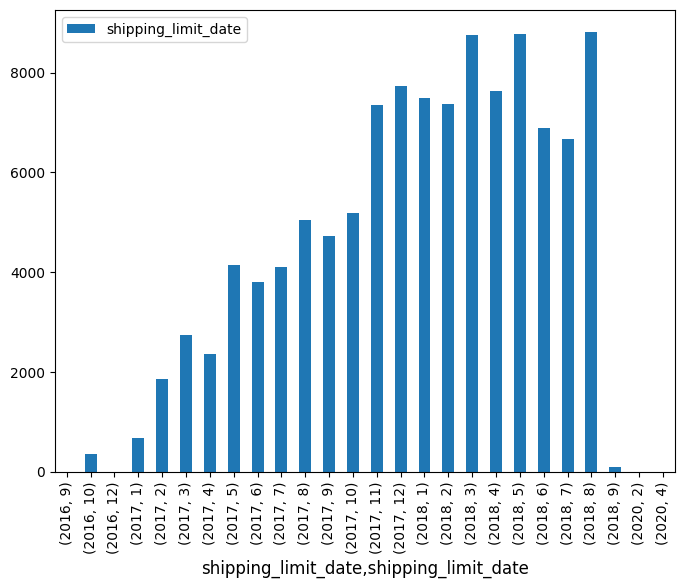

In [173]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

olist_order_items_dataset[['shipping_limit_date']].groupby([olist_order_items_dataset['shipping_limit_date'].dt.year,
                                             olist_order_items_dataset['shipping_limit_date'].dt.month]).count().plot(kind="bar")

In [174]:
olist_order_items_dataset.sort_values(by='order_item_id', ascending=False)

order_id  order_item_id  \
57317   8272b63d03f5f79c56e9e4120aec44ef             21   
57316   8272b63d03f5f79c56e9e4120aec44ef             20   
11951   1b15974a0141d54e36626dca3fdc731a             20   
75122   ab14fdcfbe524636d65ee38360e22ce8             20   
75121   ab14fdcfbe524636d65ee38360e22ce8             19   
...                                  ...            ...   
40059   5b2f8cfd2fc117b59e6a0247d77f07d1              1   
40058   5b2f1ff03b77977af4258e7cfc2ec799              1   
40057   5b2e79428198e5ce482f9ec1bd1014c3              1   
40056   5b2e70f861de8953b06ea667adc2eb4e              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
57317   79ce45dbc2ea29b22b5a261bbb7b7ee7  2709af9587499e95e803a6498a5a56e9   
57316   270516a3f41dc035aa87d220228f844c  2709af9587499e95e803a6498a5a56e9   
11951   ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
75122   9571759451b1d780ee7c15012ea109d4  ce27a3cc3c8cc1ea79d11e561e9bebb6   
75121   9571759451b1d780ee7c15012ea109d4  ce27a3cc3c8cc1ea79d11e561e9bebb6   
...                                  ...                               ...   
40059   4a16cff2de159237df876ff7ba0fceca  9cf787a239c1aa29dbd76f153dc13f9a   
40058   b5adf7b72a7eb667aafd446581c35f3f  c60b801f2d52c7f7f91de00870882a75   
40057   2029248294c186017ecfc48cecd47bbd  d50d79cb34e38265a8649c383dcffd48   
40056   cb80d84cdedee288c467491ed98f5e1f  8ab42aa58097fd4668d60cc648225d5f   
112649  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

       shipping_limit_date   price  freight_value  
57317  2017-07-21 18:25:23    7.80           6.57  
57316  2017-07-21 18:25:23    1.20           7.89  
11951  2018-03-01 02:50:48  100.00          10.12  
75122  2017-08-30 14:30:23   98.70          14.44  
75121  2017-08-30 14:30:23   98.70          14.44  
...                    ...     ...            ...  
40059  2018-06-13 17:53:44   79.00          12.99  
40058  2018-05-03 13:51:08  241.00          19.57  
40057  2017-07-17 04:15:27  126.99          48.33  
40056  2018-05-04 18:29:54  235.00          23.71  
112649 2018-06-12 17:10:13   43.00          12.79  

[112650 rows x 7 columns]

OK, les commandes avec plusieurs items font l'objet de plusieurs lignes, une par item.
Le montant des commandes va évidemment être **CAPITAL**. On ne considérera pas les frais d'expédition.

In [175]:
olist_order_items_dataset.describe()

order_item_id          price  freight_value
count  112650.000000  112650.000000  112650.000000
mean        1.197834     120.653739      19.990320
std         0.705124     183.633928      15.806405
min         1.000000       0.850000       0.000000
25%         1.000000      39.900000      13.080000
50%         1.000000      74.990000      16.260000
75%         1.000000     134.900000      21.150000
max        21.000000    6735.000000     409.680000

In [176]:
olist_order_items_dataset.describe().columns

Index(['order_item_id', 'price', 'freight_value'], dtype='object')

In [177]:
df_dict['olist_order_items_dataset'] = {}

num_cols = olist_order_items_dataset.describe().columns
df_dict['olist_order_items_dataset']['df'] = olist_order_items_dataset
df_dict['olist_order_items_dataset']['num_cols'] = num_cols
df_dict['olist_order_items_dataset']['categ_cols'] = []

### Fichier de commandes, aspect "statut, dates, livraison"

In [178]:
olist_orders_dataset

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp    order_approved_at  \
0        delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
...            ...                      ...                  ...   
99436    delivered      2017-03-09 09:54:05  2017-03-09 09:54:05   
99437    delivered      2018-02-06 12:58:58  2018-02-06 13:10:37   
99438    delivered      2017-08-27 14:46:43  2017-08-27 15:04:16   
99439    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
99440    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99436          2017-03-10 11:18:03           2017-03-17 15:08:01   
99437          2018-02-07 23:22:42           2018-02-28 17:37:56   
99438          2017-08-28 20:52:26           2017-09-21 11:24:17   
99439          2018-01-12 15:35:03           2018-01-25 23:32:54   
99440          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  
0               2017-10-18 00:00:00  
1               2018-08-13 00:00:00  
2               2018-09-04 00:00:00  
3               2017-12-15 00:00:00  
4               2018-02-26 00:00:00  
...                             ...  
99436           2017-03-28 00:00:00  
99437           2018-03-02 00:00:00  
99438           2017-09-27 00:00:00  
99439           2018-02-15 00:00:00  
99440           2018-04-03 00:00:00  

[99441 rows x 8 columns]

In [179]:
olist_orders_dataset.shape

(99441, 8)

In [180]:
olist_orders_dataset.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

On assure le type `datetime64` pour toutes les colonnes de date :

In [181]:
for col in ['order_purchase_timestamp',
            'order_approved_at', 'order_delivered_carrier_date',
            'order_delivered_customer_date', 'order_estimated_delivery_date']:
    olist_orders_dataset[col] = olist_orders_dataset[col].astype("datetime64")

In [182]:
olist_orders_dataset.describe(datetime_is_numeric=True)

order_purchase_timestamp              order_approved_at  \
count                          99441                          99281   
mean   2017-12-31 08:43:12.776581120  2017-12-31 18:35:24.098800128   
min              2016-09-04 21:15:19            2016-09-15 12:16:38   
25%              2017-09-12 14:46:19            2017-09-12 23:24:16   
50%              2018-01-18 23:04:36            2018-01-19 11:36:13   
75%              2018-05-04 15:42:16            2018-05-04 20:35:10   
max              2018-10-17 17:30:18            2018-09-03 17:40:06   

        order_delivered_carrier_date  order_delivered_customer_date  \
count                          97658                          96476   
mean   2018-01-04 21:49:48.138278656  2018-01-14 12:09:19.035542272   
min              2016-10-08 10:34:01            2016-10-11 13:46:32   
25%    2017-09-15 22:28:50.249999872  2017-09-25 22:07:22.249999872   
50%              2018-01-24 16:10:58     2018-02-02 19:28:10.500000   
75%              2018-05-08 13:37:45  2018-05-15 22:48:52.249999872   
max              2018-09-11 19:48:28            2018-10-17 13:22:46   

       order_estimated_delivery_date  
count                          99441  
mean   2018-01-24 03:08:37.730111232  
min              2016-09-30 00:00:00  
25%              2017-10-03 00:00:00  
50%              2018-02-15 00:00:00  
75%              2018-05-25 00:00:00  
max              2018-11-12 00:00:00

In [183]:
df_dict['olist_orders_dataset'] = {}

num_cols = ['order_purchase_timestamp',
            'order_approved_at', 'order_delivered_carrier_date',
            'order_delivered_customer_date', 'order_estimated_delivery_date']
df_dict['olist_orders_dataset']['df'] = olist_orders_dataset
df_dict['olist_orders_dataset']['num_cols'] = num_cols
df_dict['olist_orders_dataset']['categ_cols'] = ['order_status']

<AxesSubplot: xlabel='order_purchase_timestamp,order_purchase_timestamp'>

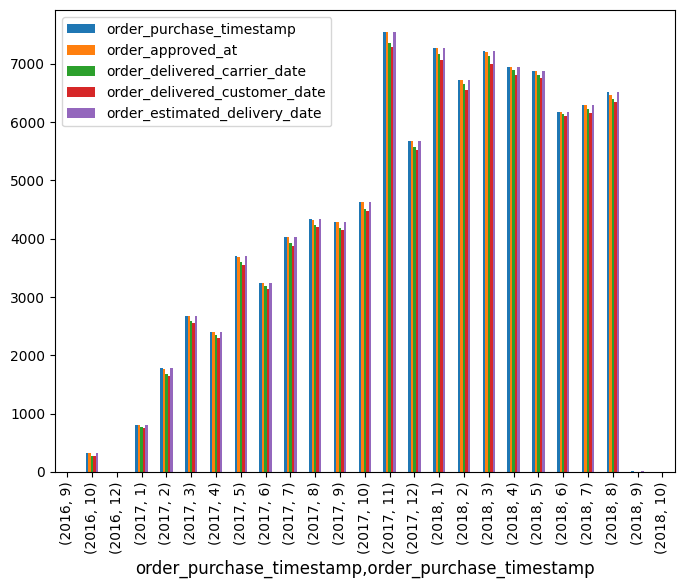

In [184]:
olist_orders_dataset[num_cols].groupby(
    [olist_orders_dataset['order_purchase_timestamp'].dt.year,
     olist_orders_dataset['order_purchase_timestamp'].dt.month]
).count().plot(kind="bar")

Certaines commandes datent d'avant le 2017/01/01, il faudra les supprimer (partie nettoyage). D'autre part, très peu de commandes de 2018/09 et 2018/10 sont présentes, il vaut mieux également les supprimer.

### Fichier de paiements 

In [185]:
olist_order_payments_dataset

order_id  payment_sequential payment_type  \
0       b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1       a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2       25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3       ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4       42fdf880ba16b47b59251dd489d4441a                   1  credit_card   
...                                  ...                 ...          ...   
103881  0406037ad97740d563a178ecc7a2075c                   1       boleto   
103882  7b905861d7c825891d6347454ea7863f                   1  credit_card   
103883  32609bbb3dd69b3c066a6860554a77bf                   1  credit_card   
103884  b8b61059626efa996a60be9bb9320e10                   1  credit_card   
103885  28bbae6599b09d39ca406b747b6632b1                   1       boleto   

        payment_installments  payment_value  
0                          8          99.33  
1                          1          24.39  
2                          1          65.71  
3                          8         107.78  
4                          2         128.45  
...                      ...            ...  
103881                     1         363.31  
103882                     2          96.80  
103883                     1          47.77  
103884                     5         369.54  
103885                     1         191.58  

[103886 rows x 5 columns]

In [186]:
olist_order_payments_dataset.shape

(103886, 5)

In [187]:
olist_order_payments_dataset.describe()

payment_sequential  payment_installments  payment_value
count       103886.000000         103886.000000  103886.000000
mean             1.092679              2.853349     154.100380
std              0.706584              2.687051     217.494064
min              1.000000              0.000000       0.000000
25%              1.000000              1.000000      56.790000
50%              1.000000              1.000000     100.000000
75%              1.000000              4.000000     171.837500
max             29.000000             24.000000   13664.080000

In [188]:
olist_order_payments_dataset['payment_sequential'].value_counts()

1     99360
2      3039
3       581
4       278
5       170
6       118
7        82
8        54
9        43
10       34
11       29
12       21
13       13
14       10
15        8
18        6
19        6
16        6
17        6
21        4
20        4
22        3
26        2
24        2
23        2
25        2
29        1
28        1
27        1
Name: payment_sequential, dtype: int64

In [189]:
olist_order_payments_dataset['payment_type'].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

In [190]:
olist_order_payments_dataset['payment_installments'].unique()

array([ 8,  1,  2,  3,  6,  5,  4, 10,  7, 12,  9, 13, 15, 24, 11, 18, 14,
       20, 21, 17, 22,  0, 16, 23], dtype=int64)

In [191]:
olist_order_payments_dataset.loc[olist_order_payments_dataset['payment_installments']==0]

order_id  payment_sequential payment_type  \
46982  744bade1fcf9ff3f31d860ace076d422                   2  credit_card   
79014  1a57108394169c0b47d8f876acc9ba2d                   2  credit_card   

       payment_installments  payment_value  
46982                     0          58.69  
79014                     0         129.94

Ah, des paiments ont été fractionnés en 0 fois ?! Il faudra les supprimer (phase de nettoyage).

In [192]:
olist_order_payments_dataset.columns

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

In [193]:
df_dict['olist_order_payments_dataset'] = {}

num_cols = olist_order_payments_dataset.describe().columns
df_dict['olist_order_payments_dataset']['df'] = olist_order_payments_dataset
df_dict['olist_order_payments_dataset']['num_cols'] = num_cols
df_dict['olist_order_payments_dataset']['categ_cols'] = ['payment_type']

### Fichier des avis de commande

In [194]:
olist_order_reviews_dataset

review_id                          order_id  \
0      7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1      80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2      228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3      e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4      f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   
...                                 ...                               ...   
99219  574ed12dd733e5fa530cfd4bbf39d7c9  2a8c23fee101d4d5662fa670396eb8da   
99220  f3897127253a9592a73be9bdfdf4ed7a  22ec9f0669f784db00fa86d035cf8602   
99221  b3de70c89b1510c4cd3d0649fd302472  55d4004744368f5571d1f590031933e4   
99222  1adeb9d84d72fe4e337617733eb85149  7725825d039fc1f0ceb7635e3f7d9206   
99223  efe49f1d6f951dd88b51e6ccd4cc548f  90531360ecb1eec2a1fbb265a0db0508   

       review_score review_comment_title  \
0                 4                  NaN   
1                 5                  NaN   
2                 5                  NaN   
3                 5                  NaN   
4                 5                  NaN   
...             ...                  ...   
99219             5                  NaN   
99220             5                  NaN   
99221             5                  NaN   
99222             4                  NaN   
99223             1                  NaN   

                                  review_comment_message review_creation_date  \
0                                                    NaN  2018-01-18 00:00:00   
1                                                    NaN  2018-03-10 00:00:00   
2                                                    NaN  2018-02-17 00:00:00   
3                  Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4      Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   
...                                                  ...                  ...   
99219                                                NaN  2018-07-07 00:00:00   
99220                                                NaN  2017-12-09 00:00:00   
99221  Excelente mochila, entrega super rápida. Super...  2018-03-22 00:00:00   
99222                                                NaN  2018-07-01 00:00:00   
99223  meu produto chegou e ja tenho que devolver, po...  2017-07-03 00:00:00   

      review_answer_timestamp  
0         2018-01-18 21:46:59  
1         2018-03-11 03:05:13  
2         2018-02-18 14:36:24  
3         2017-04-21 22:02:06  
4         2018-03-02 10:26:53  
...                       ...  
99219     2018-07-14 17:18:30  
99220     2017-12-11 20:06:42  
99221     2018-03-23 09:10:43  
99222     2018-07-02 12:59:13  
99223     2017-07-03 21:01:49  

[99224 rows x 7 columns]

In [195]:
olist_order_reviews_dataset.shape

(99224, 7)

In [196]:
olist_order_reviews_dataset.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

On assure le type `datetime64` pour toutes les colonnes de date :

In [197]:
for col in ['review_creation_date', 'review_answer_timestamp']:
    olist_order_reviews_dataset[col] = olist_order_reviews_dataset[col].astype("datetime64")

<AxesSubplot: xlabel='review_creation_date,review_creation_date'>

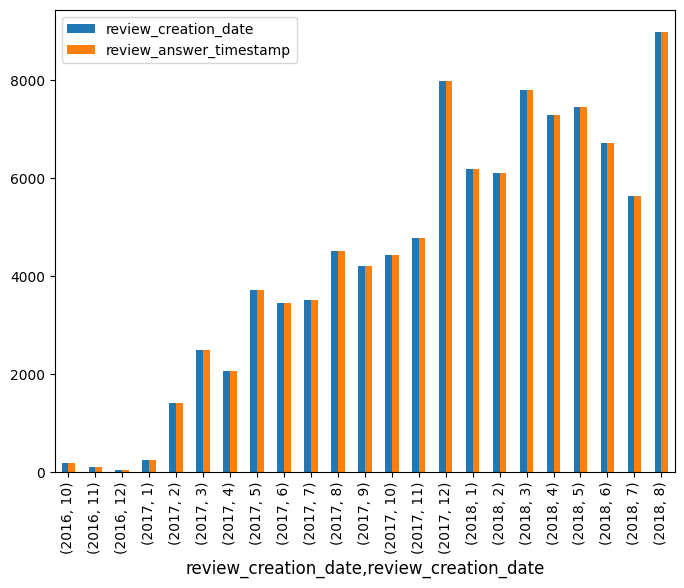

In [198]:
olist_order_reviews_dataset[['review_creation_date', 'review_answer_timestamp']].groupby(
    [olist_order_reviews_dataset['review_creation_date'].dt.year,
     olist_order_reviews_dataset['review_creation_date'].dt.month]
).count().plot(kind="bar")

In [199]:
olist_order_reviews_dataset['review_score'].value_counts()

5    57328
4    19142
1    11424
3     8179
2     3151
Name: review_score, dtype: int64

In [200]:
olist_order_reviews_dataset.describe()

review_score
count  99224.000000
mean       4.086421
std        1.347579
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000

On conservera les scores, car ils peuvent traduire et cibler les clients contents de leur achat, donc susceptibles de passer une prochaine commande.
Les données propres aux commentaires ne seront pas exploitées.

In [201]:
df_dict['olist_order_reviews_dataset'] = {}

num_cols = olist_order_reviews_dataset.describe().columns
df_dict['olist_order_reviews_dataset']['df'] = olist_order_reviews_dataset
df_dict['olist_order_reviews_dataset']['num_cols'] = num_cols
df_dict['olist_order_reviews_dataset']['categ_cols'] = []

### Fichier de produits

In [202]:
olist_products_dataset

product_id              product_category_name  \
0      1e9e8ef04dbcff4541ed26657ea517e5                         perfumaria   
1      3aa071139cb16b67ca9e5dea641aaa2f                              artes   
2      96bd76ec8810374ed1b65e291975717f                      esporte_lazer   
3      cef67bcfe19066a932b7673e239eb23d                              bebes   
4      9dc1a7de274444849c219cff195d0b71              utilidades_domesticas   
...                                 ...                                ...   
32946  a0b7d5a992ccda646f2d34e418fff5a0                   moveis_decoracao   
32947  bf4538d88321d0fd4412a93c974510e6  construcao_ferramentas_iluminacao   
32948  9a7c6041fa9592d9d9ef6cfe62a71f8c                    cama_mesa_banho   
32949  83808703fc0706a22e264b9d75f04a2e             informatica_acessorios   
32950  106392145fca363410d287a815be6de4                    cama_mesa_banho   

       product_name_lenght  product_description_lenght  product_photos_qty  \
0                     40.0                       287.0                 1.0   
1                     44.0                       276.0                 1.0   
2                     46.0                       250.0                 1.0   
3                     27.0                       261.0                 1.0   
4                     37.0                       402.0                 4.0   
...                    ...                         ...                 ...   
32946                 45.0                        67.0                 2.0   
32947                 41.0                       971.0                 1.0   
32948                 50.0                       799.0                 1.0   
32949                 60.0                       156.0                 2.0   
32950                 58.0                       309.0                 1.0   

       product_weight_g  product_length_cm  product_height_cm  \
0                 225.0               16.0               10.0   
1                1000.0               30.0               18.0   
2                 154.0               18.0                9.0   
3                 371.0               26.0                4.0   
4                 625.0               20.0               17.0   
...                 ...                ...                ...   
32946           12300.0               40.0               40.0   
32947            1700.0               16.0               19.0   
32948            1400.0               27.0                7.0   
32949             700.0               31.0               13.0   
32950            2083.0               12.0                2.0   

       product_width_cm  
0                  14.0  
1                  20.0  
2                  15.0  
3                  26.0  
4                  13.0  
...                 ...  
32946              40.0  
32947              16.0  
32948              27.0  
32949              20.0  
32950               7.0  

[32951 rows x 9 columns]

In [203]:
olist_products_dataset.shape

(32951, 9)

In [204]:
olist_products_dataset.describe()

product_name_lenght  product_description_lenght  product_photos_qty  \
count         32341.000000                32341.000000        32341.000000   
mean             48.476949                  771.495285            2.188986   
std              10.245741                  635.115225            1.736766   
min               5.000000                    4.000000            1.000000   
25%              42.000000                  339.000000            1.000000   
50%              51.000000                  595.000000            1.000000   
75%              57.000000                  972.000000            3.000000   
max              76.000000                 3992.000000           20.000000   

       product_weight_g  product_length_cm  product_height_cm  \
count      32949.000000       32949.000000       32949.000000   
mean        2276.472488          30.815078          16.937661   
std         4282.038731          16.914458          13.637554   
min            0.000000           7.000000           2.000000   
25%          300.000000          18.000000           8.000000   
50%          700.000000          25.000000          13.000000   
75%         1900.000000          38.000000          21.000000   
max        40425.000000         105.000000         105.000000   

       product_width_cm  
count      32949.000000  
mean          23.196728  
std           12.079047  
min            6.000000  
25%           15.000000  
50%           20.000000  
75%           30.000000  
max          118.000000

In [205]:
olist_products_dataset.columns

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

In [206]:
df_dict['olist_products_dataset'] = {}

num_cols = olist_products_dataset.describe().columns
df_dict['olist_products_dataset']['df'] = olist_products_dataset
df_dict['olist_products_dataset']['num_cols'] = num_cols
df_dict['olist_products_dataset']['categ_cols'] = ['product_category_name']

### Fichier de vendeurs  

In [207]:
olist_sellers_dataset

seller_id  seller_zip_code_prefix  \
0     3442f8959a84dea7ee197c632cb2df15                   13023   
1     d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2     ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3     c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4     51a04a8a6bdcb23deccc82b0b80742cf                   12914   
...                                ...                     ...   
3090  98dddbc4601dd4443ca174359b237166                   87111   
3091  f8201cab383e484733266d1906e2fdfa                   88137   
3092  74871d19219c7d518d0090283e03c137                    4650   
3093  e603cf3fec55f8697c9059638d6c8eb5                   96080   
3094  9e25199f6ef7e7c347120ff175652c3b                   12051   

            seller_city seller_state  
0              campinas           SP  
1            mogi guacu           SP  
2        rio de janeiro           RJ  
3             sao paulo           SP  
4     braganca paulista           SP  
...                 ...          ...  
3090            sarandi           PR  
3091            palhoca           SC  
3092          sao paulo           SP  
3093            pelotas           RS  
3094            taubate           SP  

[3095 rows x 4 columns]

In [208]:
olist_sellers_dataset.shape

(3095, 4)

In [209]:
olist_sellers_dataset.describe()

seller_zip_code_prefix
count             3095.000000
mean             32291.059451
std              32713.453830
min               1001.000000
25%               7093.500000
50%              14940.000000
75%              64552.500000
max              99730.000000

Pas convaincu que le profil des vendeurs soit utile au problème, si on doit faire simple.

In [210]:
olist_sellers_dataset.columns

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')

In [211]:
df_dict['olist_sellers_dataset'] = {}

num_cols = []
df_dict['olist_sellers_dataset']['df'] = olist_sellers_dataset
df_dict['olist_sellers_dataset']['num_cols'] = num_cols
df_dict['olist_sellers_dataset']['categ_cols'] = [
    'seller_zip_code_prefix', 'seller_city', 'seller_state'
]

### Fichier de traduction des catégories

In [212]:
product_category_name_translation

product_category_name  \
0                                     beleza_saude   
1                           informatica_acessorios   
2                                       automotivo   
3                                  cama_mesa_banho   
4                                 moveis_decoracao   
5                                    esporte_lazer   
6                                       perfumaria   
7                            utilidades_domesticas   
8                                        telefonia   
9                               relogios_presentes   
10                               alimentos_bebidas   
11                                           bebes   
12                                       papelaria   
13                        tablets_impressao_imagem   
14                                      brinquedos   
15                                  telefonia_fixa   
16                              ferramentas_jardim   
17                     fashion_bolsas_e_acessorios   
18                                 eletroportateis   
19                                  consoles_games   
20                                           audio   
21                                fashion_calcados   
22                                      cool_stuff   
23                                malas_acessorios   
24                                    climatizacao   
25               construcao_ferramentas_construcao   
26  moveis_cozinha_area_de_servico_jantar_e_jardim   
27                   construcao_ferramentas_jardim   
28                         fashion_roupa_masculina   
29                                        pet_shop   
30                               moveis_escritorio   
31                                    market_place   
32                                     eletronicos   
33                                eletrodomesticos   
34                               artigos_de_festas   
35                                   casa_conforto   
36              construcao_ferramentas_ferramentas   
37                       agro_industria_e_comercio   
38                       moveis_colchao_e_estofado   
39                                 livros_tecnicos   
40                                 casa_construcao   
41                           instrumentos_musicais   
42                                     moveis_sala   
43               construcao_ferramentas_iluminacao   
44                   industria_comercio_e_negocios   
45                                       alimentos   
46                                           artes   
47                                   moveis_quarto   
48                          livros_interesse_geral   
49                construcao_ferramentas_seguranca   
50                  fashion_underwear_e_moda_praia   
51                                 fashion_esporte   
52                         sinalizacao_e_seguranca   
53                                             pcs   
54                                artigos_de_natal   
55                          fashion_roupa_feminina   
56                              eletrodomesticos_2   
57                               livros_importados   
58                                         bebidas   
59                                       cine_foto   
60                                      la_cuisine   
61                                          musica   
62                                 casa_conforto_2   
63                     portateis_casa_forno_e_cafe   
64                               cds_dvds_musicais   
65                                    dvds_blu_ray   
66                                          flores   
67                              artes_e_artesanato   
68                                 fraldas_higiene   
69                   fashion_roupa_infanto_juvenil   
70                              seguros_e_servicos   

              product_category_name_english  
0                             health_beauty  
1                     computers_accessories  
2 

In [213]:
product_category_name_translation.shape

(71, 2)

In [214]:
product_category_name_translation['product_category_name_english'].isna().sum()

0

In [215]:
product_category_name_translation.describe()

product_category_name product_category_name_english
count                     71                            71
unique                    71                            71
top             beleza_saude                 health_beauty
freq                       1                             1

In [216]:
product_category_name_translation.columns

Index(['product_category_name', 'product_category_name_english'], dtype='object')

In [217]:
df_dict['product_category_name_translation'] = {}

num_cols = []
df_dict['product_category_name_translation']['df'] = product_category_name_translation
df_dict['product_category_name_translation']['num_cols'] = num_cols
df_dict['product_category_name_translation']['categ_cols'] = ['product_category_name', 'product_category_name_english']

### Dimensions totales des fichiers et des données

In [218]:
s0 = 0
s1 = 0
n = 0
for df in [
    olist_customers_dataset,
    olist_geolocation_dataset,
    olist_order_items_dataset,
    olist_order_payments_dataset,
    olist_order_reviews_dataset,
    olist_orders_dataset,
    olist_products_dataset,
    olist_sellers_dataset,
    product_category_name_translation
    ]:
    s0 += df.shape[0]
    s1 += df.shape[1]
    n += s0*s1
print(f"Total file size: {(s0, s1)}")
print(f"Total number of informations: {n}")

Total file size: (1550922, 52)
Total number of informations: 387537254


### Nombre et taux de valeurs manquantes

In [219]:
nan_nb = 0
for dic in df_dict:
    df = df_dict[dic]['df']
    n = df.isna().sum().sum()
    nan_nb += n
    print(f"{dic} : {n}")
print(f"Total number of missing values: {nan_nb}")

olist_customers_dataset : 0
olist_geolocation_dataset : 0
olist_order_items_dataset : 0
olist_orders_dataset : 4908
olist_order_payments_dataset : 0
olist_order_reviews_dataset : 145903
olist_products_dataset : 2448
olist_sellers_dataset : 0
product_category_name_translation : 0
Total number of missing values: 153259


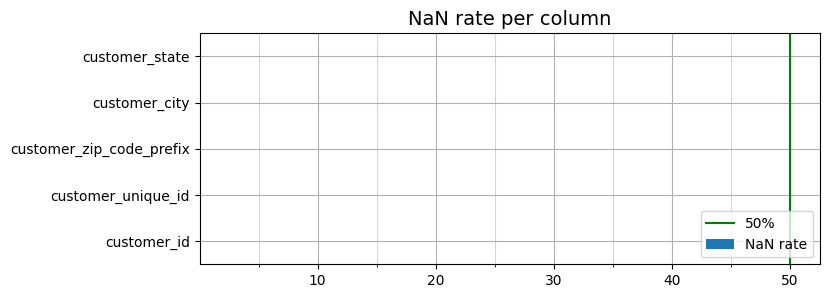

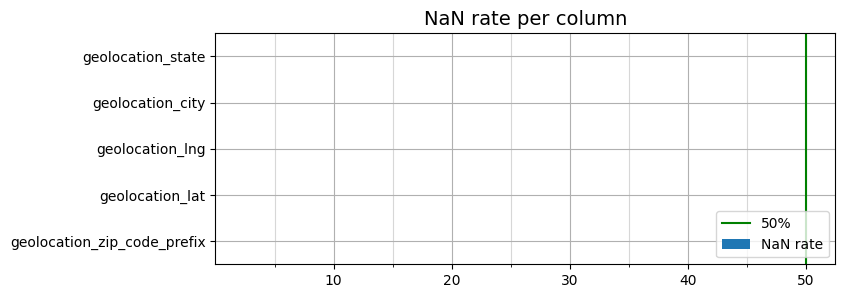

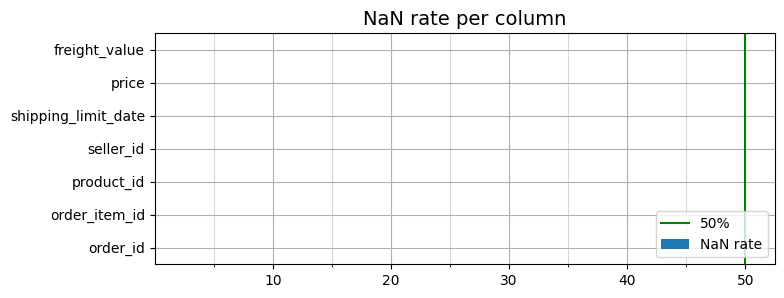

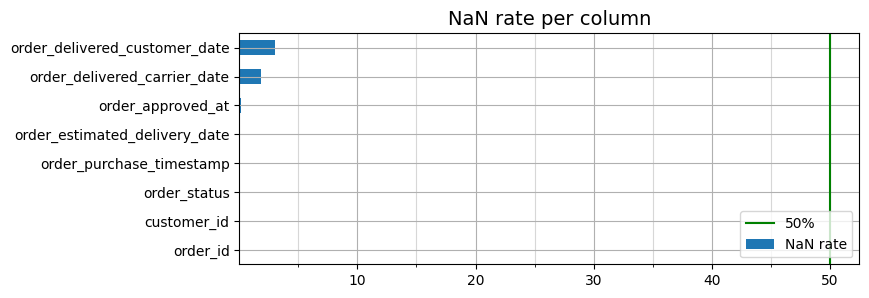

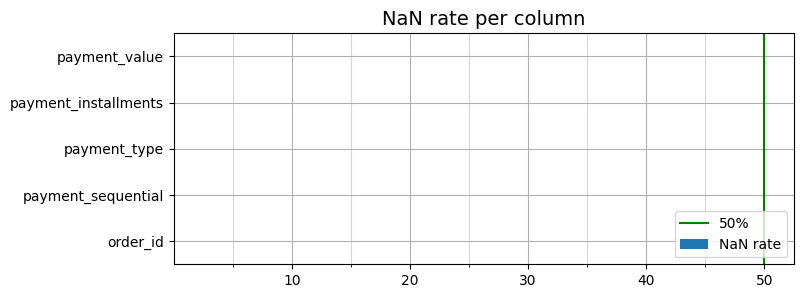

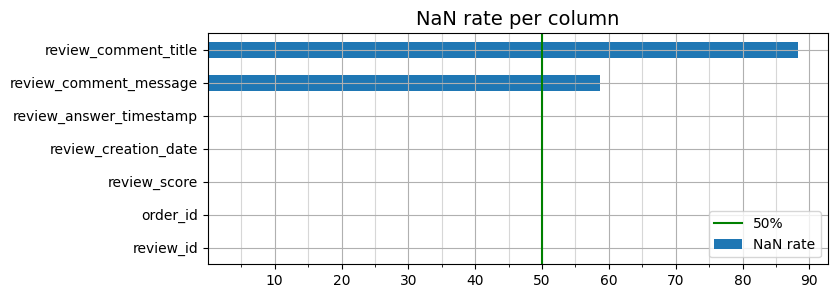

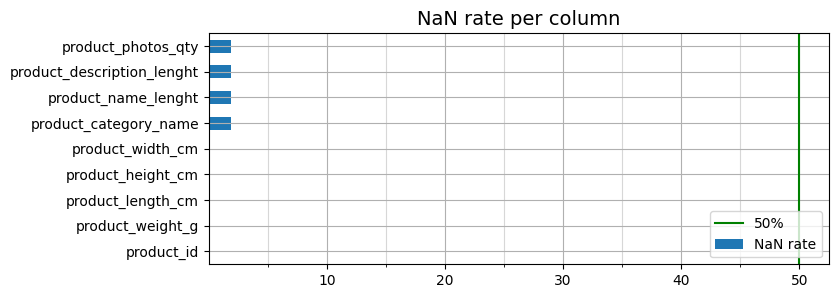

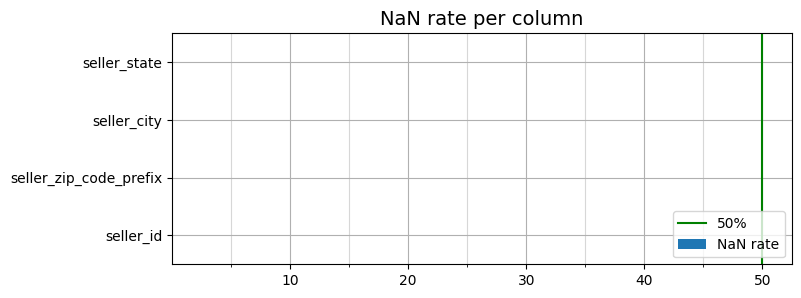

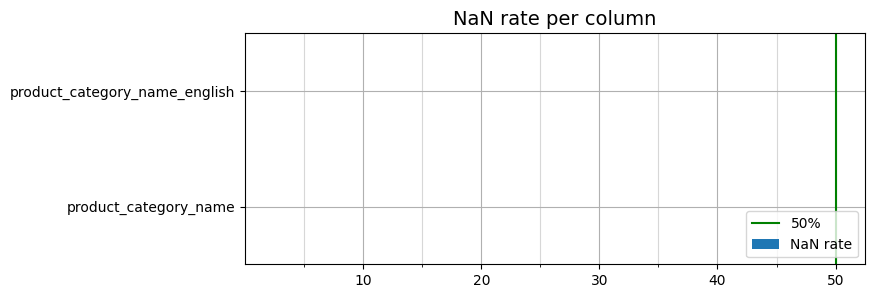

In [220]:
plt.rcParams['figure.figsize'] = [8, 3]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

for dic in df_dict:
    df = df_dict[dic]['df']
    nan_rate = df.isna().sum(axis=0).sort_values()/df.shape[0]*100.
    DisplotData.print_nan_rates(nan_rate, 50., seuil=None)

### Gestion des valeurs manquantes

Le faible taux de valeurs manquantes ne nous pousse pas à imputer celles-ci. Nous supprimons les lignes avec des valeurs manquantes.

In [221]:
for dic in df_dict:
    df = df_dict[dic]['df']
    nan_rate = df.isna().sum(axis=0).sort_values()/df.shape[0]*100.
    print(nan_rate)
    df_dict[dic]['df'] = df.dropna()

customer_id                 0.0
customer_unique_id          0.0
customer_zip_code_prefix    0.0
customer_city               0.0
customer_state              0.0
dtype: float64
geolocation_zip_code_prefix    0.0
geolocation_lat                0.0
geolocation_lng                0.0
geolocation_city               0.0
geolocation_state              0.0
dtype: float64
order_id               0.0
order_item_id          0.0
product_id             0.0
seller_id              0.0
shipping_limit_date    0.0
price                  0.0
freight_value          0.0
dtype: float64
order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_estimated_delivery_date    0.000000
order_approved_at                0.160899
order_delivered_carrier_date     1.793023
order_delivered_customer_date    2.981668
dtype: float64
order_id                0.0
payment_sequential      0.0
payment_type            

In [222]:
df_dict['olist_order_reviews_dataset']['df'].isna().sum(axis=0)

review_id                  0
order_id                   0
review_score               0
review_comment_title       0
review_comment_message     0
review_creation_date       0
review_answer_timestamp    0
dtype: int64

### Value counts

In [223]:
for dic in df_dict:
    df = df_dict[dic]['df']
    print(bcolors.BOLD+bcolors.UNDERLINE+f"File: {dic}\n"+bcolors.ENDC) # Py3.8
    DisplotData.print_value_counts(df,exclude=None)
    print('\n\n')

File: olist_customers_dataset

Legend :

Numerical variable
------------------

Categorical variable
--------------------

----------------------------------------------------------------------------------------------------


customer_unique_id
------------------
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
1b6c7548a2a1f9037c1fd3ddfed95f33     7
ca77025e7201e3b30c44b472ff346268     7
6469f99c1f9dfae7733b25662e7f1782     7
                                    ..
081f07439678af2da7755a0aa572154d     1
9c57789a6a587f4efcfb01e36c106014     1
9e4c21635f640562de1a6976374fba03     1
06c0ea6ee892364d1608ee47aa9f56a0     1
84732c5050c01db9b23e19ba39899398     1
Name: customer_unique_id, Length: 96096, dtype: int64


customer_id
-----------
06b8999e2fba1a1fbc88172c00ba8bc7    1
c023f30c1147aeb0358474f3b1dbc707    1
b5cbf43f42281920a175fc99650c91d6    1
19f4e983f8f05b7de16670f8a0cf0ac7    1
229ac14c6ee6d6a606264ebcc861beb7    1
                                   ..

- [X] Un payment_installments vaut 0 : à comprendre voire corriger
- [X] not_defined (3) : à supprimer
- [X] order_status : peut-être qu'un tri des commandes est à faire : 
```
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
```
 --> ne conserver que les `delivered`, par exemple

### Premières études univariées

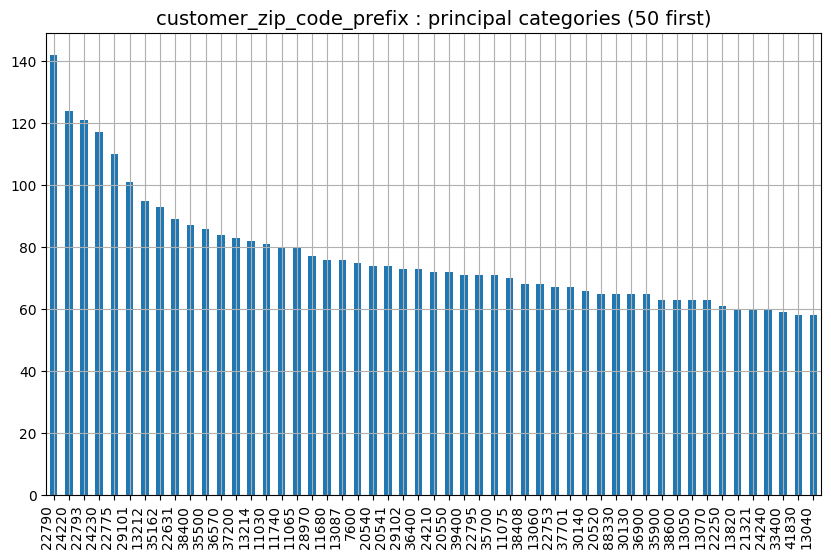

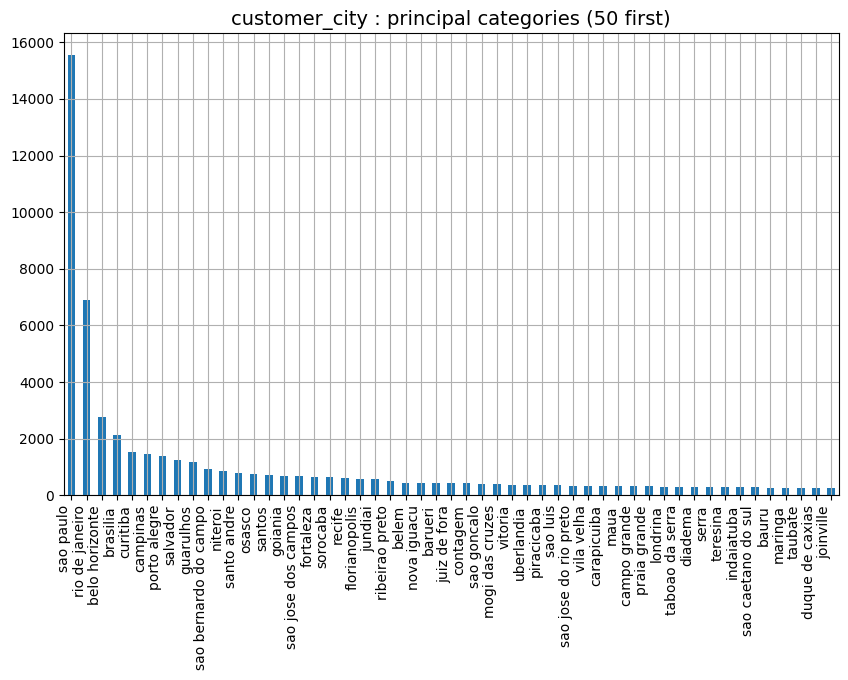

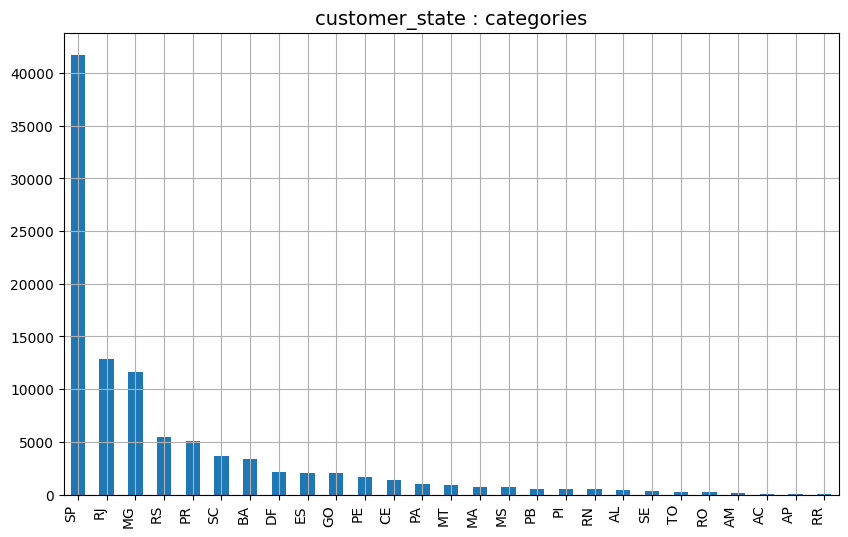

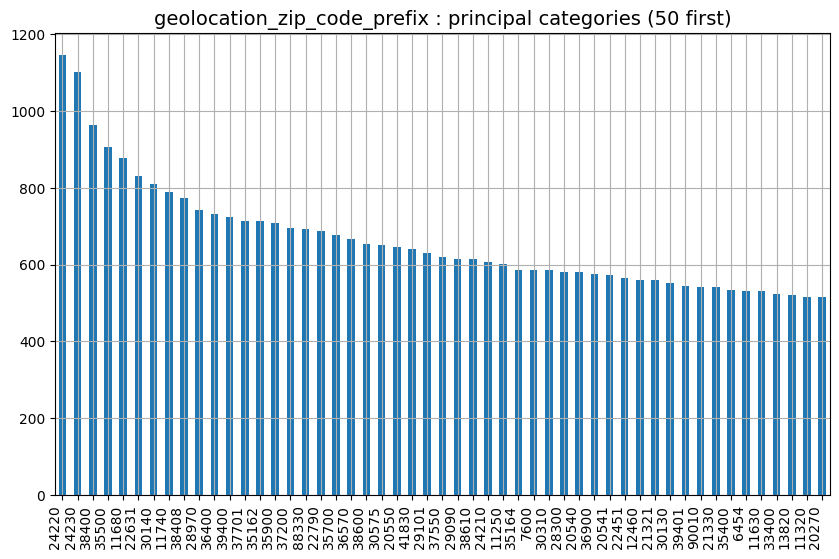

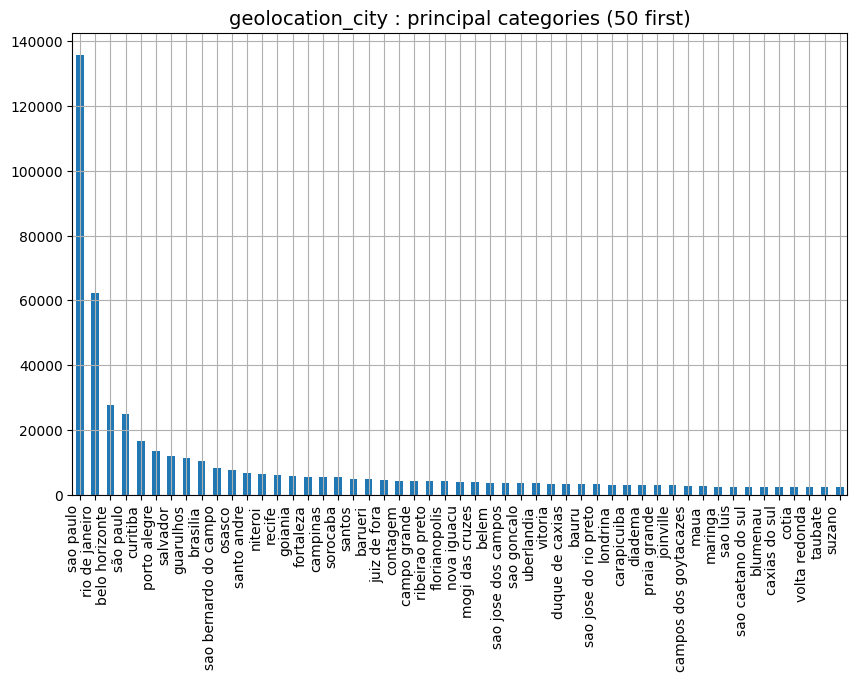

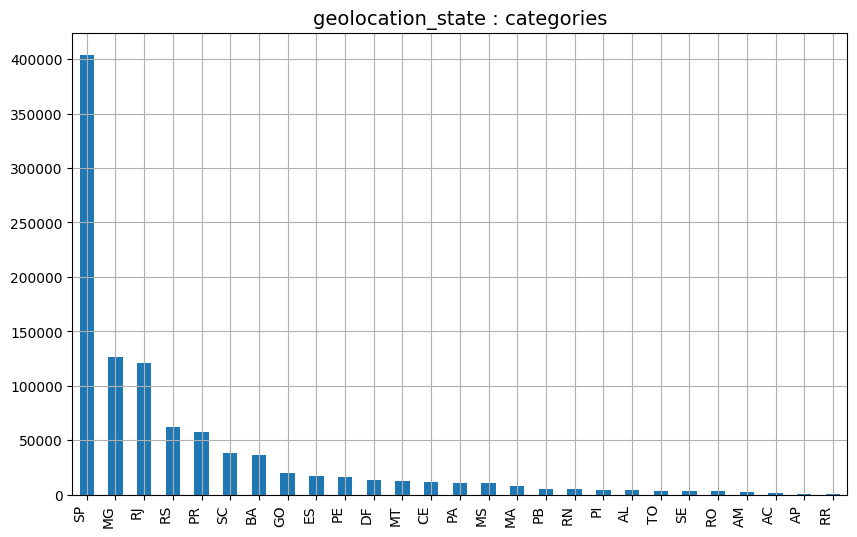

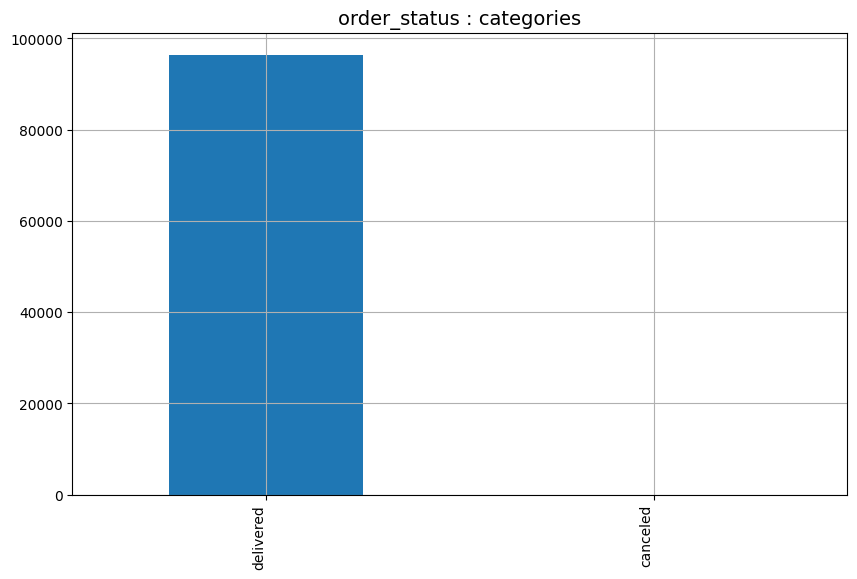

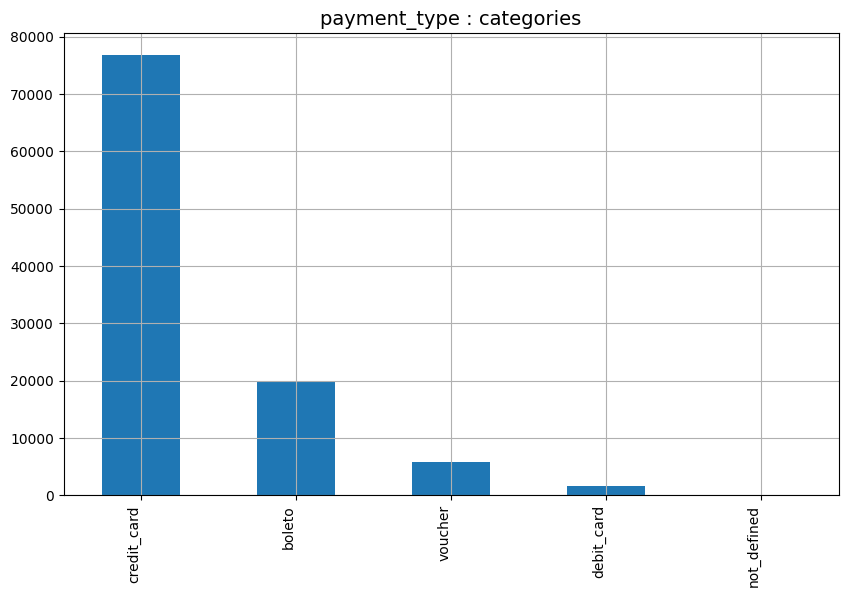

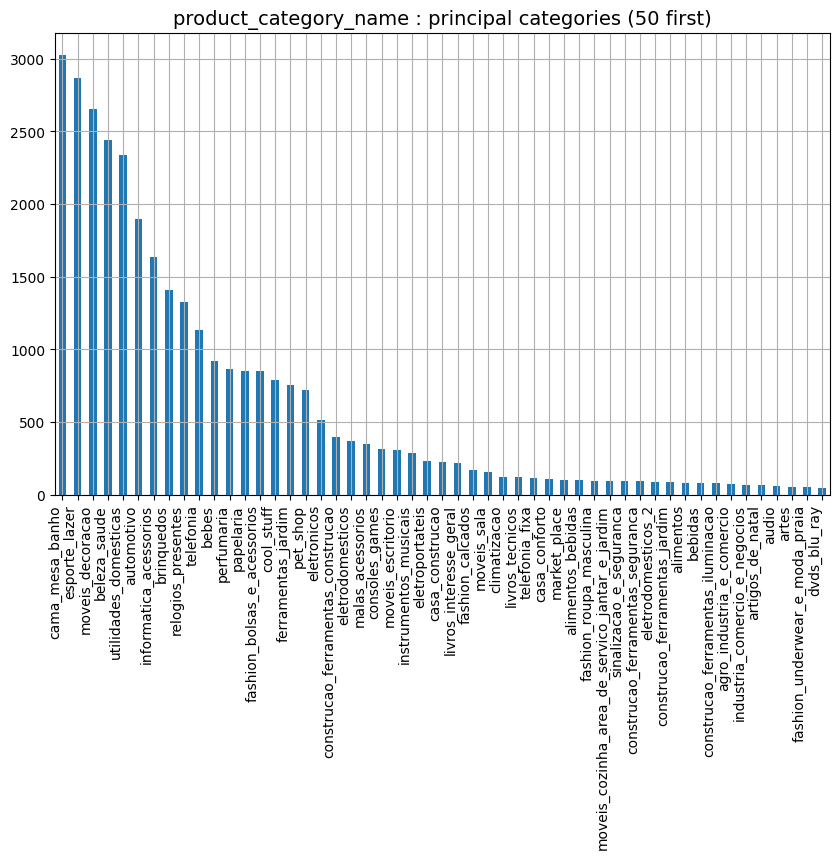

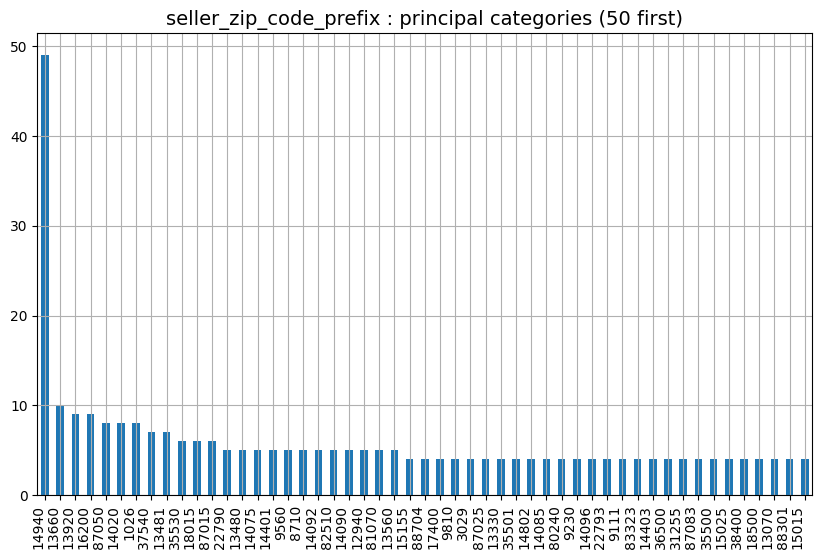

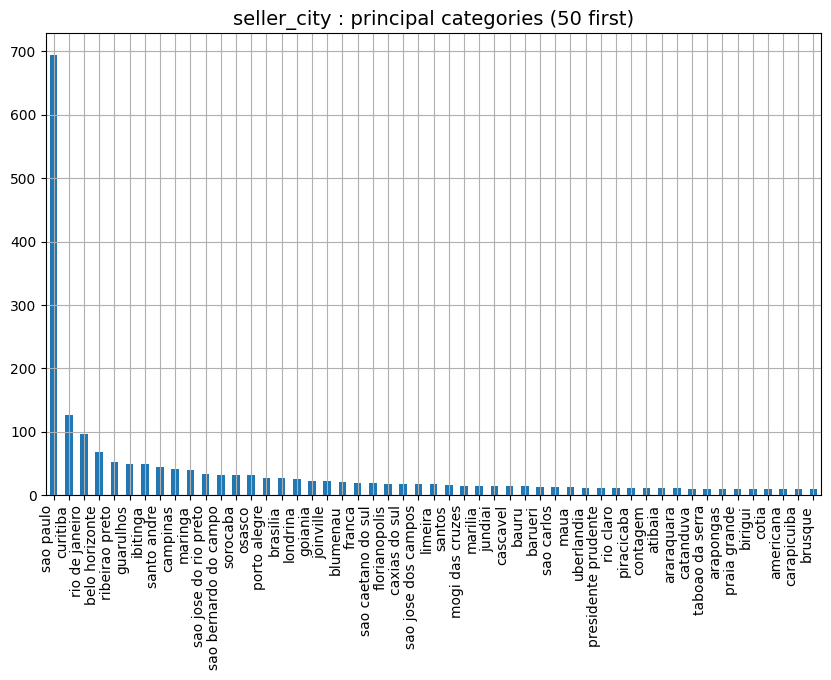

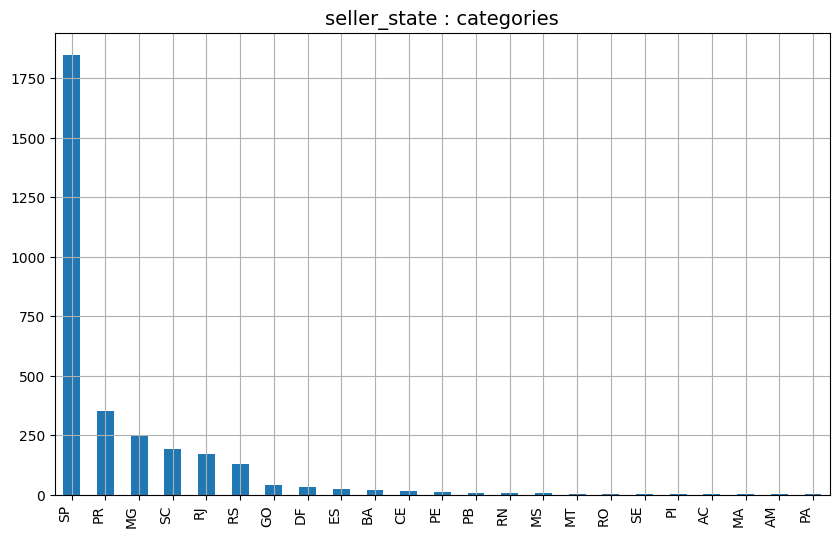

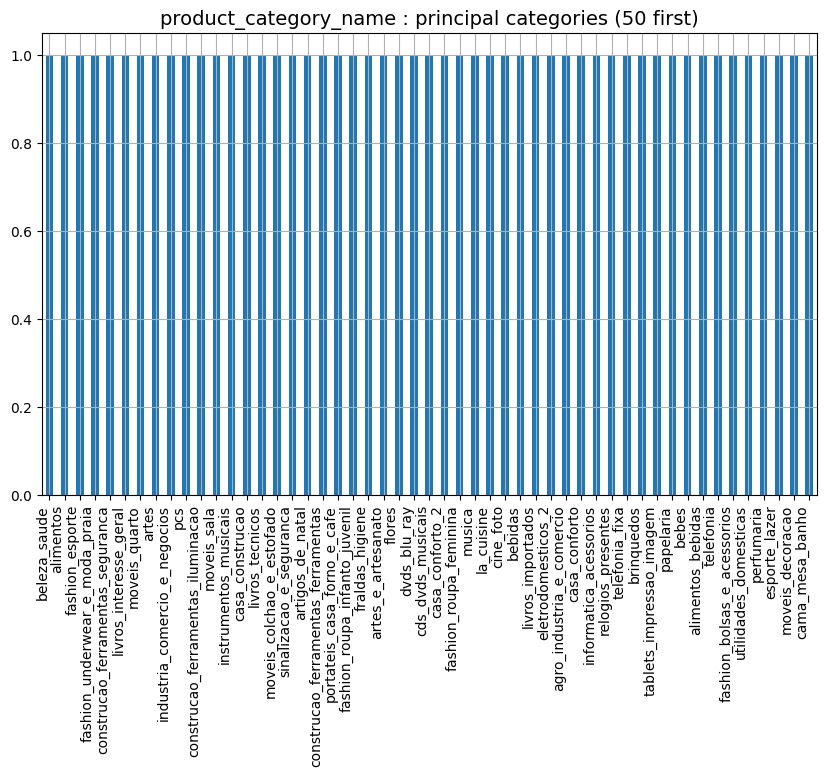

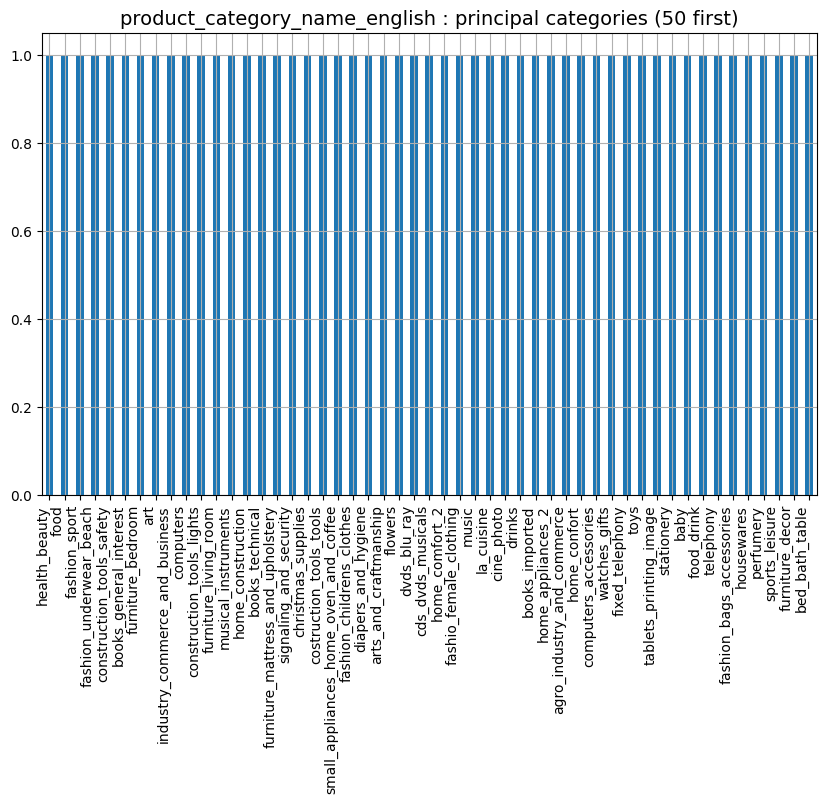

In [224]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
for dic in df_dict:
    df = df_dict[dic]['df']
    categ_cols = df_dict[dic]['categ_cols']
    n = len(categ_cols)
    for colonne in categ_cols:
        DisplotData.plot_categ_bars(df, colonne, seuil=1., max_bar=50, kind='bar', rot=90, show_nan=False)

### Sélection des colonnes

Pas la peine de dégraisser les datasets, on sélectionnera les colonnes au moment de récupérer les données agrégées.

### Fusion des doublons

#### olist_customers_dataset

In [225]:
olist_customers_dataset.loc[olist_customers_dataset['customer_id'].duplicated(keep='last'), :]

Empty DataFrame
Columns: [customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state]
Index: []

#### olist_geolocation_dataset

In [226]:
olist_geolocation_dataset.loc[olist_geolocation_dataset['geolocation_zip_code_prefix'].duplicated(keep='last'), :]

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                               1037       -23.545621       -46.639292   
1                               1046       -23.546081       -46.644820   
2                               1046       -23.546129       -46.642951   
3                               1041       -23.544392       -46.639499   
4                               1035       -23.541578       -46.641607   
...                              ...              ...              ...   
1000154                        99950       -28.070493       -52.011342   
1000156                        99950       -28.072188       -52.011272   
1000157                        99950       -28.068864       -52.012964   
1000158                        99950       -28.068639       -52.010705   
1000160                        99950       -28.071855       -52.014716   

        geolocation_city geolocation_state  
0              sao paulo                SP  
1              sao paulo                SP  
2              sao paulo                SP  
3              sao paulo                SP  
4              sao paulo                SP  
...                  ...               ...  
1000154         tapejara                RS  
1000156         tapejara                RS  
1000157         tapejara                RS  
1000158         tapejara                RS  
1000160         tapejara                RS  

[981148 rows x 5 columns]

Plein de doublons mais pas gênant pour cette table.

#### olist_order_items_dataset

In [227]:
olist_order_items_dataset.loc[olist_order_items_dataset['order_id'].duplicated(keep='last'), :]

order_id  order_item_id  \
13      0008288aa423d2a3f00fcb17cd7d8719              1   
32      00143d0f86d6fbd9f9b38ab440ac16f5              1   
33      00143d0f86d6fbd9f9b38ab440ac16f5              2   
42      001ab0a7578dd66cd4b0a71f5b6e1e41              1   
43      001ab0a7578dd66cd4b0a71f5b6e1e41              2   
...                                  ...            ...   
112616  ffecd5a79a0084f6a592288c67e3c298              2   
112634  fff8287bbae429a99bb7e8c21d151c41              1   
112640  fffb9224b6fc7c43ebb0904318b10b5f              1   
112641  fffb9224b6fc7c43ebb0904318b10b5f              2   
112642  fffb9224b6fc7c43ebb0904318b10b5f              3   

                              product_id                         seller_id  \
13      368c6c730842d78016ad823897a372db  1f50f920176fa81dab994f9023523100   
32      e95ee6822b66ac6058e2e4aff656071a  a17f621c590ea0fab3d5d883e1630ec6   
33      e95ee6822b66ac6058e2e4aff656071a  a17f621c590ea0fab3d5d883e1630ec6   
42      0b0172eb0fd18479d29c3bc122c058c2  5656537e588803a555b8eb41f07a944b   
43      0b0172eb0fd18479d29c3bc122c058c2  5656537e588803a555b8eb41f07a944b   
...                                  ...                               ...   
112616  50fd2b788dc166edd20512370dac54df  8b321bb669392f5163d04c59e235e066   
112634  bee2e070c39f3dd2f6883a17a5f0da45  4e922959ae960d389249c378d1c939f5   
112640  43423cdffde7fda63d0414ed38c11a73  b1fc4f64df5a0e8b6913ab38803c57a9   
112641  43423cdffde7fda63d0414ed38c11a73  b1fc4f64df5a0e8b6913ab38803c57a9   
112642  43423cdffde7fda63d0414ed38c11a73  b1fc4f64df5a0e8b6913ab38803c57a9   

       shipping_limit_date   price  freight_value  
13     2018-02-21 02:55:52   49.90          13.37  
32     2017-10-20 16:07:52   21.33          15.10  
33     2017-10-20 16:07:52   21.33          15.10  
42     2018-01-04 02:33:42   24.89          17.63  
43     2018-01-04 02:33:42   24.89          17.63  
...                    ...     ...            ...  
112616 2018-03-05 20:15:27   21.90          15.79  
112634 2018-03-27 12:29:22  180.00          48.14  
112640 2017-11-03 02:55:58   55.00          34.19  
112641 2017-11-03 02:55:58   55.00          34.19  
112642 2017-11-03 02:55:58   55.00          34.19  

[13984 rows x 7 columns]

Les doublons sur l'ID des commandes ont parfois une justification, donc on ne fera de fusion de doublons.

#### olist_order_payments_dataset

In [228]:
olist_order_payments_dataset.loc[olist_order_payments_dataset['order_id'].duplicated(keep='last'), :]

order_id  payment_sequential payment_type  \
25      5cfd514482e22bc992e7693f0e3e8df7                   2      voucher   
35      b2bb080b6bc860118a246fd9b6fad6da                   1  credit_card   
75      3689194c14ad4e2e7361ebd1df0e77b0                   2      voucher   
84      723e462ce1ee50e024887c0b403130f3                   1  credit_card   
102     21b8b46679ea6482cbf911d960490048                   2      voucher   
...                                  ...                 ...          ...   
101202  635b1de13b56852d3dca9d359b7ed8dd                   1  credit_card   
101368  f237e8ddc05a21386ec9441d40f8e09e                   1  credit_card   
101614  5f244a6504c6895a4ab7c4cafe9b9a43                   4      voucher   
101977  ca7d7c95b0f170aae8a2ee59e2f24f66                   3      voucher   
102536  9e8253539b3ac1fc283b3d570f7b53ae                   2      voucher   

        payment_installments  payment_value  
25                         1          45.17  
35                         1         173.84  
75                         1          57.53  
84                         1          13.80  
102                        1          43.12  
...                      ...            ...  
101202                     2          53.89  
101368                     1           4.75  
101614                     1          72.98  
101977                     1          16.84  
102536                     1         238.98  

[4446 rows x 5 columns]

Etudions la raison de quelques doublons : 

In [229]:
olist_order_payments_dataset.loc[olist_order_payments_dataset['order_id']=='5cfd514482e22bc992e7693f0e3e8df7', :]

order_id  payment_sequential payment_type  \
25     5cfd514482e22bc992e7693f0e3e8df7                   2      voucher   
57742  5cfd514482e22bc992e7693f0e3e8df7                   1  credit_card   

       payment_installments  payment_value  
25                        1          45.17  
57742                     4         665.41

In [230]:
olist_order_payments_dataset.loc[olist_order_payments_dataset['order_id']=='f237e8ddc05a21386ec9441d40f8e09e', :]

order_id  payment_sequential payment_type  \
39723   f237e8ddc05a21386ec9441d40f8e09e                   2      voucher   
51464   f237e8ddc05a21386ec9441d40f8e09e                   5      voucher   
57652   f237e8ddc05a21386ec9441d40f8e09e                   4      voucher   
101368  f237e8ddc05a21386ec9441d40f8e09e                   1  credit_card   
103148  f237e8ddc05a21386ec9441d40f8e09e                   3      voucher   

        payment_installments  payment_value  
39723                      1          30.32  
51464                      1          16.61  
57652                      1          39.40  
101368                     1           4.75  
103148                     1          11.12

In [231]:
olist_order_payments_dataset.loc[olist_order_payments_dataset['order_id']=='21b8b46679ea6482cbf911d960490048', :]

order_id  payment_sequential payment_type  \
102    21b8b46679ea6482cbf911d960490048                   2      voucher   
32032  21b8b46679ea6482cbf911d960490048                   1  credit_card   

       payment_installments  payment_value  
102                       1          43.12  
32032                     1           1.68

OK, c'est lorsque le paiement utilise un coupon.

#### olist_order_reviews_dataset

In [232]:
olist_order_reviews_dataset.loc[olist_order_reviews_dataset['review_id'].duplicated(keep='last'), :]

review_id                          order_id  \
200    28642ce6250b94cc72bc85960aec6c62  e239d280236cdd3c40cb2c033f681d1c   
344    a0a641414ff718ca079b3967ef5c2495  169d7e0fd71d624d306f132acd791cbe   
346    f4d74b17cd63ee35efa82cd2567de911  f269e83a82f64baa3de97c2ebf3358f6   
360    ecbaf1fce7d2c09bfab46f89065afeaf  2451b9756f310d4cff5c7987b393870d   
393    6b1de94de0f4bd84dfc4136818242faa  92acf87839903a94aeca0e5040d99acb   
...                                 ...                               ...   
92230  870d856a4873d3a67252b0c51d79b950  ffaabba06c9d293a3c614e0515ddbabc   
92696  32415bbf6e341d5d517080a796f79b5c  bd35b677fd239386e9861d11ae98ab56   
92768  4548534449b1f572e357211b90724f1b  a2ac6dad85cf8af5b0afb510a240fe8c   
93288  9ea72755ef171e35b7b68ec0c8ed822c  8f35c9d6cb15b3bc14a4a88374c6d3d6   
93555  d23bba9a2f1d16e5505a02e5968c1e68  360b84029c125bb8d4ede52585f058f2   

       review_score       review_comment_title  \
200               5                        NaN   
344               5                        NaN   
346               3                        NaN   
360               5                        NaN   
393               5                        NaN   
...             ...                        ...   
92230             3                        NaN   
92696             2  Carteira de couro marrom    
92768             1                        NaN   
93288             5                      Otimo   
93555             5                        NaN   

                                  review_comment_message review_creation_date  \
200                                                  NaN           2018-03-25   
344                                                  NaN           2018-03-04   
346    A embalagem deixou a desejar, por pouco o prod...           2018-01-12   
360                                                  NaN           2017-07-27   
393                                                  NaN           2018-02-16   
...                                                  ...                  ...   
92230                                                NaN           2017-12-20   
92696  O produto veio com defeito! Espero que não dem...           2018-08-29   
92768  quero devolver o produto comprei um veio outro...           2018-08-18   
93288                                                NaN           2018-08-02   
93555                                                NaN           2017-09-15   

      review_answer_timestamp  
200       2018-03-25 21:03:02  
344       2018-03-06 20:12:53  
346       2018-01-13 18:46:10  
360       2017-07-28 16:57:18  
393       2018-02-19 19:04:21  
...                       ...  
92230     2017-12-20 18:50:16  
92696     2018-08-31 22:29:09  
92768     2018-08-19 00:39:54  
93288     2018-08-02 23:46:05  
93555     2017-09-22 16:39:24  

[814 rows x 7 columns]

In [233]:
olist_order_reviews_dataset.loc[olist_order_reviews_dataset['review_id']=='870d856a4873d3a67252b0c51d79b950', :]

review_id                          order_id  \
92230  870d856a4873d3a67252b0c51d79b950  ffaabba06c9d293a3c614e0515ddbabc   
98497  870d856a4873d3a67252b0c51d79b950  69ad29a3aba936e80ea906bf73c631a8   

       review_score review_comment_title review_comment_message  \
92230             3                  NaN                    NaN   
98497             3                  NaN                    NaN   

      review_creation_date review_answer_timestamp  
92230           2017-12-20     2017-12-20 18:50:16  
98497           2017-12-20     2017-12-20 18:50:16

In [234]:
olist_order_reviews_dataset.loc[olist_order_reviews_dataset['review_id']=='4548534449b1f572e357211b90724f1b', :]

review_id                          order_id  \
58393  4548534449b1f572e357211b90724f1b  cfdfd7862e532c4ec1ed1c6a1b56d320   
92768  4548534449b1f572e357211b90724f1b  a2ac6dad85cf8af5b0afb510a240fe8c   
95402  4548534449b1f572e357211b90724f1b  73a8ed1078e1d475d2b1fb7216a52e1a   

       review_score review_comment_title  \
58393             1                  NaN   
92768             1                  NaN   
95402             1                  NaN   

                                  review_comment_message review_creation_date  \
58393  quero devolver o produto comprei um veio outro...           2018-08-18   
92768  quero devolver o produto comprei um veio outro...           2018-08-18   
95402  quero devolver o produto comprei um veio outro...           2018-08-18   

      review_answer_timestamp  
58393     2018-08-19 00:39:54  
92768     2018-08-19 00:39:54  
95402     2018-08-19 00:39:54

In [235]:
olist_order_reviews_dataset.loc[olist_order_reviews_dataset['review_id']=='6b1de94de0f4bd84dfc4136818242faa', :]

review_id                          order_id  \
393    6b1de94de0f4bd84dfc4136818242faa  92acf87839903a94aeca0e5040d99acb   
12473  6b1de94de0f4bd84dfc4136818242faa  9de125e032c8c74ccbcf9a5b7a3b4faa   

       review_score review_comment_title review_comment_message  \
393               5                  NaN                    NaN   
12473             5                  NaN                    NaN   

      review_creation_date review_answer_timestamp  
393             2018-02-16     2018-02-19 19:04:21  
12473           2018-02-16     2018-02-19 19:04:21

In [236]:
olist_order_reviews_dataset.loc[olist_order_reviews_dataset['review_id']=='d23bba9a2f1d16e5505a02e5968c1e68', :]

review_id                          order_id  \
93555  d23bba9a2f1d16e5505a02e5968c1e68  360b84029c125bb8d4ede52585f058f2   
98612  d23bba9a2f1d16e5505a02e5968c1e68  19fe6cd13dca5943f17abd2c37c46abd   

       review_score review_comment_title review_comment_message  \
93555             5                  NaN                    NaN   
98612             5                  NaN                    NaN   

      review_creation_date review_answer_timestamp  
93555           2017-09-15     2017-09-22 16:39:24  
98612           2017-09-15     2017-09-22 16:39:24

OK, une review va concerner plusieurs commandes.

#### olist_orders_dataset

In [237]:
olist_orders_dataset.loc[olist_orders_dataset['order_id'].duplicated(keep='last'), :]

Empty DataFrame
Columns: [order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date]
Index: []

#### olist_products_dataset

In [238]:
olist_products_dataset.loc[olist_products_dataset['product_id'].duplicated(keep='last'), :]

Empty DataFrame
Columns: [product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm]
Index: []

#### olist_sellers_dataset

In [239]:
olist_sellers_dataset.loc[olist_sellers_dataset['seller_id'].duplicated(keep='last'), :]

Empty DataFrame
Columns: [seller_id, seller_zip_code_prefix, seller_city, seller_state]
Index: []

#### product_category_name_translation

In [240]:
product_category_name_translation.loc[product_category_name_translation['product_category_name'].duplicated(keep='last'), :]

Empty DataFrame
Columns: [product_category_name, product_category_name_english]
Index: []

#### Bilan

On n'a donc **aucun doublon** à fusionnier, dans l'ensemble des tables.

### Nettoyages

Les dates d'achats ne sont pas toutes après le 01/01/2017, et peu de données sont disponibles en 09/2018 et 10/2018.

Text(0.5, 1.0, 'Order dates')

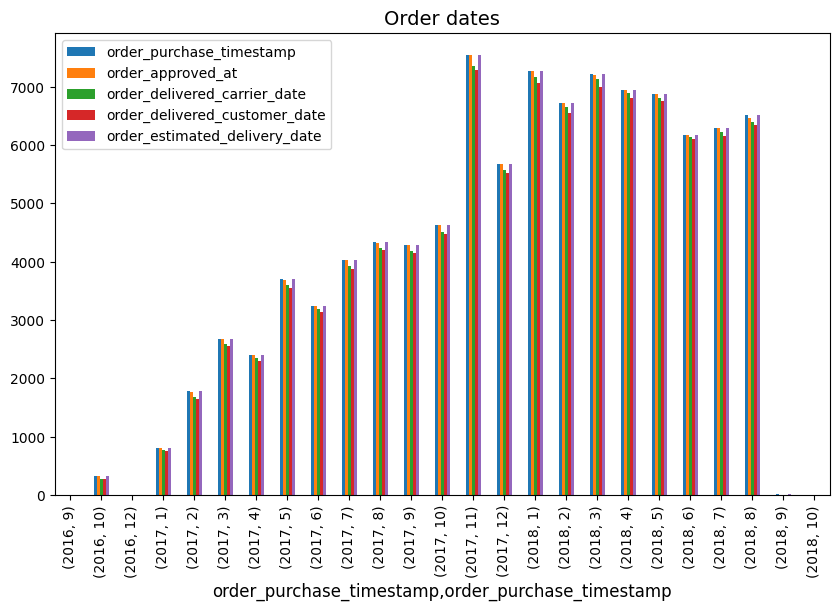

In [241]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
olist_orders_dataset[['order_purchase_timestamp',
                      'order_approved_at', 'order_delivered_carrier_date',
                      'order_delivered_customer_date', 'order_estimated_delivery_date']
                     ].groupby([olist_orders_dataset['order_purchase_timestamp'].dt.year,
                                olist_orders_dataset['order_purchase_timestamp'].dt.month]).count().plot(kind="bar")
plt.title("Order dates")

In [242]:
selected = olist_orders_dataset.loc[ (olist_orders_dataset['order_purchase_timestamp']<datetime.datetime(2017,1,1)) | \
                                     (olist_orders_dataset['order_purchase_timestamp']>=datetime.datetime(2018,9,1)) ]

In [243]:
selected.shape

(349, 8)

In [244]:
olist_orders_dataset.drop(selected.index, inplace=True)
olist_orders_dataset.shape

(99092, 8)

Vérification :

Text(0.5, 1.0, 'Order dates')

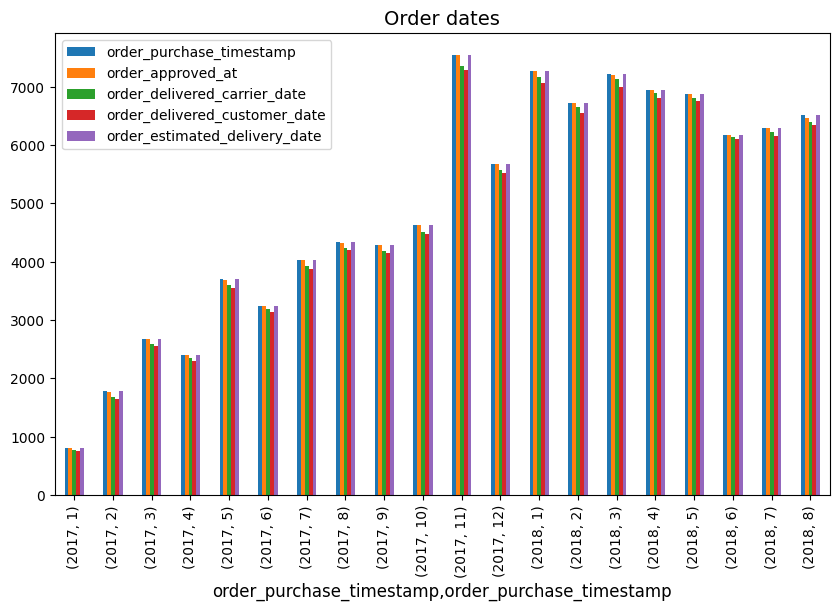

In [245]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
olist_orders_dataset[['order_purchase_timestamp',
                      'order_approved_at', 'order_delivered_carrier_date',
                      'order_delivered_customer_date', 'order_estimated_delivery_date']
                     ].groupby([olist_orders_dataset['order_purchase_timestamp'].dt.year,
                                olist_orders_dataset['order_purchase_timestamp'].dt.month]).count().plot(kind="bar")
plt.title("Order dates")

In [246]:
olist_order_items_dataset.shape

(112650, 7)

In [247]:
selected = olist_order_items_dataset.loc[ (olist_order_items_dataset['shipping_limit_date']<datetime.datetime(2017,1,1)) | \
                                          (olist_order_items_dataset['shipping_limit_date']>=datetime.datetime(2018,9,1)) ]

In [248]:
selected.shape

(473, 7)

In [249]:
olist_order_items_dataset.drop(selected.index, inplace=True)
olist_order_items_dataset.shape

(112177, 7)

Vérification :

Text(0.5, 1.0, 'Shipping limit dates')

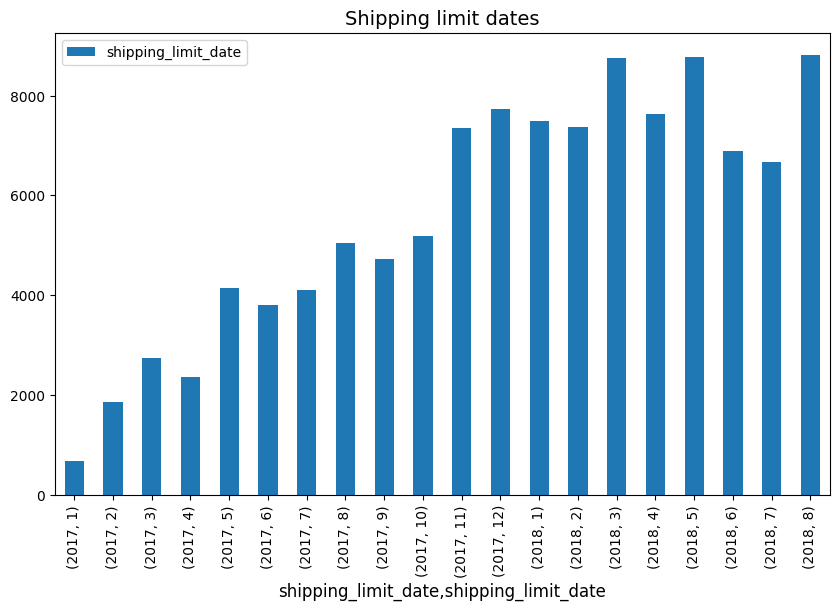

In [250]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
olist_order_items_dataset[['shipping_limit_date']].groupby(
    [olist_order_items_dataset['shipping_limit_date'].dt.year,
     olist_order_items_dataset['shipping_limit_date'].dt.month]
).count().plot(kind="bar")
plt.title("Shipping limit dates")

Dates de review : pour être sûr de ne capter aucun client ayant donné un avis *en dehors* de la période d'étude (01/01/2017, 31/08/2018), on supprime aussi les dates de review qui ne tombent pas dans cette période : 

In [251]:
olist_order_reviews_dataset.shape

(99224, 7)

In [252]:
selected = olist_order_reviews_dataset.loc[ (olist_order_reviews_dataset['review_creation_date']<datetime.datetime(2017,1,1)) | \
                                            (olist_order_reviews_dataset['review_creation_date']>=datetime.datetime(2018,9,1)) ]

In [253]:
selected.shape

(325, 7)

In [254]:
olist_order_reviews_dataset.drop(selected.index, inplace=True)
olist_order_reviews_dataset.shape

(98899, 7)

Vérification :

Text(0.5, 1.0, 'Review dates')

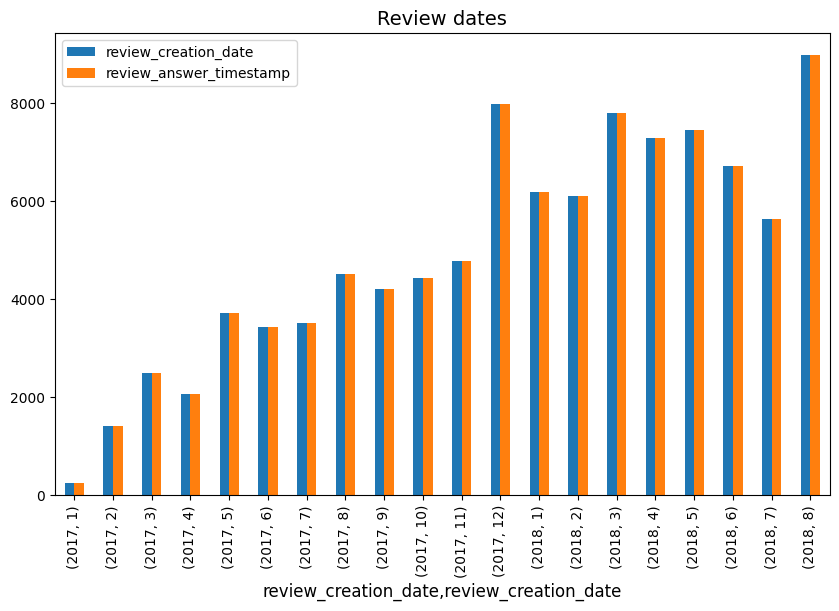

In [255]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
olist_order_reviews_dataset[['review_creation_date', 'review_answer_timestamp']].groupby(
    [olist_order_reviews_dataset['review_creation_date'].dt.year,
     olist_order_reviews_dataset['review_creation_date'].dt.month]
).count().plot(kind="bar")
plt.title("Review dates")

Suppression des paiements qui ont été fractionnés en 0 fois :

In [256]:
selected = olist_order_payments_dataset.loc[olist_order_payments_dataset['payment_installments']==0]
olist_order_payments_dataset.drop(selected.index, inplace=True)

Suppression des paiements dont le type n'est pas connu :

In [257]:
selected = olist_order_payments_dataset.loc[olist_order_payments_dataset['payment_type']=='not_defined']
olist_order_payments_dataset.drop(selected.index, inplace=True)

Suppression des commandes pas encore livrées, pour n'avoir que des commandes et avis complets.

In [258]:
olist_orders_dataset.shape

(99092, 8)

In [259]:
selected = olist_orders_dataset.loc[olist_orders_dataset['order_status']!='delivered']
selected.shape

(2881, 8)

In [260]:
olist_orders_dataset.drop(selected.index, inplace=True)
olist_orders_dataset.shape

(96211, 8)

### Imputations

Remplacement des `NaN` par `'other'` pour les catégories EN :

In [261]:
olist_products_dataset['product_category_name'].isna().sum()

610

Le faible taux de `NaN` sur les autres variables présentant un intérêt pour le problème nous amène à ne pas réaliser d'imputation.

## Regroupement de catégories

### Catégories de produits en catégories plus vastes

In [262]:
df_regroupement_categ = pd.read_csv(data_processed_dir+'regroupement_categ.csv', delimiter=';')

In [263]:
df_regroupement_categ

detailed_EN_categ        macro_EN_categ
0                agro_industry_and_commerce                 other
1                          air_conditioning                  home
2                                       art     culture_and_gifts
3                     arts_and_craftmanship     culture_and_gifts
4                                     audio                  tech
5                                      auto                  auto
6                                      baby  supplies_accessories
7                            bed_bath_table                  home
8                    books_general_interest     culture_and_gifts
9                            books_imported     culture_and_gifts
10                          books_technical     culture_and_gifts
11                        cds_dvds_musicals     culture_and_gifts
12                       christmas_supplies  supplies_accessories
13                               cine_photo     culture_and_gifts
14                                computers                  tech
15                    computers_accessories                  tech
16                           consoles_games                  tech
17          construction_tools_construction                 tools
18                construction_tools_lights                 tools
19                construction_tools_safety                 tools
20                               cool_stuff     culture_and_gifts
21                 costruction_tools_garden                 tools
22                  costruction_tools_tools                 tools
23                      diapers_and_hygiene  supplies_accessories
24                                   drinks            food_drink
25                             dvds_blu_ray                  tech
26                              electronics                  tech
27                   fashio_female_clothing                 cloth
28                 fashion_bags_accessories  supplies_accessories
29                fashion_childrens_clothes                 cloth
30                    fashion_male_clothing                 cloth
31                            fashion_shoes                 cloth
32                            fashion_sport                 cloth
33                  fashion_underwear_beach                 cloth
34                          fixed_telephony                  tech
35                                  flowers                  home
36                                     food            food_drink
37                               food_drink            food_drink
38                        furniture_bedroom                  home
39                          furniture_decor                  home
40                    furniture_living_room                  home
41        furniture_mattress_and_upholstery                  home
42                             garden_tools                 tools
43                            health_beauty         health_beauty
44                          home_appliances                  home
45                        home_appliances_2                  home
46                           home_comfort_2                  home
47                             home_confort                  home
48                        home_construction                 tools
49                               housewares  supplies_accessories
50           industry_commerce_and_business                 other
51  kitchen_dining_laundry_garden_furniture                  home
52                               la_cuisine                  home
53                      luggage_accessories  supplies_accessories
54                             market_place                 other
55                                    music     culture_and_gifts
56                      musical_instruments     culture_and_gifts
57                         office_furniture                  home
58                           party_supplies  supplies_accessories
59                                perfumery         health_beauty


In [264]:
df_regroupement_categ['detailed_EN_categ'].unique()

array(['agro_industry_and_commerce', 'air_conditioning', 'art',
       'arts_and_craftmanship', 'audio', 'auto', 'baby', 'bed_bath_table',
       'books_general_interest', 'books_imported', 'books_technical',
       'cds_dvds_musicals', 'christmas_supplies', 'cine_photo',
       'computers', 'computers_accessories', 'consoles_games',
       'construction_tools_construction', 'construction_tools_lights',
       'construction_tools_safety', 'cool_stuff',
       'costruction_tools_garden', 'costruction_tools_tools',
       'diapers_and_hygiene', 'drinks', 'dvds_blu_ray', 'electronics',
       'fashio_female_clothing', 'fashion_bags_accessories',
       'fashion_childrens_clothes', 'fashion_male_clothing',
       'fashion_shoes', 'fashion_sport', 'fashion_underwear_beach',
       'fixed_telephony', 'flowers', 'food', 'food_drink',
       'furniture_bedroom', 'furniture_decor', 'furniture_living_room',
       'furniture_mattress_and_upholstery', 'garden_tools',
       'health_beauty', 'home

### Etats en régions

Pour limiter le nombre de composantes indicatrices des états, on tente un regroupement de ceux-ci en **régions** :

<img src="Brazil-regions-states.jpg"/>

In [265]:
df_regroupement_states = pd.read_csv(data_processed_dir+'regroupement_states.csv', delimiter=';')

In [266]:
df_regroupement_states

customer_state customer_region
0              AC           north
1              AL       northeast
2              AM           north
3              AP           north
4              BA       northeast
5              CE       northeast
6              DF     center-west
7              ES       southeast
8              GO     center-west
9              MA       northeast
10             MG       southeast
11             MS     center-west
12             MT     center-west
13             PA           north
14             PB       northeast
15             PE       northeast
16             PI       northeast
17             PR           south
18             RJ       southeast
19             RN       northeast
20             RO           north
21             RR           north
22             RS           south
23             SC           south
24             SE       northeast
25             SP       southeast
26             TO           north

## Choix des informations pour la segmentation  

On s'intéresse à la base de clients, donc on part de la table `olist_customers_dataset` pour le merge d'informations.
Opérations à effectuer :
 - [X] agrégation du nombre d'achats total depuis le début de la période
 - [ ] agrégation du nombre d'achats par mois depuis le début de la période (non choisi) : attention à la dilution provoquée
 - [X] agrégation du montant d'achats total depuis le début de la période
 - [ ] agrégation du montant d'achats par mois depuis le début de la période (non choisi)
 - [X] nombre de produits par commande
 - [X] nombre de vendeurs par commande : pas intéressant 
 - [X] récupération de l'info "type de paiement" : `boleto` (billets), `voucher` sont des profils assez particuliers
 - [X] récupération de l'info "paiement toujours comptant/parfois fractionné"
 - [X] récupération de l'info "état" (ville sûrement trop dimensionnophage)
 - [X] récupération de l'info "catégorie de produit préférée n°1", voire n°2, voire n°3 (faire encore de la synthèse matricielle)
 - [X] récupération de l'info "note moyenne donnée" (toujours donnée, pas de NaN !)
 - [X] notion de "récence" de client/d'achat (penser "action marketting ciblée sur tels clients")

### Ajout de l'info `customer_unique_id` dans les tables

In [267]:
olist_orders_dataset

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp   order_approved_at  \
0        delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   
...            ...                      ...                 ...   
99436    delivered      2017-03-09 09:54:05 2017-03-09 09:54:05   
99437    delivered      2018-02-06 12:58:58 2018-02-06 13:10:37   
99438    delivered      2017-08-27 14:46:43 2017-08-27 15:04:16   
99439    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
99440    delivered      2018-03-08 20:57:30 2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99436          2017-03-10 11:18:03           2017-03-17 15:08:01   
99437          2018-02-07 23:22:42           2018-02-28 17:37:56   
99438          2017-08-28 20:52:26           2017-09-21 11:24:17   
99439          2018-01-12 15:35:03           2018-01-25 23:32:54   
99440          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  
0                        2017-10-18  
1                        2018-08-13  
2                        2018-09-04  
3                        2017-12-15  
4                        2018-02-26  
...                             ...  
99436                    2017-03-28  
99437                    2018-03-02  
99438                    2017-09-27  
99439                    2018-02-15  
99440                    2018-04-03  

[96211 rows x 8 columns]

In [268]:
olist_orders_dataset = olist_orders_dataset.merge(olist_customers_dataset[['customer_id', 'customer_unique_id']],
                                                  on='customer_id', how='inner')

Les autres tables ne contiennent pas d'information sur le client (`customer_id` ni `customer_unique_id`), mais l'info de la commande. On continue à propager `customer_unique_id` dans celles-ci :

In [269]:
olist_orders_dataset.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id'],
      dtype='object')

In [270]:
olist_order_items_dataset = olist_order_items_dataset.merge(olist_orders_dataset[['order_id', 'customer_unique_id']],
                                                            on='order_id', how='inner')

In [271]:
olist_order_items_dataset

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
109775  fffc94f6ce00a00581880bf54a75a037              1   
109776  fffcd46ef2263f404302a634eb57f7eb              1   
109777  fffce4705a9662cd70adb13d4a31832d              1   
109778  fffe18544ffabc95dfada21779c9644f              1   
109779  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
109775  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
109776  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
109777  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
109778  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
109779  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

       shipping_limit_date   price  freight_value  \
0      2017-09-19 09:45:35   58.90          13.29   
1      2017-05-03 11:05:13  239.90          19.93   
2      2018-01-18 14:48:30  199.00          17.87   
3      2018-08-15 10:10:18   12.99          12.79   
4      2017-02-13 13:57:51  199.90          18.14   
...                    ...     ...            ...   
109775 2018-05-02 04:11:01  299.99          43.41   
109776 2018-07-20 04:31:48  350.00          36.53   
109777 2017-10-30 17:14:25   99.90          16.95   
109778 2017-08-21 00:04:32   55.99           8.72   
109779 2018-06-12 17:10:13   43.00          12.79   

                      customer_unique_id  
0       871766c5855e863f6eccc05f988b23cb  
1       eb28e67c4c0b83846050ddfb8a35d051  
2       3818d81c6709e39d06b2738a8d3a2474  
3       af861d436cfc08b2c2ddefd0ba074622  
4       64b576fb70d441e8f1b2d7d446e483c5  
...                                  ...  
109775  0c9aeda10a71f369396d0c04dce13a64  
109776  0da9fe112eae0c74d3ba1fe16de0988b  
109777  cd79b407828f02fdbba457111c38e4c4  
109778  eb803377c9315b564bdedad672039306  
109779  cd76a00d8e3ca5e6ab9ed9ecb6667ac4  

[109780 rows x 8 columns]

In [272]:
olist_order_payments_dataset = olist_order_payments_dataset.merge(olist_orders_dataset[['order_id','customer_unique_id']],
                                                                  on='order_id', how='inner')

In [273]:
olist_order_reviews_dataset = olist_order_reviews_dataset.merge(olist_orders_dataset[['order_id','customer_unique_id']],
                                                                on='order_id', how='inner')

On reporte également la traduction des catégories avec `product_category_name_translation`, dans les commandes :

In [274]:
olist_products_dataset = olist_products_dataset.merge(
    product_category_name_translation[['product_category_name','product_category_name_english']],
    on='product_category_name', how='inner'
)

In [275]:
olist_products_dataset = pd.merge(olist_products_dataset, df_regroupement_categ[['detailed_EN_categ','macro_EN_categ']],
                                  left_on='product_category_name_english',
                                  right_on='detailed_EN_categ',
                                  how='inner')

In [276]:
olist_products_dataset['product_category_name_english'].isna().sum()

0

Ah, il manque des traductions.

In [277]:
olist_products_dataset.loc[olist_products_dataset['product_category_name_english'].isna(),'product_category_name_english'] = 'other'
olist_products_dataset.loc[olist_products_dataset['detailed_EN_categ'].isna(),'detailed_EN_categ'] = 'other'

In [278]:
olist_products_dataset['product_category_name_english'].isna().sum()

0

In [279]:
olist_products_dataset.head()

product_id product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5            perfumaria   
1  6a2fb4dd53d2cdb88e0432f1284a004c            perfumaria   
2  0d009643171aee696f4733340bc2fdd0            perfumaria   
3  b1eae565a61935e0011ee7682fef9dc9            perfumaria   
4  8da90b37f0fb171b4877c124f965b1f6            perfumaria   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 39.0                       346.0                 2.0   
2                 52.0                       150.0                 1.0   
3                 49.0                       460.0                 2.0   
4                 56.0                       733.0                 3.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             225.0               16.0               10.0              14.0   
1             400.0               27.0                5.0              20.0   
2             422.0               21.0               16.0              18.0   
3             267.0               17.0               13.0              17.0   
4             377.0               18.0               13.0              15.0   

  product_category_name_english detailed_EN_categ macro_EN_categ  
0                     perfumery         perfumery  health_beauty  
1                     perfumery         perfumery  health_beauty  
2                     perfumery         perfumery  health_beauty  
3                     perfumery         perfumery  health_beauty  
4                     perfumery         perfumery  health_beauty

In [280]:
olist_order_items_dataset = olist_order_items_dataset.merge(
    olist_products_dataset[['product_id', 'product_category_name_english', 'macro_EN_categ']],
    on='product_id', how='inner'
)

In [281]:
olist_order_items_dataset['product_category_name_english'].isna().sum()

0

In [282]:
olist_products_dataset['product_category_name_english'].isna().sum()

0

In [283]:
olist_products_dataset['macro_EN_categ'].isna().sum()

0

In [284]:
olist_order_items_dataset['shipping_limit_date'].isna().sum()

0

In [285]:
olist_products_dataset['macro_EN_categ'].value_counts().shape

(10,)

In [286]:
olist_order_payments_dataset['customer_unique_id'].isna().sum()

0

### Nombre d'achats total depuis le début de la période

In [287]:
df_cust_nb_orders = pd.DataFrame(
    olist_orders_dataset.groupby(['customer_unique_id'])['order_id'].count(),
    columns=['order_id']
).reset_index()

In [288]:
df_cust_nb_orders.rename({'order_id':'nb_orders'}, axis=1, inplace=True)
df_cust_nb_orders

customer_unique_id  nb_orders
0      0000366f3b9a7992bf8c76cfdf3221e2          1
1      0000b849f77a49e4a4ce2b2a4ca5be3f          1
2      0000f46a3911fa3c0805444483337064          1
3      0000f6ccb0745a6a4b88665a16c9f078          1
4      0004aac84e0df4da2b147fca70cf8255          1
...                                 ...        ...
93099  fffcf5a5ff07b0908bd4e2dbc735a684          1
93100  fffea47cd6d3cc0a88bd621562a9d061          1
93101  ffff371b4d645b6ecea244b27531430a          1
93102  ffff5962728ec6157033ef9805bacc48          1
93103  ffffd2657e2aad2907e67c3e9daecbeb          1

[93104 rows x 2 columns]

In [289]:
df_cust_nb_orders.loc[df_cust_nb_orders['nb_orders']>1]

customer_unique_id  nb_orders
103    004288347e5e88a27ded2bb23747066c          2
242    00a39521eb40f7012db50455bf083460          2
304    00cc12a6d8b578b8ebd21ea4e2ae8b27          2
403    011575986092c30523ecb71ff10cb473          2
418    011b4adcd54683b480c4d841250a987f          2
...                                 ...        ...
92741  ff03923ad1eb9e32304deb7f9b2a45c9          2
92835  ff44401d0d8f5b9c54a47374eb48c1b8          2
92934  ff8892f7c26aa0446da53d01b18df463          2
92952  ff922bdd6bafcdf99cb90d7f39cea5b3          3
93060  ffe254cc039740e17dd15a5305035928          2

[2789 rows x 2 columns]

In [294]:
df_cust_nb_orders.loc[df_cust_nb_orders['nb_orders']>1].shape[0] / df_cust_nb_orders.shape[0] * 100.

2.995574841037979

On retrouve bien les 3% de clients ayant commandé plus d'une fois de l'énoncé.

 ### Montant d'achats total depuis le début de la période

In [295]:
olist_orders_dataset.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff  
1                    2018-08-13  af07308b275d755c9edb36a90c618231  
2                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8  
3                    2017-12-15  7c142cf63193a1473d2e66489a9ae977  
4                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6

La table `olist_orders_dataset` ne contient pas les montants de commande ! On peut retrouver les montants payés par un client soit dans la table `olist_order_items_dataset` :

In [296]:
olist_order_items_dataset.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  130898c0987d1801452a8ed92a670612              1   
2  532ed5e14e24ae1f0d735b91524b98b9              1   
3  6f8c31653edb8c83e1a739408b5ff750              1   
4  7d19f4ef4d04461989632411b7e588b9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
2  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
3  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
4  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   

  shipping_limit_date  price  freight_value                customer_unique_id  \
0 2017-09-19 09:45:35   58.9          13.29  871766c5855e863f6eccc05f988b23cb   
1 2017-07-05 02:44:11   55.9          17.96  0fb8e3eab2d3e79d92bb3fffbb97f188   
2 2018-05-23 10:56:25   64.9          18.33  3419052c8c6b45daf79c1e426f9e9bcb   
3 2017-08-07 18:55:08   58.9          16.17  e7c828d22c0682c1565252deefbe334d   
4 2017-08-16 22:05:11   58.9          13.29  0bb98ba72dcc08e95f9d8cc434e9a2cc   

  product_category_name_english     macro_EN_categ  
0                    cool_stuff  culture_and_gifts  
1                    cool_stuff  culture_and_gifts  
2                    cool_stuff  culture_and_gifts  
3                    cool_stuff  culture_and_gifts  
4                    cool_stuff  culture_and_gifts

soit dans la table `olist_order_payments_dataset` :

In [297]:
olist_order_payments_dataset.head()

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value                customer_unique_id  
0                     8          99.33  708ab75d2a007f0564aedd11139c7708  
1                     1          24.39  a8b9d3a27068454b1c98cc67d4e31e6f  
2                     1          65.71  6f70c0b2f7552832ba46eb57b1c5651e  
3                     8         107.78  87695ed086ebd36f20404c82d20fca87  
4                     2         128.45  4291db0da71914754618cd789aebcd56

On se servira de la liste des items pour calculer le chiffre d'affaire issu des différents clients :

In [298]:
df_cust_total_amount = pd.DataFrame(
    olist_order_items_dataset.groupby(['customer_unique_id'])['price'].sum(),
    columns=['price']
).reset_index()

In [299]:
df_cust_total_amount.rename({'price':'total_amount'}, axis=1, inplace=True)

D'autre part, on remarque que cette nouvelle table de clients n'a pas exactement le même nombre d'entrées (95420) que la précédente (96096). On s'attend à obtenir des `NaN` au fur et à mesure des jointures (ou à perdre des entrées, selon la méthode de jointure).

### Nombre total et moyen de produits par commande

On compte d'abord le nombre total de produits commandés :

In [301]:
df_cust_nb_items = pd.DataFrame(olist_order_items_dataset.groupby(['customer_unique_id'])['product_id'].count(),
                                columns=['product_id']).reset_index()

In [302]:
df_cust_nb_items.rename({'product_id': 'nb_items'}, axis=1, inplace=True)

In [303]:
df_cust_nb_items['nb_items'].value_counts()

1     80388
2      8626
3      1603
4       607
5       235
6       184
7        45
8        15
9        11
10       10
11       10
12        9
14        4
15        2
20        2
13        2
18        1
21        1
24        1
Name: nb_items, dtype: int64

In [304]:
df_cust_nb_items.shape

(91756, 2)

In [305]:
df_cust_nb_orders.shape

(93104, 2)

In [306]:
df_cust_nb_items_mean = pd.merge(df_cust_nb_items, df_cust_nb_orders, how='inner',
                                 left_on='customer_unique_id',
                                 right_on='customer_unique_id')

In [307]:
df_cust_nb_items_mean

customer_unique_id  nb_items  nb_orders
0      0000366f3b9a7992bf8c76cfdf3221e2         1          1
1      0000b849f77a49e4a4ce2b2a4ca5be3f         1          1
2      0000f46a3911fa3c0805444483337064         1          1
3      0000f6ccb0745a6a4b88665a16c9f078         1          1
4      0004aac84e0df4da2b147fca70cf8255         1          1
...                                 ...       ...        ...
91751  fffcf5a5ff07b0908bd4e2dbc735a684         2          1
91752  fffea47cd6d3cc0a88bd621562a9d061         1          1
91753  ffff371b4d645b6ecea244b27531430a         1          1
91754  ffff5962728ec6157033ef9805bacc48         1          1
91755  ffffd2657e2aad2907e67c3e9daecbeb         1          1

[91756 rows x 3 columns]

In [308]:
df_cust_nb_items_mean['nb_items_mean'] = df_cust_nb_items_mean['nb_items']/df_cust_nb_items_mean['nb_orders']
df_cust_nb_items_mean

customer_unique_id  nb_items  nb_orders  nb_items_mean
0      0000366f3b9a7992bf8c76cfdf3221e2         1          1            1.0
1      0000b849f77a49e4a4ce2b2a4ca5be3f         1          1            1.0
2      0000f46a3911fa3c0805444483337064         1          1            1.0
3      0000f6ccb0745a6a4b88665a16c9f078         1          1            1.0
4      0004aac84e0df4da2b147fca70cf8255         1          1            1.0
...                                 ...       ...        ...            ...
91751  fffcf5a5ff07b0908bd4e2dbc735a684         2          1            2.0
91752  fffea47cd6d3cc0a88bd621562a9d061         1          1            1.0
91753  ffff371b4d645b6ecea244b27531430a         1          1            1.0
91754  ffff5962728ec6157033ef9805bacc48         1          1            1.0
91755  ffffd2657e2aad2907e67c3e9daecbeb         1          1            1.0

[91756 rows x 4 columns]

### Montant moyen par commande et par item

On a déjà le chiffre d'affaire total de chaque client, et son nombre total de commandes ainsi que d'items.

In [309]:
df_cust_mean_amount = pd.merge(df_cust_total_amount, df_cust_nb_orders, how='inner',
                                 left_on='customer_unique_id',
                                 right_on='customer_unique_id')
df_cust_mean_amount = pd.merge(df_cust_mean_amount, df_cust_nb_items, how='inner',
                                 left_on='customer_unique_id',
                                 right_on='customer_unique_id')

In [310]:
df_cust_mean_amount

customer_unique_id  total_amount  nb_orders  nb_items
0      0000366f3b9a7992bf8c76cfdf3221e2        129.90          1         1
1      0000b849f77a49e4a4ce2b2a4ca5be3f         18.90          1         1
2      0000f46a3911fa3c0805444483337064         69.00          1         1
3      0000f6ccb0745a6a4b88665a16c9f078         25.99          1         1
4      0004aac84e0df4da2b147fca70cf8255        180.00          1         1
...                                 ...           ...        ...       ...
91751  fffcf5a5ff07b0908bd4e2dbc735a684       1570.00          1         2
91752  fffea47cd6d3cc0a88bd621562a9d061         64.89          1         1
91753  ffff371b4d645b6ecea244b27531430a         89.90          1         1
91754  ffff5962728ec6157033ef9805bacc48        115.00          1         1
91755  ffffd2657e2aad2907e67c3e9daecbeb         56.99          1         1

[91756 rows x 4 columns]

In [311]:
df_cust_mean_amount['mean_amount_per_order'] = df_cust_mean_amount['total_amount']/df_cust_mean_amount['nb_orders']
df_cust_mean_amount['mean_amount_per_item']  = df_cust_mean_amount['total_amount']/df_cust_mean_amount['nb_items']
df_cust_mean_amount

customer_unique_id  total_amount  nb_orders  nb_items  \
0      0000366f3b9a7992bf8c76cfdf3221e2        129.90          1         1   
1      0000b849f77a49e4a4ce2b2a4ca5be3f         18.90          1         1   
2      0000f46a3911fa3c0805444483337064         69.00          1         1   
3      0000f6ccb0745a6a4b88665a16c9f078         25.99          1         1   
4      0004aac84e0df4da2b147fca70cf8255        180.00          1         1   
...                                 ...           ...        ...       ...   
91751  fffcf5a5ff07b0908bd4e2dbc735a684       1570.00          1         2   
91752  fffea47cd6d3cc0a88bd621562a9d061         64.89          1         1   
91753  ffff371b4d645b6ecea244b27531430a         89.90          1         1   
91754  ffff5962728ec6157033ef9805bacc48        115.00          1         1   
91755  ffffd2657e2aad2907e67c3e9daecbeb         56.99          1         1   

       mean_amount_per_order  mean_amount_per_item  
0                     129.90                129.90  
1                      18.90                 18.90  
2                      69.00                 69.00  
3                      25.99                 25.99  
4                     180.00                180.00  
...                      ...                   ...  
91751                1570.00                785.00  
91752                  64.89                 64.89  
91753                  89.90                 89.90  
91754                 115.00                115.00  
91755                  56.99                 56.99  

[91756 rows x 6 columns]

### Type de paiement

Le type de paiement (carte de débit, carte de crédit, ...) peut ne pas être le même d'une commande à l'autre, mais cela ne concerne que 3% des clients. On ne retiendra donc que le **dernier** type de paiement, pour les clients ayant commandé plusieurs fois.

Par contre, dans le cas d'utilisatiojn de coupon par exemple, le paiement peut être de **plusieurs types** pour une seule commande. Puisqu'il y a 4 types de paiement, et qu'on va encoder tous ces types (avec OneHotEncoder pour ne pas les hiérarchiser), autant les retenir tous pour un même clients, avec une matrice synthétique :
```
client | credit_cart | debit_card | voucher | boleto
f5c68e |     1       |      0     |    1    |   0   
 ...
5ab4c8 |     0       |      1     |    1    |   0   
```

In [312]:
olist_order_payments_dataset['payment_type'].value_counts()

credit_card    74374
boleto         19140
voucher         5473
debit_card      1484
Name: payment_type, dtype: int64

In [314]:
def report_payment_types(df, key, col):
    """Adds to a dataframe the matrix vision in indicator 0/1 multiples of one of its categorical variables.
    
    We defer to 1 each appearance of one of the categorical values of the col column in the added columns,
    to the key line key.
    
    Parameters
    ----------
    df: pandas.DataFrame
        Original data frame.
    key: str
        Column of df serving as key.
    collar: str
        Column of df to transform into a multiple 0/1 indicator matrix.
    
    Returns
    -------
    df2: pandas.DataFrame
        Enriched dataframe.
    """
    # Init
    df2 = pd.DataFrame(df[key].unique(), columns=[key])
    # We determine all the categorical values
    types = df[col].unique()
    # We add and initialize the different columns added to 0
    for typ in types:
        df2[typ] = 0
    # We browse the lines and report the categorical values in the columns of indicators
    for index in df.index:
        cust_id = df.loc[index, key]
        typ = df.loc[index,col]
        df2.loc[df2[key]==cust_id, typ] = 1
    return df2

In [318]:
if HAVE_TIME:
    df_cust_payment_type = report_payment_types(olist_order_payments_dataset, 'customer_unique_id', 'payment_type')
# executed in 26m 30s

Cette méthode basée sur `pandas` est beaucoup trop longue (26 min), on tente une autre approche :

In [319]:
encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')
encoder.fit(olist_order_payments_dataset[['payment_type']])
nda_payment = encoder.transform(olist_order_payments_dataset[['payment_type']])
df_payment = pd.DataFrame(olist_order_payments_dataset['customer_unique_id'])
payment_types = encoder.get_feature_names_out()
df_payment[encoder.get_feature_names_out()] = nda_payment
df_cust_payment_type = pd.DataFrame(
    df_payment.groupby(['customer_unique_id']).agg({pt:'sum' for pt in payment_types})
).reset_index()

In [320]:
df_cust_payment_type.head(10)

customer_unique_id  payment_type_boleto  \
0  0000366f3b9a7992bf8c76cfdf3221e2                  0.0   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                  0.0   
2  0000f46a3911fa3c0805444483337064                  0.0   
3  0000f6ccb0745a6a4b88665a16c9f078                  0.0   
4  0004aac84e0df4da2b147fca70cf8255                  0.0   
5  0004bd2a26a76fe21f786e4fbd80607f                  0.0   
6  00050ab1314c0e55a6ca13cf7181fecf                  1.0   
7  00053a61a98854899e70ed204dd4bafe                  0.0   
8  0005e1862207bf6ccc02e4228effd9a0                  0.0   
9  0005ef4cd20d2893f0d9fbd94d3c0d97                  0.0   

   payment_type_credit_card  payment_type_debit_card  payment_type_voucher  
0                       1.0                      0.0                   0.0  
1                       1.0                      0.0                   0.0  
2                       1.0                      0.0                   0.0  
3                       1.0                      0.0                   0.0  
4                       1.0                      0.0                   0.0  
5                       1.0                      0.0                   0.0  
6                       0.0                      0.0                   0.0  
7                       1.0                      0.0                   0.0  
8                       1.0                      0.0                   0.0  
9                       1.0                      0.0                   0.0

On vérifie qu'on a bien tous les types de paiements représentés :

In [321]:
for pt in payment_types:
    print(f"{pt}: {df_cust_payment_type[pt].sum()}")

payment_type_boleto: 19140.0
payment_type_credit_card: 74374.0
payment_type_debit_card: 1484.0
payment_type_voucher: 5473.0


On a même pu garder les paiements d'une même commande par **plusieurs types** :

In [322]:
df_cust_payment_type.loc[df_cust_payment_type[payment_types].sum(axis=1) > 1]

customer_unique_id  payment_type_boleto  \
19     000e309254ab1fc5ba99dd469d36bdb4                  0.0   
54     0028a7d8db7b0247652509358ad8d755                  0.0   
71     00324c9f4d710e7bac5c5ba679714430                  0.0   
103    004288347e5e88a27ded2bb23747066c                  0.0   
140    0058f300f57d7b93c477a131a59b36c3                  0.0   
...                                 ...                  ...   
92959  ff9584b796ae561b0085ebc998880a64                  0.0   
92967  ff9bc66daa6702543b16f3c4897e300b                  0.0   
92969  ff9c04f464ea62ad7787a0218336b942                  0.0   
93058  ffe254cc039740e17dd15a5305035928                  0.0   
93079  ffeddf8aa7cdecf403e77b2e9a99e2ea                  0.0   

       payment_type_credit_card  payment_type_debit_card  payment_type_voucher  
19                          1.0                      0.0                   1.0  
54                          1.0                      0.0                   1.0  
71                          1.0                      0.0                   1.0  
103                         2.0                      0.0                   0.0  
140                         0.0                      0.0                   2.0  
...                         ...                      ...                   ...  
92959                       1.0                      0.0                   1.0  
92967                       1.0                      0.0                   1.0  
92969                       1.0                      0.0                   1.0  
93058                       2.0                      0.0                   0.0  
93079                       1.0                      0.0                   1.0  

[5443 rows x 5 columns]

On garde la vision **catégorielle** de cette donnée, pour les études qui suivent (AFDM). Par contre, on garde le premier type, car le paiement en coupon (voucher) se fait en premier.

In [323]:
df_first_payment_type = olist_order_payments_dataset \
                            .sort_values(by='payment_sequential', ascending=False) \
                            .groupby(['customer_unique_id'])\
                            .agg('last')

df_cust_payment_type = pd.merge(df_cust_payment_type, df_first_payment_type,
                                how='inner',
                                left_on='customer_unique_id',
                                right_on='customer_unique_id')
df_cust_payment_type

customer_unique_id  payment_type_boleto  \
0      0000366f3b9a7992bf8c76cfdf3221e2                  0.0   
1      0000b849f77a49e4a4ce2b2a4ca5be3f                  0.0   
2      0000f46a3911fa3c0805444483337064                  0.0   
3      0000f6ccb0745a6a4b88665a16c9f078                  0.0   
4      0004aac84e0df4da2b147fca70cf8255                  0.0   
...                                 ...                  ...   
93097  fffcf5a5ff07b0908bd4e2dbc735a684                  0.0   
93098  fffea47cd6d3cc0a88bd621562a9d061                  0.0   
93099  ffff371b4d645b6ecea244b27531430a                  0.0   
93100  ffff5962728ec6157033ef9805bacc48                  0.0   
93101  ffffd2657e2aad2907e67c3e9daecbeb                  0.0   

       payment_type_credit_card  payment_type_debit_card  \
0                           1.0                      0.0   
1                           1.0                      0.0   
2                           1.0                      0.0   
3                           1.0                      0.0   
4                           1.0                      0.0   
...                         ...                      ...   
93097                       1.0                      0.0   
93098                       1.0                      0.0   
93099                       1.0                      0.0   
93100                       1.0                      0.0   
93101                       1.0                      0.0   

       payment_type_voucher                          order_id  \
0                       0.0  e22acc9c116caa3f2b7121bbb380d08e   
1                       0.0  3594e05a005ac4d06a72673270ef9ec9   
2                       0.0  b33ec3b699337181488304f362a6b734   
3                       0.0  41272756ecddd9a9ed0180413cc22fb6   
4                       0.0  d957021f1127559cd947b62533f484f7   
...                     ...                               ...   
93097                   0.0  725cf8e9c24e679a8a5a32cb92c9ce1e   
93098                   0.0  c71b9252fd7b3b263aaa4cb09319a323   
93099                   0.0  fdc45e6c7555e6cb3cc0daca2557dbe1   
93100                   0.0  94d3ee0bc2a0af9d4fa47a4d63616e8d   
93101                   0.0  f79a35da168301ae56922475da21117b   

       payment_sequential payment_type  payment_installments  payment_value  
0                       1  credit_card                     8         141.90  
1                       1  credit_card                     1          27.19  
2                       1  credit_card                     8          86.22  
3                       1  credit_card                     4          43.62  
4                       1  credit_card                     6         196.89  
...                   ...          ...                   ...            ...  
93097                   1  credit_card                    10        2067.42  
93098                   1  credit_card                     1          84.58  
93099                   1  credit_card                     1         112.46  
93100                   1  credit_card                     5         133.69  
93101                   1  credit_card                     4          71.56  

[93102 rows x 10 columns]

In [324]:
df_cust_payment_type.rename({'payment_type': 'first_payment_type'}, axis=1, inplace=True)

#### Fraction de paiement de chaque type

On introduit également la fraction qu'occupe chaque type de paiement, pour chaque client.

In [325]:
def payment_type_ratio(df_payments):
    """Calculates the overall ratios (in relation to the amount) of each type of payment, for each customer.
    
    Parameters
    ----------
    df_payments: pandas.DataFrame
        Contains orders, with customer information `customer_unique_id` of the type and amount of
        each payline.
        
    Returns
    -------
    df_payment_type_ratio: pandas.DataFrame
        Contains the different payment ratios, customer by customer
    
    payment_types_ratio_cols: list
        List of column names created.
    """
    # Determination of payment types
    types = list(df_payments['payment_type'].unique())
    # We force the order of the columns
    np_payments = df_payments[['customer_unique_id', 'payment_type', 'payment_value']].values
    cust_payment_dico = {}
    # We browse the dataset only one time
    for line in np_payments:
        customer = line[0]
        payment_type = line[1]
        payment_value = line[2]
        if customer not in cust_payment_dico:
            cust_payment_dico[customer] = {}
        if payment_type not in cust_payment_dico[customer]:
            cust_payment_dico[customer][payment_type] = 0.
        if 'total' not in cust_payment_dico[customer]:
            cust_payment_dico[customer]['total']      = 0.
        cust_payment_dico[customer][payment_type] += payment_value
        cust_payment_dico[customer]['total']      += payment_value
        pass

    # Compute the ratios
    data_pmt = []
    for cust in cust_payment_dico:
        line = [cust]
        for pt in types:
            if pt in cust_payment_dico[cust]:
                pv = cust_payment_dico[cust][pt] / cust_payment_dico[cust]['total']
            else:
                pv = 0.
            line.append(pv)
        data_pmt.append(line)
        pass
    # Make a new dataframe
    payment_types_ratio_cols = [pt+'_ratio' for pt in types]
    data_pmt = np.array(data_pmt)
    df_payment_type_ratio = pd.DataFrame(data_pmt, columns=['customer_unique_id']+payment_types_ratio_cols)
    df_payment_type_ratio[payment_types_ratio_cols] = df_payment_type_ratio[payment_types_ratio_cols].astype(float)
    return df_payment_type_ratio, payment_types_ratio_cols

In [326]:
df_cust_payment_type_ratio, payment_types_ratio_cols = payment_type_ratio(olist_order_payments_dataset)
# executed in 1.05s

Bien plus rapide (1.05s) !

In [327]:
payment_types_ratio_cols

['credit_card_ratio', 'boleto_ratio', 'voucher_ratio', 'debit_card_ratio']

In [328]:
df_cust_payment_type_ratio

customer_unique_id  credit_card_ratio  boleto_ratio  \
0      708ab75d2a007f0564aedd11139c7708                1.0           0.0   
1      a8b9d3a27068454b1c98cc67d4e31e6f                1.0           0.0   
2      6f70c0b2f7552832ba46eb57b1c5651e                1.0           0.0   
3      87695ed086ebd36f20404c82d20fca87                1.0           0.0   
4      4291db0da71914754618cd789aebcd56                1.0           0.0   
...                                 ...                ...           ...   
93097  18f40b803060d9883643b7e64e91628e                1.0           0.0   
93098  13f283df2f4760f22b57830865761d07                1.0           0.0   
93099  b6027ac07fb76ebca8c97b1887865aee                0.0           1.0   
93100  b84dc68f02f122a88d7e7bbd37b06204                1.0           0.0   
93101  b1f51a4e19da3338e51fbcfabefad1bf                0.0           1.0   

       voucher_ratio  debit_card_ratio  
0                0.0               0.0  
1                0.0               0.0  
2                0.0               0.0  
3                0.0               0.0  
4                0.0               0.0  
...              ...               ...  
93097            0.0               0.0  
93098            0.0               0.0  
93099            0.0               0.0  
93100            0.0               0.0  
93101            0.0               0.0  

[93102 rows x 5 columns]

#### Fusion du type `credit_card` et `debit_card`

On peut se demander si conserver les deux types de paiments par carte `credit_card` et `debit_card` introduit de la complexité, et si les fusionner permet d'améliorer la qualité du clustering, voire en réduire le nombre de clusters.

In [329]:
df_cust_payment_type_ratio['all_card_ratio'] = df_cust_payment_type_ratio['credit_card_ratio'] + df_cust_payment_type_ratio['debit_card_ratio']

In [330]:
payment_types_ratio_cols_all_cards = list(set(payment_types_ratio_cols)-set(['credit_card_ratio', 'debit_card_ratio'])) + ['all_card_ratio']
payment_types_ratio_cols_all_cards

['voucher_ratio', 'boleto_ratio', 'all_card_ratio']

 ### Paiement comptant/fractionné

Même remarque que précédemment : les modalités de paiment (comptant ou fractionné) peuvent ne pas être les mêmes d'une commande à l'autre, mais cela ne concerne que 3% des clients. On ne retiendra donc que le dernier type de modalités de paiement, pour les clients ayant commandé plusieurs fois.

In [331]:
# Get the split payments
df_payment_inst = pd.DataFrame(olist_order_payments_dataset[['customer_unique_id', 'payment_installments']])

# Payments in 1 installment are set to zero so that the sum remains at 0 for customers who never pay in several installments
df_payment_inst['payment_installments'] = df_payment_inst['payment_installments'] - 1

# We group the terms of payment by customer
df_cust_payment_inst = pd.DataFrame(df_payment_inst.groupby(['customer_unique_id'])['payment_installments'].sum()).reset_index()

# We only keep the info "the customer has already requested payment terms"
df_cust_payment_inst['payment_installments'] = df_cust_payment_inst['payment_installments'] + 1

On garde la variable catégorielle pour l'AFDM :

In [332]:
df_cust_payment_inst['payment_inst_cat'] = 'ONE'

In [333]:
df_cust_payment_inst.loc[df_cust_payment_inst['payment_installments']>1,'payment_inst_cat'] = 'SEVERAL'

In [334]:
df_cust_payment_inst.head(10)

customer_unique_id  payment_installments payment_inst_cat
0  0000366f3b9a7992bf8c76cfdf3221e2                     8          SEVERAL
1  0000b849f77a49e4a4ce2b2a4ca5be3f                     1              ONE
2  0000f46a3911fa3c0805444483337064                     8          SEVERAL
3  0000f6ccb0745a6a4b88665a16c9f078                     4          SEVERAL
4  0004aac84e0df4da2b147fca70cf8255                     6          SEVERAL
5  0004bd2a26a76fe21f786e4fbd80607f                     8          SEVERAL
6  00050ab1314c0e55a6ca13cf7181fecf                     1              ONE
7  00053a61a98854899e70ed204dd4bafe                     3          SEVERAL
8  0005e1862207bf6ccc02e4228effd9a0                     3          SEVERAL
9  0005ef4cd20d2893f0d9fbd94d3c0d97                     4          SEVERAL

In [335]:
df_cust_payment_inst['payment_installments'].sum()

278964

In [336]:
df_cust_payment_inst.shape

(93102, 3)

La moitié des clients a déjà demandé des modalités de paiement !

### Etat géographique

In [337]:
encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')
encoder.fit(olist_customers_dataset[['customer_state']])
nda_state = encoder.transform(olist_customers_dataset[['customer_state']])
df_cust_state = pd.DataFrame(olist_customers_dataset['customer_unique_id'])
states = encoder.get_feature_names_out()
df_cust_state[encoder.get_feature_names_out()] = nda_state

In [338]:
df_cust_state

customer_unique_id  customer_state_AC  customer_state_AL  \
0      861eff4711a542e4b93843c6dd7febb0                0.0                0.0   
1      290c77bc529b7ac935b93aa66c333dc3                0.0                0.0   
2      060e732b5b29e8181a18229c7b0b2b5e                0.0                0.0   
3      259dac757896d24d7702b9acbbff3f3c                0.0                0.0   
4      345ecd01c38d18a9036ed96c73b8d066                0.0                0.0   
...                                 ...                ...                ...   
99436  1a29b476fee25c95fbafc67c5ac95cf8                0.0                0.0   
99437  d52a67c98be1cf6a5c84435bd38d095d                0.0                0.0   
99438  e9f50caf99f032f0bf3c55141f019d99                0.0                0.0   
99439  73c2643a0a458b49f58cea58833b192e                0.0                0.0   
99440  84732c5050c01db9b23e19ba39899398                0.0                0.0   

       customer_state_AM  customer_state_AP  customer_state_BA  \
0                    0.0                0.0                0.0   
1                    0.0                0.0                0.0   
2                    0.0                0.0                0.0   
3                    0.0                0.0                0.0   
4                    0.0                0.0                0.0   
...                  ...                ...                ...   
99436                0.0                0.0                0.0   
99437                0.0                0.0                0.0   
99438                0.0                0.0                0.0   
99439                0.0                0.0                0.0   
99440                0.0                0.0                0.0   

       customer_state_CE  customer_state_DF  customer_state_ES  \
0                    0.0                0.0                0.0   
1                    0.0                0.0                0.0   
2                    0.0                0.0                0.0   
3                    0.0                0.0                0.0   
4                    0.0                0.0                0.0   
...                  ...                ...                ...   
99436                0.0                0.0                0.0   
99437                0.0                0.0                0.0   
99438                1.0                0.0                0.0   
99439                0.0                0.0                0.0   
99440                0.0                0.0                0.0   

       customer_state_GO  customer_state_MA  customer_state_MG  \
0                    0.0                0.0                0.0   
1                    0.0                0.0                0.0   
2                    0.0                0.0                0.0   
3                    0.0                0.0                0.0   
4                    0.0                0.0                0.0   
...                  ...                ...                ...   
99436                0.0                0.0                0.0   
99437                0.0                0.0                0.0   
99438                0.0                0.0                0.0   
99439                0.0                0.0                0.0   
99440                0.0                0.0                0.0   

       customer_state_MS  customer_state_MT  customer_state_PA  \
0                    0.0                0.0                0.0   
1                    0.0                0.0                0.0   
2                    0.0                0.0                0.0   
3                    0.0                0.0                0.0   
4                    0.0                0.0                0.0   
...                  ...                ...                ...   
99436                0.0                0.0                0.0   
99437                0.0                0.0                0.0   
99438                0.0                0.0                0.0   
99439    

Cette table n'a pas été agrégée, possède-t-elle des doublons ?

In [339]:
df_cust_state.loc[df_cust_state['customer_unique_id'].duplicated(keep='last'), :]

customer_unique_id  customer_state_AC  customer_state_AL  \
5      4c93744516667ad3b8f1fb645a3116a4                0.0                0.0   
8      1175e95fb47ddff9de6b2b06188f7e0d                0.0                0.0   
13     295c05e81917928d76245e842748184d                0.0                0.0   
32     e9dd12dca17352644a959d9dea133935                0.0                0.0   
33     e079b18794454de9d2be5c12b4392294                0.0                0.0   
...                                 ...                ...                ...   
96097  88fcb680dc8cd2e540010c0750b78242                0.0                0.0   
96548  2dcbfb99d95c7ba6eb992a98627f45b8                0.0                0.0   
96583  23339103d82a054f9729b0554ce22e8c                0.0                0.0   
97034  12f5d6e1cbf93dafd9dcc19095df0b3d                0.0                0.0   
97885  da29b8a3970adddb9ed2dc8a492065af                0.0                0.0   

       customer_state_AM  customer_state_AP  customer_state_BA  \
5                    0.0                0.0                0.0   
8                    0.0                0.0                0.0   
13                   0.0                0.0                0.0   
32                   0.0                0.0                1.0   
33                   0.0                0.0                0.0   
...                  ...                ...                ...   
96097                0.0                0.0                0.0   
96548                0.0                0.0                0.0   
96583                0.0                0.0                0.0   
97034                0.0                0.0                0.0   
97885                0.0                0.0                0.0   

       customer_state_CE  customer_state_DF  customer_state_ES  \
5                    0.0                0.0                0.0   
8                    0.0                0.0                0.0   
13                   0.0                0.0                0.0   
32                   0.0                0.0                0.0   
33                   0.0                0.0                0.0   
...                  ...                ...                ...   
96097                0.0                0.0                0.0   
96548                0.0                0.0                0.0   
96583                0.0                0.0                0.0   
97034                0.0                0.0                0.0   
97885                0.0                0.0                1.0   

       customer_state_GO  customer_state_MA  customer_state_MG  \
5                    0.0                0.0                0.0   
8                    0.0                0.0                0.0   
13                   0.0                0.0                0.0   
32                   0.0                0.0                0.0   
33                   0.0                0.0                0.0   
...                  ...                ...                ...   
96097                0.0                0.0                0.0   
96548                0.0                0.0                0.0   
96583                0.0                0.0                0.0   
97034                0.0                0.0                0.0   
97885                0.0                0.0                0.0   

       customer_state_MS  customer_state_MT  customer_state_PA  \
5                    0.0                0.0                0.0   
8                    0.0                0.0                0.0   
13                   0.0                0.0                0.0   
32                   0.0                0.0                0.0   
33                   0.0                0.0                0.0   
...                  ...                ...                ...   
96097                0.0                0.0                0.0   
96548                0.0                0.0                0.0   
96583                0.0                0.0                0.0   
97034    

Oui, on a bien fait de les répérer. Suprimons-les :

In [340]:
df_cust_state.drop_duplicates(subset=['customer_unique_id'], inplace=True)

On garde la vision **catégorielle** de ces données géographiques, pour les études qui suivent (AFDM). On garde le dernier état/région rencontré.

In [341]:
df_region_cat = olist_customers_dataset \
                            .groupby(['customer_unique_id']) \
                            .agg('last') \
                            .reset_index()

df_cust_state = pd.merge(df_cust_state, df_region_cat[['customer_unique_id', 'customer_state']],
                                how='inner',
                                left_on='customer_unique_id',
                                right_on='customer_unique_id')
df_cust_state

customer_unique_id  customer_state_AC  customer_state_AL  \
0      861eff4711a542e4b93843c6dd7febb0                0.0                0.0   
1      290c77bc529b7ac935b93aa66c333dc3                0.0                0.0   
2      060e732b5b29e8181a18229c7b0b2b5e                0.0                0.0   
3      259dac757896d24d7702b9acbbff3f3c                0.0                0.0   
4      345ecd01c38d18a9036ed96c73b8d066                0.0                0.0   
...                                 ...                ...                ...   
96091  1a29b476fee25c95fbafc67c5ac95cf8                0.0                0.0   
96092  d52a67c98be1cf6a5c84435bd38d095d                0.0                0.0   
96093  e9f50caf99f032f0bf3c55141f019d99                0.0                0.0   
96094  73c2643a0a458b49f58cea58833b192e                0.0                0.0   
96095  84732c5050c01db9b23e19ba39899398                0.0                0.0   

       customer_state_AM  customer_state_AP  customer_state_BA  \
0                    0.0                0.0                0.0   
1                    0.0                0.0                0.0   
2                    0.0                0.0                0.0   
3                    0.0                0.0                0.0   
4                    0.0                0.0                0.0   
...                  ...                ...                ...   
96091                0.0                0.0                0.0   
96092                0.0                0.0                0.0   
96093                0.0                0.0                0.0   
96094                0.0                0.0                0.0   
96095                0.0                0.0                0.0   

       customer_state_CE  customer_state_DF  customer_state_ES  \
0                    0.0                0.0                0.0   
1                    0.0                0.0                0.0   
2                    0.0                0.0                0.0   
3                    0.0                0.0                0.0   
4                    0.0                0.0                0.0   
...                  ...                ...                ...   
96091                0.0                0.0                0.0   
96092                0.0                0.0                0.0   
96093                1.0                0.0                0.0   
96094                0.0                0.0                0.0   
96095                0.0                0.0                0.0   

       customer_state_GO  customer_state_MA  customer_state_MG  \
0                    0.0                0.0                0.0   
1                    0.0                0.0                0.0   
2                    0.0                0.0                0.0   
3                    0.0                0.0                0.0   
4                    0.0                0.0                0.0   
...                  ...                ...                ...   
96091                0.0                0.0                0.0   
96092                0.0                0.0                0.0   
96093                0.0                0.0                0.0   
96094                0.0                0.0                0.0   
96095                0.0                0.0                0.0   

       customer_state_MS  customer_state_MT  customer_state_PA  \
0                    0.0                0.0                0.0   
1                    0.0                0.0                0.0   
2                    0.0                0.0                0.0   
3                    0.0                0.0                0.0   
4                    0.0                0.0                0.0   
...                  ...                ...                ...   
96091                0.0                0.0                0.0   
96092                0.0                0.0                0.0   
96093                0.0                0.0                0.0   
96094    

### Région géographique

On propage les régions de chaque état :

In [342]:
olist_customers_dataset = pd.merge(
    olist_customers_dataset, df_regroupement_states,
    how='inner',
    left_on='customer_state',
    right_on='customer_state'
)

In [343]:
encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')
encoder.fit(olist_customers_dataset[['customer_region']])
nda_region = encoder.transform(olist_customers_dataset[['customer_region']])
df_cust_region = pd.DataFrame(olist_customers_dataset['customer_unique_id'])
regions = encoder.get_feature_names_out()
df_cust_region[encoder.get_feature_names_out()] = nda_region

In [344]:
df_cust_region

customer_unique_id  customer_region_center-west  \
0      861eff4711a542e4b93843c6dd7febb0                          0.0   
1      290c77bc529b7ac935b93aa66c333dc3                          0.0   
2      060e732b5b29e8181a18229c7b0b2b5e                          0.0   
3      259dac757896d24d7702b9acbbff3f3c                          0.0   
4      345ecd01c38d18a9036ed96c73b8d066                          0.0   
...                                 ...                          ...   
99436  f48841d7d5532186af64171b32e23531                          0.0   
99437  fc6edb96180128815a10afb2297bf552                          0.0   
99438  2be29c188d2c5552046469c6c7e03061                          0.0   
99439  15b2459300f0b85b233d798c23552cee                          0.0   
99440  858ec48dbaddd52e729e8acdc8d2d108                          0.0   

       customer_region_north  customer_region_northeast  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   
...                      ...                        ...   
99436                    1.0                        0.0   
99437                    1.0                        0.0   
99438                    1.0                        0.0   
99439                    1.0                        0.0   
99440                    1.0                        0.0   

       customer_region_south  customer_region_southeast  
0                        0.0                        1.0  
1                        0.0                        1.0  
2                        0.0                        1.0  
3                        0.0                        1.0  
4                        0.0                        1.0  
...                      ...                        ...  
99436                    0.0                        0.0  
99437                    0.0                        0.0  
99438                    0.0                        0.0  
99439                    0.0                        0.0  
99440                    0.0                        0.0  

[99441 rows x 6 columns]

De même que pour les états, cette table n'a pas été agrégée, elle possède des doublons :

In [345]:
df_cust_region.loc[df_cust_region['customer_unique_id'].duplicated(keep='last'), :]

customer_unique_id  customer_region_center-west  \
7      295c05e81917928d76245e842748184d                          0.0   
21     c9158d089637ab443c78984d20da7fc0                          0.0   
40     7a380cb5434e6b6b5b37d45bb99dbe8a                          0.0   
53     13ac6da47fef1b17b16f511e03b57918                          0.0   
59     b6c083700ca8c135ba9f0f132930d4e8                          0.0   
...                                 ...                          ...   
99204  22f6af8201369f9eb96592db3142b9c2                          0.0   
99210  7263bdaf8bd8ca9e023f521f8ae50970                          0.0   
99220  0f0e48a91c9c285404572b095bcb373c                          0.0   
99291  ad7072317d373de9bdc9b4ed5b6c5a85                          0.0   
99395  7d0983269f825d3112e5a64364b1258a                          0.0   

       customer_region_north  customer_region_northeast  \
7                        0.0                        0.0   
21                       0.0                        0.0   
40                       0.0                        0.0   
53                       0.0                        0.0   
59                       0.0                        0.0   
...                      ...                        ...   
99204                    0.0                        1.0   
99210                    0.0                        1.0   
99220                    0.0                        1.0   
99291                    0.0                        1.0   
99395                    1.0                        0.0   

       customer_region_south  customer_region_southeast  
7                        0.0                        1.0  
21                       0.0                        1.0  
40                       0.0                        1.0  
53                       0.0                        1.0  
59                       0.0                        1.0  
...                      ...                        ...  
99204                    0.0                        0.0  
99210                    0.0                        0.0  
99220                    0.0                        0.0  
99291                    0.0                        0.0  
99395                    0.0                        0.0  

[3345 rows x 6 columns]

Supprimons-les :

In [346]:
df_cust_region.drop_duplicates(subset=['customer_unique_id'], inplace=True)

On garde la vision **catégorielle** de ces données géographiques, pour les études qui suivent (AFDM). On garde le dernier état/région rencontré.

In [347]:
df_region_cat = olist_customers_dataset \
                            .groupby(['customer_unique_id']) \
                            .agg('last') \
                            .reset_index()

df_cust_region = pd.merge(df_cust_region, df_region_cat[['customer_unique_id', 'customer_region']],
                                how='inner',
                                left_on='customer_unique_id',
                                right_on='customer_unique_id')
df_cust_region

customer_unique_id  customer_region_center-west  \
0      861eff4711a542e4b93843c6dd7febb0                          0.0   
1      290c77bc529b7ac935b93aa66c333dc3                          0.0   
2      060e732b5b29e8181a18229c7b0b2b5e                          0.0   
3      259dac757896d24d7702b9acbbff3f3c                          0.0   
4      345ecd01c38d18a9036ed96c73b8d066                          0.0   
...                                 ...                          ...   
96091  f48841d7d5532186af64171b32e23531                          0.0   
96092  fc6edb96180128815a10afb2297bf552                          0.0   
96093  2be29c188d2c5552046469c6c7e03061                          0.0   
96094  15b2459300f0b85b233d798c23552cee                          0.0   
96095  858ec48dbaddd52e729e8acdc8d2d108                          0.0   

       customer_region_north  customer_region_northeast  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   
...                      ...                        ...   
96091                    1.0                        0.0   
96092                    1.0                        0.0   
96093                    1.0                        0.0   
96094                    1.0                        0.0   
96095                    1.0                        0.0   

       customer_region_south  customer_region_southeast customer_region  
0                        0.0                        1.0       southeast  
1                        0.0                        1.0       southeast  
2                        0.0                        1.0       southeast  
3                        0.0                        1.0       southeast  
4                        0.0                        1.0       southeast  
...                      ...                        ...             ...  
96091                    0.0                        0.0           north  
96092                    0.0                        0.0           north  
96093                    0.0                        0.0           north  
96094                    0.0                        0.0           north  
96095                    0.0                        0.0           north  

[96096 rows x 7 columns]

### Coordonnées GPS de la ville des clients

In [348]:
df_cust_geoloc = pd.DataFrame(olist_customers_dataset[['customer_unique_id', 'customer_zip_code_prefix']])
df_cust_geoloc

customer_unique_id  customer_zip_code_prefix
0      861eff4711a542e4b93843c6dd7febb0                     14409
1      290c77bc529b7ac935b93aa66c333dc3                      9790
2      060e732b5b29e8181a18229c7b0b2b5e                      1151
3      259dac757896d24d7702b9acbbff3f3c                      8775
4      345ecd01c38d18a9036ed96c73b8d066                     13056
...                                 ...                       ...
99436  f48841d7d5532186af64171b32e23531                     69303
99437  fc6edb96180128815a10afb2297bf552                     69313
99438  2be29c188d2c5552046469c6c7e03061                     69311
99439  15b2459300f0b85b233d798c23552cee                     69301
99440  858ec48dbaddd52e729e8acdc8d2d108                     69313

[99441 rows x 2 columns]

In [349]:
olist_geolocation_dataset = olist_geolocation_dataset.groupby(['geolocation_zip_code_prefix']).agg('last').reset_index()

In [350]:
olist_geolocation_dataset

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                             1001       -23.549292       -46.633559   
1                             1002       -23.548551       -46.635072   
2                             1003       -23.548901       -46.637157   
3                             1004       -23.549530       -46.634628   
4                             1005       -23.549471       -46.637404   
...                            ...              ...              ...   
19010                        99960       -27.954114       -52.016483   
19011                        99965       -28.180655       -52.034367   
19012                        99970       -28.343273       -51.873734   
19013                        99980       -28.388932       -51.846871   
19014                        99990       -28.329472       -51.769109   

      geolocation_city geolocation_state  
0            sao paulo                SP  
1            sao paulo                SP  
2            sao paulo                SP  
3            sao paulo                SP  
4            sao paulo                SP  
...                ...               ...  
19010          charrua                RS  
19011       agua santa                RS  
19012          ciriaco                RS  
19013  david canabarro                RS  
19014        muliterno                RS  

[19015 rows x 5 columns]

In [351]:
df_cust_geoloc = pd.merge(df_cust_geoloc, olist_geolocation_dataset[['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']],
                          how='inner',
                          left_on='customer_zip_code_prefix',
                          right_on='geolocation_zip_code_prefix')
df_cust_geoloc

customer_unique_id  customer_zip_code_prefix  \
0      861eff4711a542e4b93843c6dd7febb0                     14409   
1      2761fee7f378f0a8d7682d8a3fa07ab1                     14409   
2      d06a495406b79cb8203ea21cc0942f8c                     14409   
3      8b3d988f330c1d1c3332ccd440c147b7                     14409   
4      866755e25db620f8d7e81b351a15bb2f                     14409   
...                                 ...                       ...   
99158  9b1c9c3315e0c6f2ceb5da19d67f1baa                     69308   
99159  cced18dc0d1f0d8b16f75f5b5ec3e2fe                     69304   
99160  1ee5b0e26a2fbd9a4c52d1137e55ff9d                     69380   
99161  a7dde49a1e77e409fae17b945a82e2b6                     69316   
99162  2be29c188d2c5552046469c6c7e03061                     69311   

       geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  
0                            14409       -20.500253       -47.400367  
1                            14409       -20.500253       -47.400367  
2                            14409       -20.500253       -47.400367  
3                            14409       -20.500253       -47.400367  
4                            14409       -20.500253       -47.400367  
...                            ...              ...              ...  
99158                        69308         2.796386       -60.686419  
99159                        69304         2.822611       -60.687891  
99160                        69380         3.361347       -59.836636  
99161                        69316         2.765127       -60.735404  
99162                        69311         2.846005       -60.710188  

[99163 rows x 5 columns]

 ### Catégorie de produits commandés

On exploite le OneHotEncoding avec la liste des achats d'items, dont on récupère la catégorie :

In [352]:
encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')
encoder.fit(olist_order_items_dataset[['product_category_name_english']])
nda_prod_categ = encoder.transform(olist_order_items_dataset[['product_category_name_english']])
prod_categs = encoder.get_feature_names_out()

In [353]:
olist_products_dataset

product_id      product_category_name  \
0      1e9e8ef04dbcff4541ed26657ea517e5                 perfumaria   
1      6a2fb4dd53d2cdb88e0432f1284a004c                 perfumaria   
2      0d009643171aee696f4733340bc2fdd0                 perfumaria   
3      b1eae565a61935e0011ee7682fef9dc9                 perfumaria   
4      8da90b37f0fb171b4877c124f965b1f6                 perfumaria   
...                                 ...                        ...   
32323  13b25797ad1e6d6c7cd3cbeb35f8ee7a  moveis_colchao_e_estofado   
32324  dc36a7859b743d8610a2bbbaea26ece9  moveis_colchao_e_estofado   
32325  107fde0930956120d1e13dd1062fbb46  moveis_colchao_e_estofado   
32326  726b4e18f00255e2e63491bcba3f60b8  moveis_colchao_e_estofado   
32327  1dceebcc5f23c02ea23e16d5bedca000          cds_dvds_musicais   

       product_name_lenght  product_description_lenght  product_photos_qty  \
0                     40.0                       287.0                 1.0   
1                     39.0                       346.0                 2.0   
2                     52.0                       150.0                 1.0   
3                     49.0                       460.0                 2.0   
4                     56.0                       733.0                 3.0   
...                    ...                         ...                 ...   
32323                 44.0                       348.0                 1.0   
32324                 29.0                      2073.0                 2.0   
32325                 51.0                       418.0                 1.0   
32326                 41.0                       866.0                 1.0   
32327                 47.0                       117.0                 2.0   

       product_weight_g  product_length_cm  product_height_cm  \
0                 225.0               16.0               10.0   
1                 400.0               27.0                5.0   
2                 422.0               21.0               16.0   
3                 267.0               17.0               13.0   
4                 377.0               18.0               13.0   
...                 ...                ...                ...   
32323           18250.0               25.0               25.0   
32324            2500.0               41.0               21.0   
32325           30000.0               60.0               73.0   
32326            1700.0               70.0               10.0   
32327             550.0               35.0               15.0   

       product_width_cm      product_category_name_english  \
0                  14.0                          perfumery   
1                  20.0                          perfumery   
2                  18.0                          perfumery   
3                  17.0                          perfumery   
4                  15.0                          perfumery   
...                 ...                                ...   
32323              25.0  furniture_mattress_and_upholstery   
32324              21.0  furniture_mattress_and_upholstery   
32325              60.0  furniture_mattress_and_upholstery   
32326             100.0  furniture_mattress_and_upholstery   
32327              25.0                  cds_dvds_musicals   

                       detailed_EN_categ     macro_EN_categ  
0                              perfumery      health_beauty  
1                              perfumery      health_beauty  
2                              perfumery      health_beauty  
3                              perfumery      health_beauty  
4                              perfumery      health_beauty  
...                                  ...                ...  
32323  furniture_mattress_and_upholstery               home  
32324  furniture_mattress_and_upholstery               home  
32325  furniture_mattress_and_upholstery               home  
32326  furniture_mattress_and_upholstery               home  
32327                  cds_dvds_musicals  c

In [354]:
olist_products_dataset['product_category_name_english'].isna().sum()

0

In [355]:
olist_products_dataset['macro_EN_categ'].isna().sum()

0

In [356]:
olist_order_items_dataset['macro_EN_categ'].isna().sum()

0

In [357]:
olist_order_items_dataset['product_category_name_english'].isna().sum()

0

In [358]:
encoder_macro = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder_macro.fit(olist_order_items_dataset[['macro_EN_categ']])
nda_prod_categ_macro = encoder_macro.transform(olist_order_items_dataset[['macro_EN_categ']])
prod_categs_macro = encoder_macro.get_feature_names_out()

In [359]:
# We create a dataset with the categories in OneHot, per customer, but not yet unique
df_prod_categ_macro = pd.DataFrame(olist_order_items_dataset['customer_unique_id'])
df_prod_categ_macro[encoder_macro.get_feature_names_out()] = nda_prod_categ_macro

In [360]:
# We sum the number of products in each category, this will simply define the favorite categories 
# of each customer, in OneHot version!
df_cust_prod_categ_macro = pd.DataFrame(df_prod_categ_macro.groupby(['customer_unique_id']).agg({pt:'sum' for pt in prod_categs_macro})).reset_index()

In [361]:
df_prod_categ_macro

customer_unique_id  macro_EN_categ_auto  \
0       871766c5855e863f6eccc05f988b23cb                  0.0   
1       0fb8e3eab2d3e79d92bb3fffbb97f188                  0.0   
2       3419052c8c6b45daf79c1e426f9e9bcb                  0.0   
3       e7c828d22c0682c1565252deefbe334d                  0.0   
4       0bb98ba72dcc08e95f9d8cc434e9a2cc                  0.0   
...                                  ...                  ...   
108218  a1c2e4b4c1b29e41684ebdf3cc6538f8                  0.0   
108219  4e15fee963523774998876e3624952f4                  0.0   
108220  c86ab5ff2bac777c4e770a383feca4eb                  0.0   
108221  2a3ab9bf9639491997586882c502540a                  0.0   
108222  cd76a00d8e3ca5e6ab9ed9ecb6667ac4                  0.0   

        macro_EN_categ_cloth  macro_EN_categ_culture_and_gifts  \
0                        0.0                               1.0   
1                        0.0                               1.0   
2                        0.0                               1.0   
3                        0.0                               1.0   
4                        0.0                               1.0   
...                      ...                               ...   
108218                   0.0                               0.0   
108219                   0.0                               0.0   
108220                   0.0                               1.0   
108221                   0.0                               0.0   
108222                   0.0                               0.0   

        macro_EN_categ_food_drink  macro_EN_categ_health_beauty  \
0                             0.0                           0.0   
1                             0.0                           0.0   
2                             0.0                           0.0   
3                             0.0                           0.0   
4                             0.0                           0.0   
...                           ...                           ...   
108218                        0.0                           0.0   
108219                        0.0                           0.0   
108220                        0.0                           0.0   
108221                        0.0                           0.0   
108222                        0.0                           0.0   

        macro_EN_categ_home  macro_EN_categ_other  \
0                       0.0                   0.0   
1                       0.0                   0.0   
2                       0.0                   0.0   
3                       0.0                   0.0   
4                       0.0                   0.0   
...                     ...                   ...   
108218                  0.0                   0.0   
108219                  1.0                   0.0   
108220                  0.0                   0.0   
108221                  0.0                   0.0   
108222                  1.0                   0.0   

        macro_EN_categ_supplies_accessories  macro_EN_categ_tech  \
0                                       0.0                  0.0   
1                                       0.0                  0.0   
2                                       0.0                  0.0   
3                                       0.0                  0.0   
4                                       0.0                  0.0   
...                                     ...                  ...   
108218                                  0.0                  0.0   
108219                                  0.0                  0.0   
108220                                  0.0                  0.0   
108221                                  1.0                  0.0   
108222                                  0.0                  0.0   

        macro_EN_categ_tools  
0                        0.0  
1                        0.0  
2                        0.0  
3                        0.0  
4                        0.0  
...

In [362]:
olist_order_items_dataset['product_category_name_english'].isna().sum()

0

In [364]:
# We also create the categorical version of the products purchased by each customer. The aggregation unfortunately loses 
# the number of articles
df_last_ordered_categ = olist_order_items_dataset.sort_values(
    by='shipping_limit_date', ascending=True).groupby(['customer_unique_id']).agg('last')

In [365]:
df_last_ordered_categ['product_category_name_english'].isna().sum()

0

In [366]:
olist_order_items_dataset['product_category_name_english'].isna().sum()

0

In [367]:
df_cust_prod_categ_macro = pd.merge(
    df_cust_prod_categ_macro, df_last_ordered_categ,
    how='inner',
    left_on='customer_unique_id',
    right_on='customer_unique_id'
)

In [368]:
df_cust_prod_categ_macro.rename({'macro_EN_categ': 'last_categ'}, axis=1, inplace=True)
df_cust_prod_categ_macro

customer_unique_id  macro_EN_categ_auto  \
0      0000366f3b9a7992bf8c76cfdf3221e2                  0.0   
1      0000b849f77a49e4a4ce2b2a4ca5be3f                  0.0   
2      0000f46a3911fa3c0805444483337064                  0.0   
3      0000f6ccb0745a6a4b88665a16c9f078                  0.0   
4      0004aac84e0df4da2b147fca70cf8255                  0.0   
...                                 ...                  ...   
91751  fffcf5a5ff07b0908bd4e2dbc735a684                  0.0   
91752  fffea47cd6d3cc0a88bd621562a9d061                  0.0   
91753  ffff371b4d645b6ecea244b27531430a                  1.0   
91754  ffff5962728ec6157033ef9805bacc48                  0.0   
91755  ffffd2657e2aad2907e67c3e9daecbeb                  0.0   

       macro_EN_categ_cloth  macro_EN_categ_culture_and_gifts  \
0                       0.0                               0.0   
1                       0.0                               0.0   
2                       0.0                               0.0   
3                       0.0                               0.0   
4                       0.0                               0.0   
...                     ...                               ...   
91751                   0.0                               0.0   
91752                   0.0                               0.0   
91753                   0.0                               0.0   
91754                   0.0                               1.0   
91755                   0.0                               0.0   

       macro_EN_categ_food_drink  macro_EN_categ_health_beauty  \
0                            0.0                           0.0   
1                            0.0                           1.0   
2                            0.0                           0.0   
3                            0.0                           0.0   
4                            0.0                           0.0   
...                          ...                           ...   
91751                        0.0                           2.0   
91752                        0.0                           0.0   
91753                        0.0                           0.0   
91754                        0.0                           0.0   
91755                        0.0                           1.0   

       macro_EN_categ_home  macro_EN_categ_other  \
0                      1.0                   0.0   
1                      0.0                   0.0   
2                      0.0                   0.0   
3                      0.0                   0.0   
4                      0.0                   0.0   
...                    ...                   ...   
91751                  0.0                   0.0   
91752                  0.0                   0.0   
91753                  0.0                   0.0   
91754                  0.0                   0.0   
91755                  0.0                   0.0   

       macro_EN_categ_supplies_accessories  macro_EN_categ_tech  \
0                                      0.0                  0.0   
1                                      0.0                  0.0   
2                                      1.0                  0.0   
3                                      0.0                  1.0   
4                                      0.0                  1.0   
...                                    ...                  ...   
91751                                  0.0                  0.0   
91752                                  1.0                  0.0   
91753                                  0.0                  0.0   
91754                                  0.0                  0.0   
91755                                  0.0                  0.0   

       macro_EN_categ_tools                          order_id  order_item_id  \
0                       0.0  e22acc9c116caa3f2b7121bbb380d08e              1   
1                       0.0  3594e05a005ac4d06a72673270ef9ec9              1   
2       

In [369]:
df_cust_prod_categ_macro['last_categ'].isna().sum()

0

In [372]:
for col in prod_categs_macro:
    print(df_cust_prod_categ_macro.loc[df_cust_prod_categ_macro[col]>3, col])

10507     4.0
13410     4.0
17168     4.0
19438     4.0
20898     4.0
22358     4.0
27563     5.0
30389     4.0
30427     4.0
30518     4.0
34069     4.0
35674     4.0
37931    20.0
40473     6.0
42824     4.0
48033     4.0
50861     4.0
53859     4.0
58996     4.0
59659     4.0
61089     4.0
62796     4.0
63333     4.0
70682     5.0
70790     4.0
73335     4.0
91243     6.0
Name: macro_EN_categ_auto, dtype: float64
18742    4.0
41906    5.0
45596    5.0
49799    5.0
75854    4.0
Name: macro_EN_categ_cloth, dtype: float64
22        4.0
1133      5.0
2899     12.0
3253      4.0
4757      4.0
6688      5.0
14489     4.0
17508     6.0
18144     4.0
24178     6.0
25078     4.0
25100     4.0
28620     4.0
33775     4.0
35506     5.0
35562     4.0
35719     4.0
36164     4.0
38002     6.0
40991     6.0
41519     5.0
43328     4.0
44225     5.0
54580     8.0
56990    12.0
57123     6.0
60213     6.0
61852     4.0
62081     6.0
62555     4.0
71587     4.0
72428     6.0
72680     5.0
73241     

In [373]:
df_cust_prod_categ_macro

customer_unique_id  macro_EN_categ_auto  \
0      0000366f3b9a7992bf8c76cfdf3221e2                  0.0   
1      0000b849f77a49e4a4ce2b2a4ca5be3f                  0.0   
2      0000f46a3911fa3c0805444483337064                  0.0   
3      0000f6ccb0745a6a4b88665a16c9f078                  0.0   
4      0004aac84e0df4da2b147fca70cf8255                  0.0   
...                                 ...                  ...   
91751  fffcf5a5ff07b0908bd4e2dbc735a684                  0.0   
91752  fffea47cd6d3cc0a88bd621562a9d061                  0.0   
91753  ffff371b4d645b6ecea244b27531430a                  1.0   
91754  ffff5962728ec6157033ef9805bacc48                  0.0   
91755  ffffd2657e2aad2907e67c3e9daecbeb                  0.0   

       macro_EN_categ_cloth  macro_EN_categ_culture_and_gifts  \
0                       0.0                               0.0   
1                       0.0                               0.0   
2                       0.0                               0.0   
3                       0.0                               0.0   
4                       0.0                               0.0   
...                     ...                               ...   
91751                   0.0                               0.0   
91752                   0.0                               0.0   
91753                   0.0                               0.0   
91754                   0.0                               1.0   
91755                   0.0                               0.0   

       macro_EN_categ_food_drink  macro_EN_categ_health_beauty  \
0                            0.0                           0.0   
1                            0.0                           1.0   
2                            0.0                           0.0   
3                            0.0                           0.0   
4                            0.0                           0.0   
...                          ...                           ...   
91751                        0.0                           2.0   
91752                        0.0                           0.0   
91753                        0.0                           0.0   
91754                        0.0                           0.0   
91755                        0.0                           1.0   

       macro_EN_categ_home  macro_EN_categ_other  \
0                      1.0                   0.0   
1                      0.0                   0.0   
2                      0.0                   0.0   
3                      0.0                   0.0   
4                      0.0                   0.0   
...                    ...                   ...   
91751                  0.0                   0.0   
91752                  0.0                   0.0   
91753                  0.0                   0.0   
91754                  0.0                   0.0   
91755                  0.0                   0.0   

       macro_EN_categ_supplies_accessories  macro_EN_categ_tech  \
0                                      0.0                  0.0   
1                                      0.0                  0.0   
2                                      1.0                  0.0   
3                                      0.0                  1.0   
4                                      0.0                  1.0   
...                                    ...                  ...   
91751                                  0.0                  0.0   
91752                                  1.0                  0.0   
91753                                  0.0                  0.0   
91754                                  0.0                  0.0   
91755                                  0.0                  0.0   

       macro_EN_categ_tools                          order_id  order_item_id  \
0                       0.0  e22acc9c116caa3f2b7121bbb380d08e              1   
1                       0.0  3594e05a005ac4d06a72673270ef9ec9              1   
2       

<AxesSubplot: ylabel='product_category_name_english'>

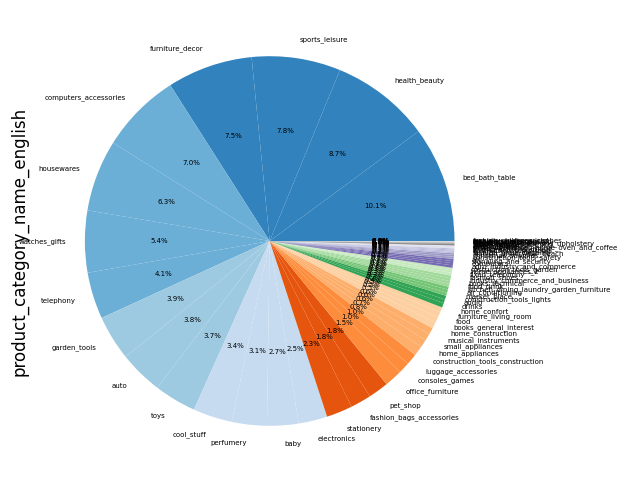

In [394]:
olist_order_items_dataset['product_category_name_english'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colormap='tab20c',
    textprops={'fontsize': 5})

<AxesSubplot: ylabel='macro_EN_categ'>

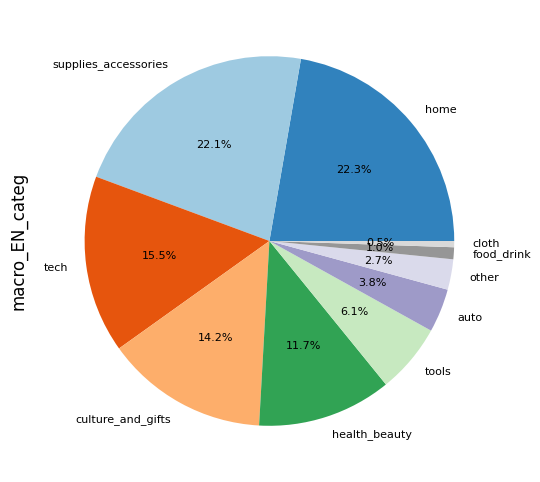

In [395]:
olist_order_items_dataset['macro_EN_categ'].value_counts().plot(
    kind='pie', #explode=explode,
    autopct='%1.1f%%', colormap='tab20c', textprops={'fontsize': 8})

Le regroupement est assez efficace.

 ### Note moyenne donnée

In [396]:
df_rev_score = olist_order_reviews_dataset[['customer_unique_id', 'review_score']]
df_rev_score

customer_unique_id  review_score
0      68a5590b9926689be4e10f4ae2db21a8             4
1      64190b91b656ab8f37eb89b93dc84584             5
2      1d47144362c14e94ccdd213e8ec277d5             5
3      c8cf6cb6b838dc7a33ed199b825e8616             5
4      d16000272660a1fef81482ad75ba572a             5
...                                 ...           ...
96090  50605c81f77a2171191dffee444613b2             5
96091  597cbb334f18a671472f7e16648228b4             5
96092  c860357db400d72a2497064f8376fba9             5
96093  96ac4cb74918d3ace141d3d3ddc1ff02             4
96094  432d4f5ec4f462779a48a51c33950351             1

[96095 rows x 2 columns]

In [397]:
df_cust_rev_score = pd.DataFrame(df_rev_score.groupby(['customer_unique_id'])['review_score'].mean()).reset_index()
df_cust_rev_score.rename({'review_score': 'mean_rev_score'}, axis=1, inplace=True)
df_cust_rev_score

customer_unique_id  mean_rev_score
0      0000366f3b9a7992bf8c76cfdf3221e2             5.0
1      0000b849f77a49e4a4ce2b2a4ca5be3f             4.0
2      0000f46a3911fa3c0805444483337064             3.0
3      0000f6ccb0745a6a4b88665a16c9f078             4.0
4      0004aac84e0df4da2b147fca70cf8255             5.0
...                                 ...             ...
92499  fffcf5a5ff07b0908bd4e2dbc735a684             5.0
92500  fffea47cd6d3cc0a88bd621562a9d061             4.0
92501  ffff371b4d645b6ecea244b27531430a             5.0
92502  ffff5962728ec6157033ef9805bacc48             5.0
92503  ffffd2657e2aad2907e67c3e9daecbeb             5.0

[92504 rows x 2 columns]

In [398]:
df_cust_rev_score['mean_rev_score'].value_counts()

5.000000    54312
4.000000    18147
1.000000     8877
3.000000     7668
2.000000     2815
4.500000      292
3.500000      146
2.500000       83
4.333333       31
4.666667       31
3.666667       30
2.333333       14
1.500000       13
1.666667        7
2.666667        5
3.333333        5
1.333333        4
4.750000        4
4.250000        3
3.750000        2
3.400000        2
4.800000        2
4.200000        2
3.600000        1
3.800000        1
4.857143        1
3.250000        1
4.142857        1
2.800000        1
2.777778        1
4.600000        1
1.800000        1
Name: mean_rev_score, dtype: int64

On a bien des notes moyennées sur les différentes commandes.

 ### Récence de client/d'achat

On va chercher à mesurer la propriété "récent" du dernier achat de chaque client. Par exmple, plus un achat a une date élevée, plus il est récent, donc plus élevé sera le score du client sur cet axe.

Et si on prenait tout simplement le nombre de secondes écoulées depuis le 1er janvier 1970 ? Moins celui du 1er janvier 2017 ( origine des données, pour avoir des points plus distribués sur cette échelle).

On choisira la date `order_purchase_timestamp`.

In [399]:
def time_to_recency_s(t, start):
    """Returns the duration between a date and a reference date, in seconds.
    
    Parameters
    ----------
    t: datetime
        Date considered.
    start: datetime
        Reference date.

    Returns
    -------
    int
        Duration in seconds.
    """
    return (t-start).total_seconds()

In [400]:
def time_to_recency_n_days(t, start, n=1):
    """Returns the duration between a date and a reference date, in number of time units.
    
    Parameters
    ----------
    t: datetime
        Date considered.
    start: datetime
        Reference date.
    n: int, optional
        Number of days in the time unit.
        
    Returns
    -------
    int
        Duration in number of time units.
    """
    return int((t-start).days/n)

In [401]:
start = datetime.datetime(2017,1,1)

In [402]:
df_recency = olist_orders_dataset[['customer_unique_id', 'order_purchase_timestamp']].copy()

In [403]:
df_recency['order_purchase_recency_sec'] = df_recency['order_purchase_timestamp'].apply(
    time_to_recency_s, start=start)
df_recency['order_purchase_recency_15d'] = df_recency['order_purchase_timestamp'].apply(
    time_to_recency_n_days, start=start, n=15)
df_recency['order_purchase_recency_01d'] = df_recency['order_purchase_timestamp'].apply(
    time_to_recency_n_days, start=start, n=1)

In [404]:
df_recency['order_purchase_recency_sec'].sort_values(ascending=True)

76218      388566.0
15700      388880.0
72254      389196.0
14873      389348.0
26140      389483.0
            ...    
96140    52316759.0
29112    52323503.0
30466    52323508.0
67419    52325520.0
85234    52326037.0
Name: order_purchase_recency_sec, Length: 96211, dtype: float64

Il faut maintenant retenir l'achat le plus récent pour chaque utilisateur. C'est l'achat qui a la valeur maximale de récence.

In [405]:
df_cust_recency = pd.DataFrame(df_recency.groupby(['customer_unique_id'])['order_purchase_recency_sec'].max()).reset_index()
order_purchase_recency_15d = pd.DataFrame(df_recency.groupby(['customer_unique_id'])['order_purchase_recency_15d'].max()).reset_index()
order_purchase_recency_01d = pd.DataFrame(df_recency.groupby(['customer_unique_id'])['order_purchase_recency_01d'].max()).reset_index()
df_cust_recency['order_purchase_recency_15d'] = order_purchase_recency_15d['order_purchase_recency_15d']
df_cust_recency['order_purchase_recency_01d'] = order_purchase_recency_01d['order_purchase_recency_01d']

In [406]:
df_cust_recency

customer_unique_id  order_purchase_recency_sec  \
0      0000366f3b9a7992bf8c76cfdf3221e2                  42720987.0   
1      0000b849f77a49e4a4ce2b2a4ca5be3f                  42462687.0   
2      0000f46a3911fa3c0805444483337064                   5951103.0   
3      0000f6ccb0745a6a4b88665a16c9f078                  24611381.0   
4      0004aac84e0df4da2b147fca70cf8255                  27459942.0   
...                                 ...                         ...   
93099  fffcf5a5ff07b0908bd4e2dbc735a684                  13726836.0   
93100  fffea47cd6d3cc0a88bd621562a9d061                  29707676.0   
93101  ffff371b4d645b6ecea244b27531430a                   3253756.0   
93102  ffff5962728ec6157033ef9805bacc48                  42045461.0   
93103  ffffd2657e2aad2907e67c3e9daecbeb                  10527525.0   

       order_purchase_recency_15d  order_purchase_recency_01d  
0                              32                         494  
1                              32                         491  
2                               4                          68  
3                              18                         284  
4                              21                         317  
...                           ...                         ...  
93099                          10                         158  
93100                          22                         343  
93101                           2                          37  
93102                          32                         486  
93103                           8                         121  

[93104 rows x 4 columns]

### Intervalles de temps entre commande et livraison réelle, et livraison estimée et réelle

In [407]:
def deltatime_to_int_days(dt):
    """Converts a duration of type timedelta to a number of days."""
    return dt.days

In [408]:
olist_orders_dataset.loc[olist_orders_dataset['order_delivered_customer_date'].isna()]

order_id                       customer_id  \
2916   2d1e2d5bf4dc7227b3bfebb81328c15f  ec05a6d8558c6455f0cbbd8a420ad34f   
19965  f5dd62b788049ad9fc0526e3ad11a097  5e89028e024b381dc84a13a3570decb4   
42415  2ebdfc4f15f23b91474edf87475f108e  29f0540231702fda0cfdee0a310f11aa   
76698  e69f75a717d64fc5ecdfae42b2e8e086  cfda40ca8dd0a5d486a9635b611b398a   
80172  0d3268bad9b086af767785e3f0fc0133  4f1d63d35fb7c8999853b2699f5c7649   
89640  2d858f451373b04fb5c984a1cc2defaf  e08caf668d499a6d643dafd7c5cc498a   
94473  ab7c89dc1bf4a1ead9d6ec1ec8968a84  dd1b84a7286eb4524d52af4256c0ba24   
94856  20edc82cf5400ce95e1afacc25798b31  28c37425f1127d887d7337f284080a0f   

      order_status order_purchase_timestamp   order_approved_at  \
2916     delivered      2017-11-28 17:44:07 2017-11-28 17:56:40   
19965    delivered      2018-06-20 06:58:43 2018-06-20 07:19:05   
42415    delivered      2018-07-01 17:05:11 2018-07-01 17:15:12   
76698    delivered      2018-07-01 22:05:55 2018-07-01 22:15:14   
80172    delivered      2018-07-01 21:14:02 2018-07-01 21:29:54   
89640    delivered      2017-05-25 23:22:43 2017-05-25 23:30:16   
94473    delivered      2018-06-08 12:09:39 2018-06-08 12:36:39   
94856    delivered      2018-06-27 16:09:12 2018-06-27 16:29:30   

      order_delivered_carrier_date order_delivered_customer_date  \
2916           2017-11-30 18:12:23                           NaT   
19965          2018-06-25 08:05:00                           NaT   
42415          2018-07-03 13:57:00                           NaT   
76698          2018-07-03 13:57:00                           NaT   
80172          2018-07-03 09:28:00                           NaT   
89640                          NaT                           NaT   
94473          2018-06-12 14:10:00                           NaT   
94856          2018-07-03 19:26:00                           NaT   

      order_estimated_delivery_date                customer_unique_id  
2916                     2017-12-18  13467e882eb3a701826435ee4424f2bd  
19965                    2018-07-16  2f17c5b324ad603491521b279a9ff4de  
42415                    2018-07-30  1bd06a0c0df8b23dacfd3725d2dc0bb9  
76698                    2018-07-30  3bc508d482a402715be4d5cf4020cc81  
80172                    2018-07-24  ebf7e0d43a78c81991a4c59c145c75db  
89640                    2017-06-23  d77cf4be2654aa70ef150f8bfec076a6  
94473                    2018-06-26  cce5e8188bf42ffb3bb5b18ff58f5965  
94856                    2018-07-19  175378436e2978be55b8f4316bce4811

In [409]:
olist_orders_dataset['order_estimated_delivery_date'].isna().sum()

0

In [410]:
olist_orders_dataset['dt_customer_wait'] = olist_orders_dataset['order_delivered_customer_date'] - olist_orders_dataset['order_purchase_timestamp']
olist_orders_dataset['dt_approbation']   = olist_orders_dataset['order_approved_at'] - olist_orders_dataset['order_purchase_timestamp']
olist_orders_dataset['dt_preparing']     = olist_orders_dataset['order_delivered_carrier_date'] - olist_orders_dataset['order_approved_at']
olist_orders_dataset['dt_carrying']      = olist_orders_dataset['order_delivered_customer_date'] - olist_orders_dataset['order_delivered_carrier_date']
olist_orders_dataset['dt_delivery_late'] = olist_orders_dataset['order_delivered_customer_date'] - olist_orders_dataset['order_estimated_delivery_date']

olist_orders_dataset['dt_customer_wait'] = olist_orders_dataset['dt_customer_wait'].apply(deltatime_to_int_days)
olist_orders_dataset['dt_approbation']   = olist_orders_dataset['dt_approbation'].apply(deltatime_to_int_days)
olist_orders_dataset['dt_preparing']     = olist_orders_dataset['dt_preparing'].apply(deltatime_to_int_days)
olist_orders_dataset['dt_carrying']      = olist_orders_dataset['dt_carrying'].apply(deltatime_to_int_days)
olist_orders_dataset['dt_delivery_late'] = olist_orders_dataset['dt_delivery_late'].apply(deltatime_to_int_days)

On n'annule pas les retards négatifs.

In [411]:
dt_cols = ['dt_customer_wait',
           'dt_approbation',
           'dt_preparing',
           'dt_carrying',
           'dt_delivery_late']

In [412]:
df_cust_dt = pd.DataFrame(olist_orders_dataset.groupby(['customer_unique_id'])[dt_cols].mean()).reset_index()
df_cust_dt

customer_unique_id  dt_customer_wait  dt_approbation  \
0      0000366f3b9a7992bf8c76cfdf3221e2               6.0             0.0   
1      0000b849f77a49e4a4ce2b2a4ca5be3f               3.0             0.0   
2      0000f46a3911fa3c0805444483337064              25.0             0.0   
3      0000f6ccb0745a6a4b88665a16c9f078              20.0             0.0   
4      0004aac84e0df4da2b147fca70cf8255              13.0             0.0   
...                                 ...               ...             ...   
93099  fffcf5a5ff07b0908bd4e2dbc735a684              27.0             0.0   
93100  fffea47cd6d3cc0a88bd621562a9d061              30.0             0.0   
93101  ffff371b4d645b6ecea244b27531430a              14.0             0.0   
93102  ffff5962728ec6157033ef9805bacc48              11.0             0.0   
93103  ffffd2657e2aad2907e67c3e9daecbeb               7.0             0.0   

       dt_preparing  dt_carrying  dt_delivery_late  
0               1.0          4.0              -5.0  
1               1.0          1.0              -5.0  
2               2.0         23.0              -2.0  
3               0.0         19.0             -12.0  
4               1.0         11.0              -8.0  
...             ...          ...               ...  
93099          14.0         12.0             -27.0  
93100          10.0         19.0              -3.0  
93101           0.0         14.0             -30.0  
93102           1.0         10.0             -14.0  
93103           0.0          5.0             -16.0  

[93104 rows x 6 columns]

## Rassemblement des informations dans une même table

In [413]:
df_cust = pd.merge(df_cust_mean_amount, df_cust_nb_items_mean.drop(['nb_orders', 'nb_items'], axis=1),
                   how='inner',
                   left_on='customer_unique_id',
                   right_on='customer_unique_id')
df_cust = pd.merge(df_cust, df_cust_payment_type.drop('payment_installments', axis=1),
                   how='inner',
                   left_on='customer_unique_id',
                   right_on='customer_unique_id')
df_cust = pd.merge(df_cust, df_cust_payment_type_ratio,
                   how='inner',
                   left_on='customer_unique_id',
                   right_on='customer_unique_id')
df_cust = pd.merge(df_cust, df_cust_payment_inst,
                   how='inner',
                   left_on='customer_unique_id',
                   right_on='customer_unique_id')
df_cust = pd.merge(df_cust, df_cust_region,
                   how='inner',
                   left_on='customer_unique_id',
                   right_on='customer_unique_id')
df_cust = pd.merge(df_cust, df_cust_geoloc[['customer_unique_id', 'geolocation_lat', 'geolocation_lng']],
                   how='inner',
                   left_on='customer_unique_id',
                   right_on='customer_unique_id')
df_cust = pd.merge(df_cust, df_cust_prod_categ_macro.drop('order_id', axis=1),
                   how='inner',
                   left_on='customer_unique_id',
                   right_on='customer_unique_id')
df_cust = pd.merge(df_cust, df_cust_rev_score,
                   how='inner',
                   left_on='customer_unique_id',
                   right_on='customer_unique_id')
df_cust = pd.merge(df_cust, df_cust_recency,
                   how='inner',
                   left_on='customer_unique_id',
                   right_on='customer_unique_id')
df_cust = pd.merge(df_cust, df_cust_dt,
                   how='inner',
                   left_on='customer_unique_id',
                   right_on='customer_unique_id')
df_cust

customer_unique_id  total_amount  nb_orders  nb_items  \
0      0000366f3b9a7992bf8c76cfdf3221e2        129.90          1         1   
1      0000b849f77a49e4a4ce2b2a4ca5be3f         18.90          1         1   
2      0000f46a3911fa3c0805444483337064         69.00          1         1   
3      0000f6ccb0745a6a4b88665a16c9f078         25.99          1         1   
4      0004aac84e0df4da2b147fca70cf8255        180.00          1         1   
...                                 ...           ...        ...       ...   
94203  fffcf5a5ff07b0908bd4e2dbc735a684       1570.00          1         2   
94204  fffea47cd6d3cc0a88bd621562a9d061         64.89          1         1   
94205  ffff371b4d645b6ecea244b27531430a         89.90          1         1   
94206  ffff5962728ec6157033ef9805bacc48        115.00          1         1   
94207  ffffd2657e2aad2907e67c3e9daecbeb         56.99          1         1   

       mean_amount_per_order  mean_amount_per_item  nb_items_mean  \
0                     129.90                129.90            1.0   
1                      18.90                 18.90            1.0   
2                      69.00                 69.00            1.0   
3                      25.99                 25.99            1.0   
4                     180.00                180.00            1.0   
...                      ...                   ...            ...   
94203                1570.00                785.00            2.0   
94204                  64.89                 64.89            1.0   
94205                  89.90                 89.90            1.0   
94206                 115.00                115.00            1.0   
94207                  56.99                 56.99            1.0   

       payment_type_boleto  payment_type_credit_card  payment_type_debit_card  \
0                      0.0                       1.0                      0.0   
1                      0.0                       1.0                      0.0   
2                      0.0                       1.0                      0.0   
3                      0.0                       1.0                      0.0   
4                      0.0                       1.0                      0.0   
...                    ...                       ...                      ...   
94203                  0.0                       1.0                      0.0   
94204                  0.0                       1.0                      0.0   
94205                  0.0                       1.0                      0.0   
94206                  0.0                       1.0                      0.0   
94207                  0.0                       1.0                      0.0   

       payment_type_voucher                          order_id  \
0                       0.0  e22acc9c116caa3f2b7121bbb380d08e   
1                       0.0  3594e05a005ac4d06a72673270ef9ec9   
2                       0.0  b33ec3b699337181488304f362a6b734   
3                       0.0  41272756ecddd9a9ed0180413cc22fb6   
4                       0.0  d957021f1127559cd947b62533f484f7   
...                     ...                               ...   
94203                   0.0  725cf8e9c24e679a8a5a32cb92c9ce1e   
94204                   0.0  c71b9252fd7b3b263aaa4cb09319a323   
94205                   0.0  fdc45e6c7555e6cb3cc0daca2557dbe1   
94206                   0.0  94d3ee0bc2a0af9d4fa47a4d63616e8d   
94207                   0.0  f79a35da168301ae56922475da21117b   

       payment_sequential first_payment_type  payment_value  \
0                       1        credit_card         141.90   
1                       1        credit_card          27.19   
2                       1        credit_card          86.22   
3                       1        credit_card          43.62   
4                       1        credit_card         196.89   
...                   ...                ...            ...   
94203                   1        credit_card        2067.42 

In [414]:
df_cust.loc[df_cust['customer_unique_id'].duplicated(keep='last'), :]

customer_unique_id  total_amount  nb_orders  nb_items  \
33     00172711b30d52eea8b313a7f2cced02         74.50          1         1   
103    004288347e5e88a27ded2bb23747066c        317.89          2         2   
120    004b45ec5c64187465168251cd1c9c2f         27.00          1         1   
141    0058f300f57d7b93c477a131a59b36c3         72.58          1         1   
303    00cc12a6d8b578b8ebd21ea4e2ae8b27         99.80          2         2   
...                                 ...           ...        ...       ...   
93943  ff44401d0d8f5b9c54a47374eb48c1b8         39.80          2         2   
94043  ff8892f7c26aa0446da53d01b18df463        277.95          2         2   
94060  ff922bdd6bafcdf99cb90d7f39cea5b3         94.79          3         3   
94061  ff922bdd6bafcdf99cb90d7f39cea5b3         94.79          3         3   
94164  ffe254cc039740e17dd15a5305035928         51.08          2         2   

       mean_amount_per_order  mean_amount_per_item  nb_items_mean  \
33                 74.500000             74.500000            1.0   
103               158.945000            158.945000            1.0   
120                27.000000             27.000000            1.0   
141                72.580000             72.580000            1.0   
303                49.900000             49.900000            1.0   
...                      ...                   ...            ...   
93943              19.900000             19.900000            1.0   
94043             138.975000            138.975000            1.0   
94060              31.596667             31.596667            1.0   
94061              31.596667             31.596667            1.0   
94164              25.540000             25.540000            1.0   

       payment_type_boleto  payment_type_credit_card  payment_type_debit_card  \
33                     0.0                       1.0                      0.0   
103                    0.0                       2.0                      0.0   
120                    1.0                       0.0                      0.0   
141                    0.0                       0.0                      0.0   
303                    2.0                       0.0                      0.0   
...                    ...                       ...                      ...   
93943                  0.0                       2.0                      0.0   
94043                  0.0                       2.0                      0.0   
94060                  0.0                       3.0                      0.0   
94061                  0.0                       3.0                      0.0   
94164                  0.0                       2.0                      0.0   

       payment_type_voucher                          order_id  \
33                      0.0  bb874c45df1a3c97842d52f31efee99a   
103                     0.0  08204559bebd39e09ee52dcb56d8faa2   
120                     0.0  9392c5e72885ad5aba87e6223ca9838d   
141                     2.0  81a93b2fa39e104b865b2bc471c16008   
303                     0.0  64307ceb91666760cf3ff463618302fd   
...                     ...                               ...   
93943                   2.0  c087855fe6f303205c09558f7f8103c8   
94043                   0.0  cb6e8d89049744886ad04520d5e0b2f6   
94060                   0.0  5f79e2da24a52e76bc22897df03a7901   
94061                   0.0  5f79e2da24a52e76bc22897df03a7901   
94164                   0.0  ebe76afae9242fc70b0b807b78f17adb   

       payment_sequential first_payment_type  payment_value  \
33                      1        credit_card         122.07   
103                     1        credit_card         103.28   
120                     1             boleto          49.85   
141                     1            voucher          79.56   
303                     1             boleto          44.42   
...                   ...                ...            ...   
93943                   1        credit_card           0.53 

Nombre de valeurs manquantes créées à cause des jointures infructueuses :

In [415]:
df_cust.isna().sum().sum()

51

In [416]:
for col in df_cust.columns:
    print(f"{col} : {df_cust[col].isna().sum()}")

customer_unique_id : 0
total_amount : 0
nb_orders : 0
nb_items : 0
mean_amount_per_order : 0
mean_amount_per_item : 0
nb_items_mean : 0
payment_type_boleto : 0
payment_type_credit_card : 0
payment_type_debit_card : 0
payment_type_voucher : 0
order_id : 0
payment_sequential : 0
first_payment_type : 0
payment_value : 0
credit_card_ratio : 0
boleto_ratio : 0
voucher_ratio : 0
debit_card_ratio : 0
all_card_ratio : 0
payment_installments : 0
payment_inst_cat : 0
customer_region_center-west : 0
customer_region_north : 0
customer_region_northeast : 0
customer_region_south : 0
customer_region_southeast : 0
customer_region : 0
geolocation_lat : 0
geolocation_lng : 0
macro_EN_categ_auto : 0
macro_EN_categ_cloth : 0
macro_EN_categ_culture_and_gifts : 0
macro_EN_categ_food_drink : 0
macro_EN_categ_health_beauty : 0
macro_EN_categ_home : 0
macro_EN_categ_other : 0
macro_EN_categ_supplies_accessories : 0
macro_EN_categ_tech : 0
macro_EN_categ_tools : 0
order_item_id : 0
product_id : 0
seller_id : 0


Dimensions du dataset de travail : 

In [417]:
print(df_cust.shape)

(94208, 57)


Nombre de valeurs totales dans le dataset de travail : 

In [418]:
print(df_cust.shape[0]*df_cust.shape[1])

5369856


## Etudes statistiques

### Etudes univariées

In [419]:
for col in df_cust.columns:
    print(col)

customer_unique_id
total_amount
nb_orders
nb_items
mean_amount_per_order
mean_amount_per_item
nb_items_mean
payment_type_boleto
payment_type_credit_card
payment_type_debit_card
payment_type_voucher
order_id
payment_sequential
first_payment_type
payment_value
credit_card_ratio
boleto_ratio
voucher_ratio
debit_card_ratio
all_card_ratio
payment_installments
payment_inst_cat
customer_region_center-west
customer_region_north
customer_region_northeast
customer_region_south
customer_region_southeast
customer_region
geolocation_lat
geolocation_lng
macro_EN_categ_auto
macro_EN_categ_cloth
macro_EN_categ_culture_and_gifts
macro_EN_categ_food_drink
macro_EN_categ_health_beauty
macro_EN_categ_home
macro_EN_categ_other
macro_EN_categ_supplies_accessories
macro_EN_categ_tech
macro_EN_categ_tools
order_item_id
product_id
seller_id
shipping_limit_date
price
freight_value
product_category_name_english
last_categ
mean_rev_score
order_purchase_recency_sec
order_purchase_recency_15d
order_purchase_recency

In [420]:
categ_cols = ['payment_inst_cat', 'last_categ', 'customer_region', 'first_payment_type']

In [421]:
num_cols = ['total_amount', 'mean_amount_per_item', 'mean_amount_per_order',
            'nb_items', 'nb_orders', 'nb_items_mean',
            'mean_rev_score',
#             'order_purchase_recency_15d'
            'order_purchase_recency_01d',
            'dt_customer_wait',
            'dt_approbation',
            'dt_preparing', 
            'dt_carrying',   
            'dt_delivery_late',
           ]

In [422]:
all_cols = categ_cols + num_cols

In [423]:
DisplotData.print_value_counts(df_cust[categ_cols], exclude=None)

Legend :

Numerical variable
------------------

Categorical variable
--------------------

----------------------------------------------------------------------------------------------------


last_categ
----------
supplies_accessories    21084
home                    19470
tech                    14836
culture_and_gifts       14344
health_beauty           11552
tools                    5232
auto                     3763
other                    2477
food_drink                936
cloth                     514
Name: last_categ, dtype: int64


payment_inst_cat
----------------
SEVERAL    49070
ONE        45138
Name: payment_inst_cat, dtype: int64


first_payment_type
------------------
credit_card    72596
boleto         18728
voucher         1450
debit_card      1434
Name: first_payment_type, dtype: int64


customer_region
---------------
southeast      64757
south          13523
northeast       8855
center-west     5329
north           1744
Name: customer_region, dtype: int64


#### Variables catégorielles

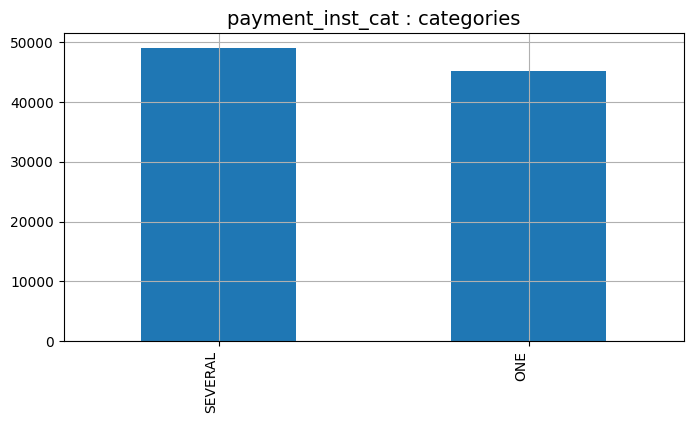

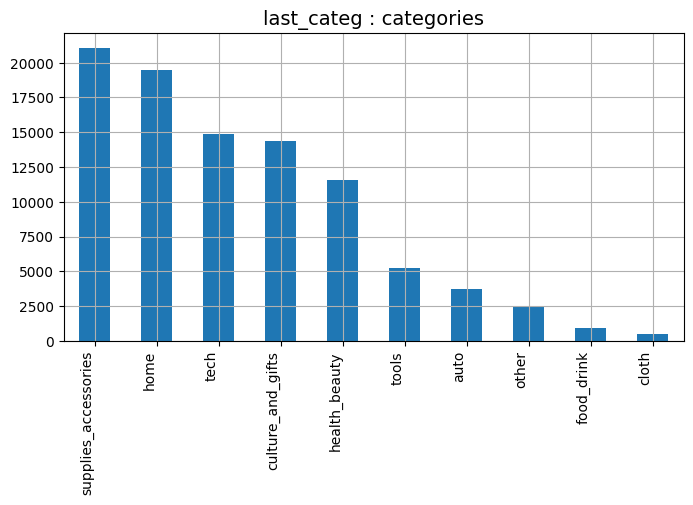

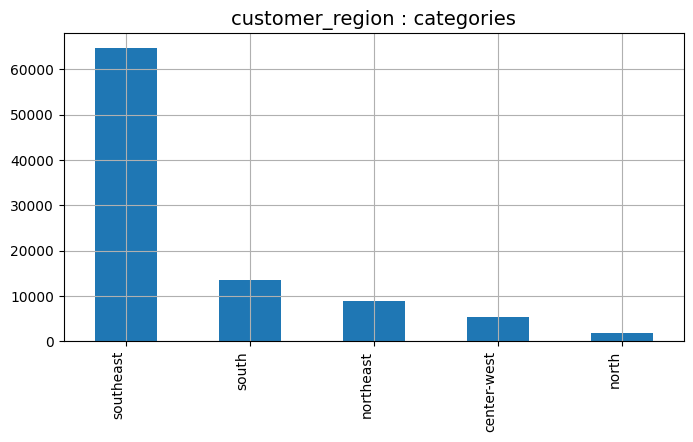

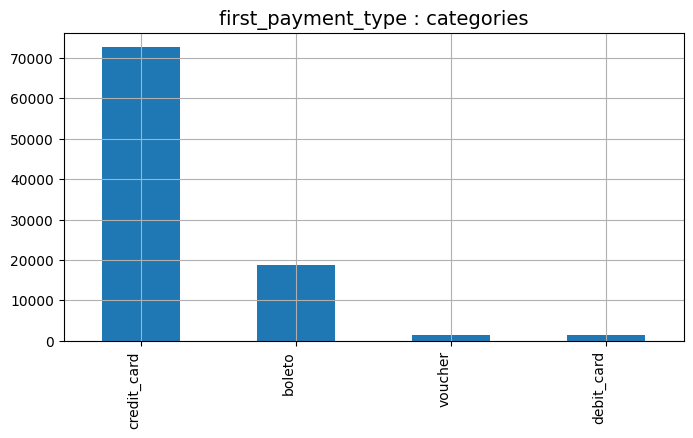

In [426]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

for colonne in categ_cols:
    DisplotData.plot_categ_bars(df_cust, colonne, seuil=1., max_bar=50, kind='bar', rot=90, show_nan=False)

Pour `customer_city`, la ville Sao Paulo écrase tout le monde, puis Rio de Janeiro et Belo Horizonte. Mais en tant que grandes villes en nb d'habitants, on ne sait pas si elles jouent un rôle réellement important sur la propension à consommer. Il faudrait diviser les nombres de commandes par la densité de population. Même remarque pour l'état (`customer_state`).
Les `zip_code` sont déjà un peu plus uniformes, mais cela ne change pas l'interrogation.

On ne se privera que de très peu de commandes en gardant que les `delivered`.

On a des vendeurs plus vendeurs que d'autres, des produits plus vendus que d'autres.

La variable `payment_type` a des différences significatives et est peu dimensionnelle (5 ou 4 si on retire `not_defined`). Elle renseigne aussi sur le profil du client dans son profil bancaire => on garde.
- [ ] Par contre, je ne sais pas dire si les cartes de crédit (vs débit) évoquent un client plus fortuné ou pas :
    - le débit différé ou le crédit permet de conserver son épargne plus longtemps (jusqu'à 1 mois)
    - mais permet aussi de ne pas se faire refuser des paiements, et de ne pas faire ses comptes pendant le mois...

Mieux on a des catégories de produits sensiblement plus vendues que d'autres (`product_category_name`).

#### Variables numériques

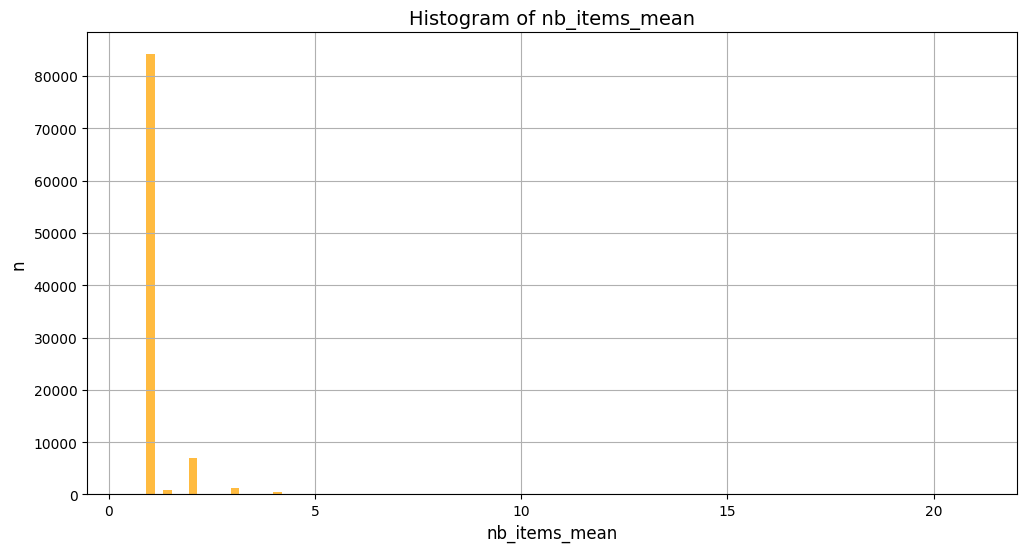

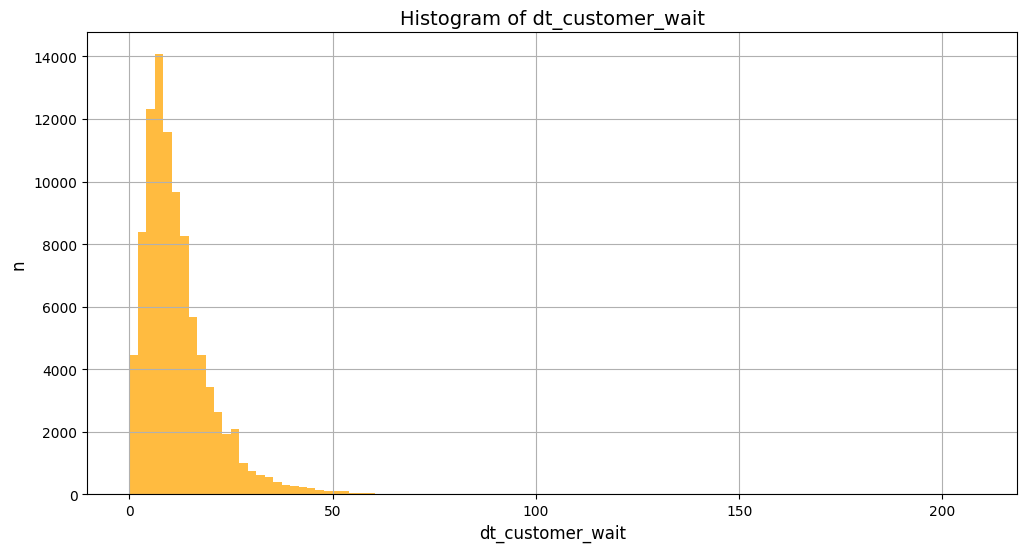

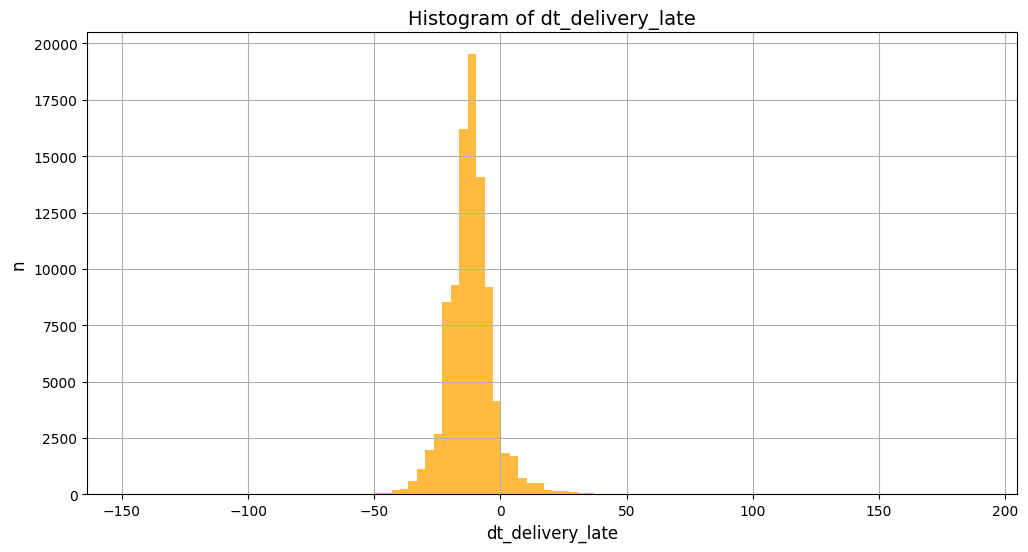

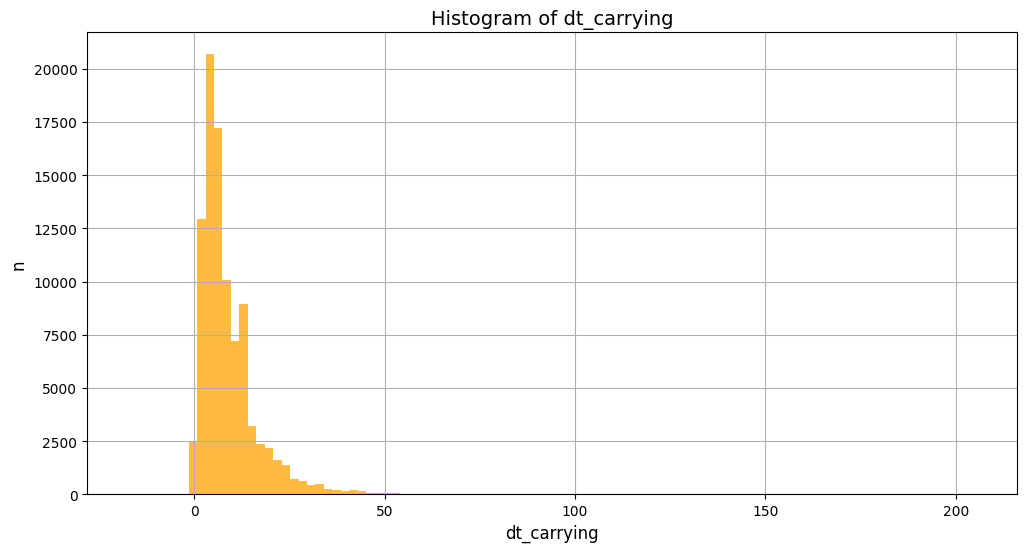

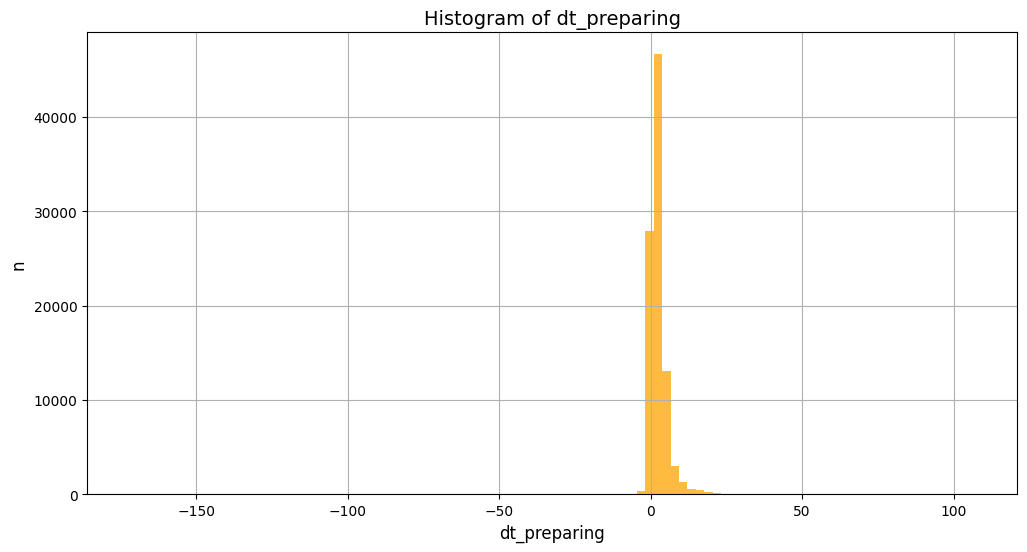

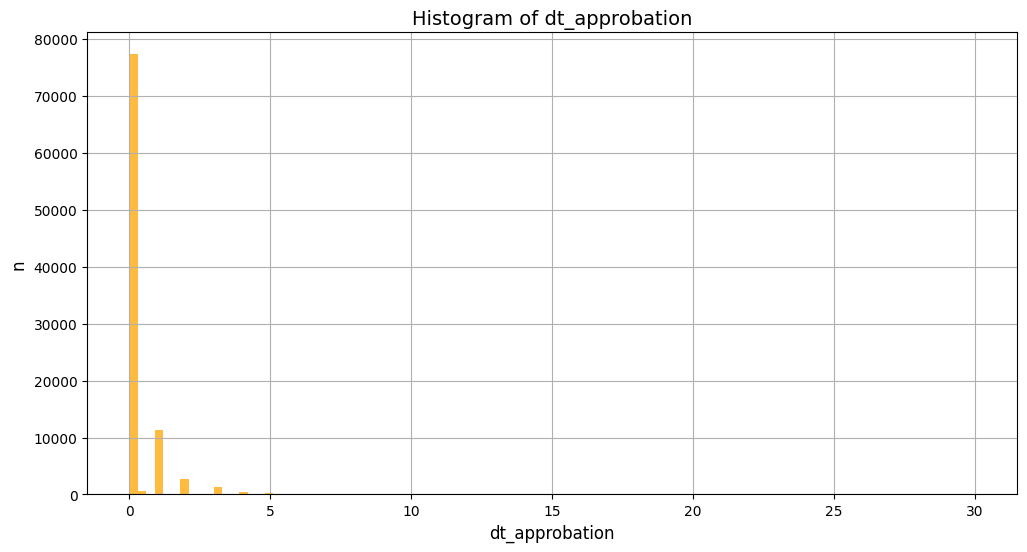

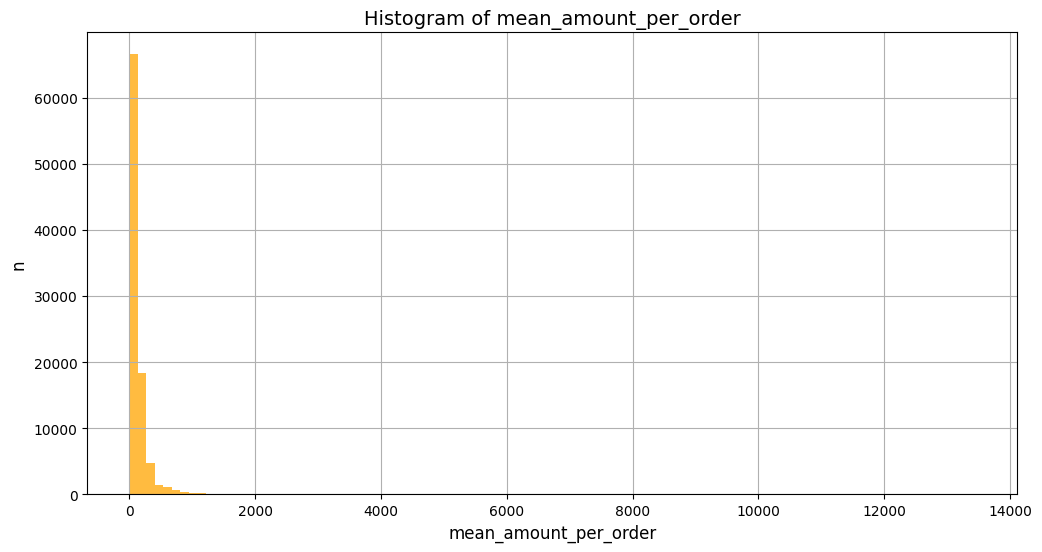

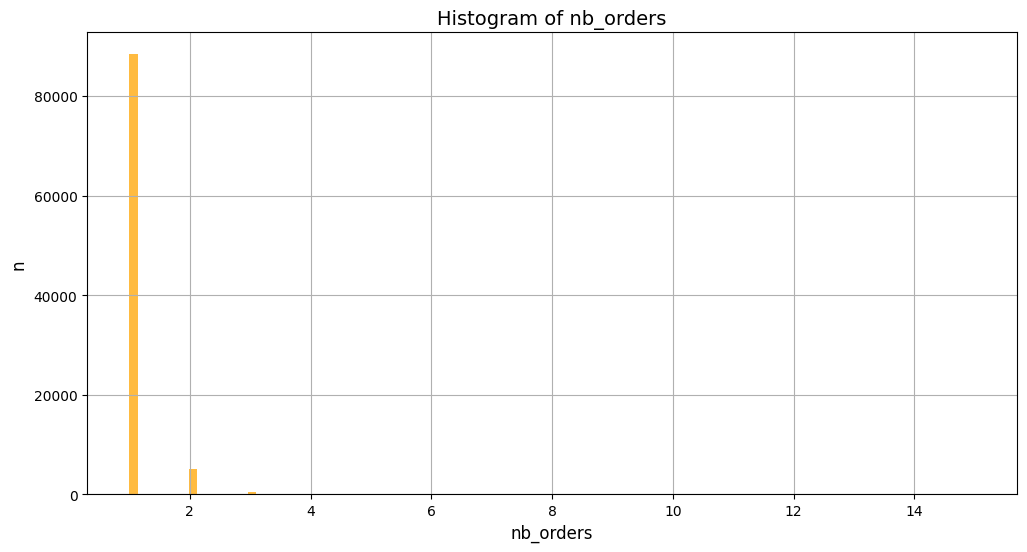

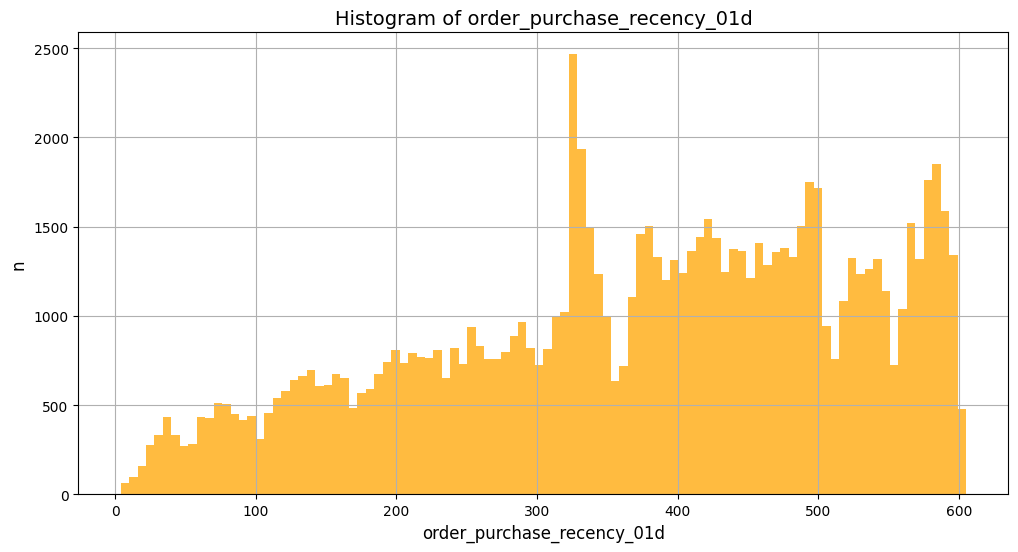

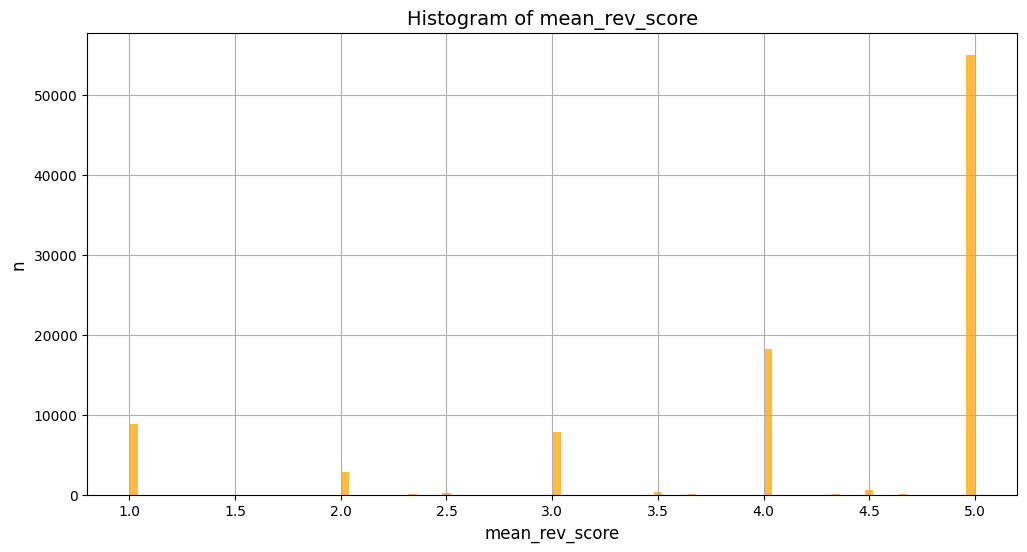

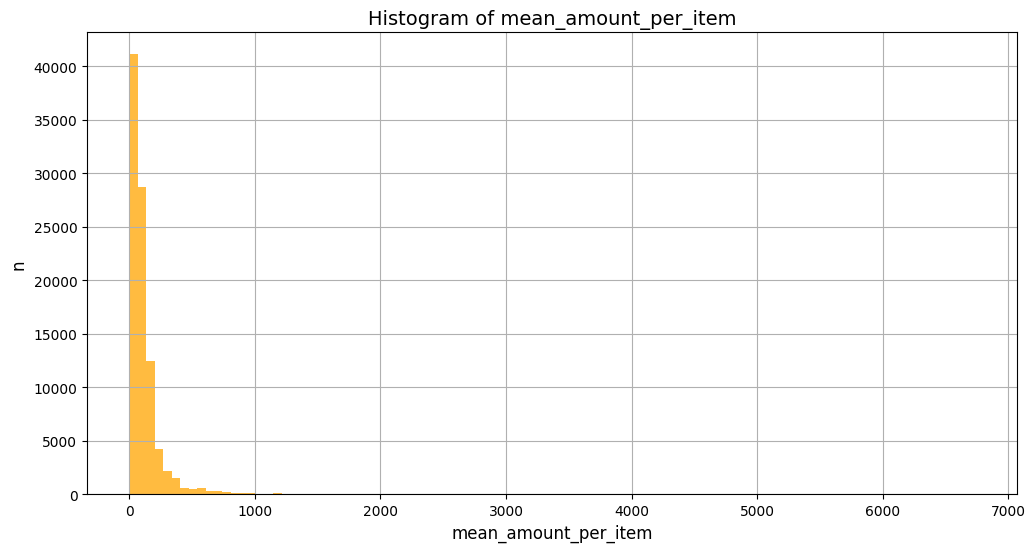

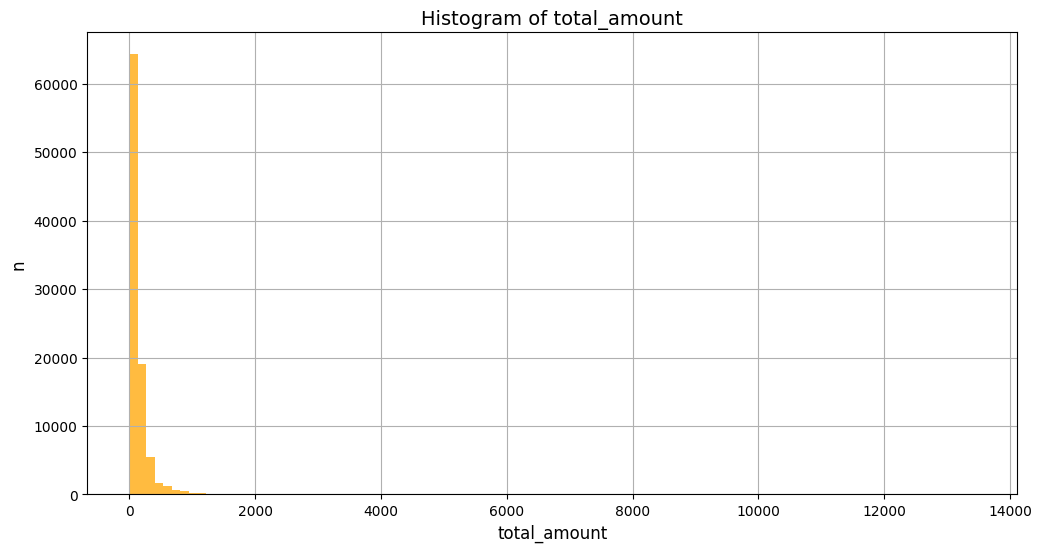

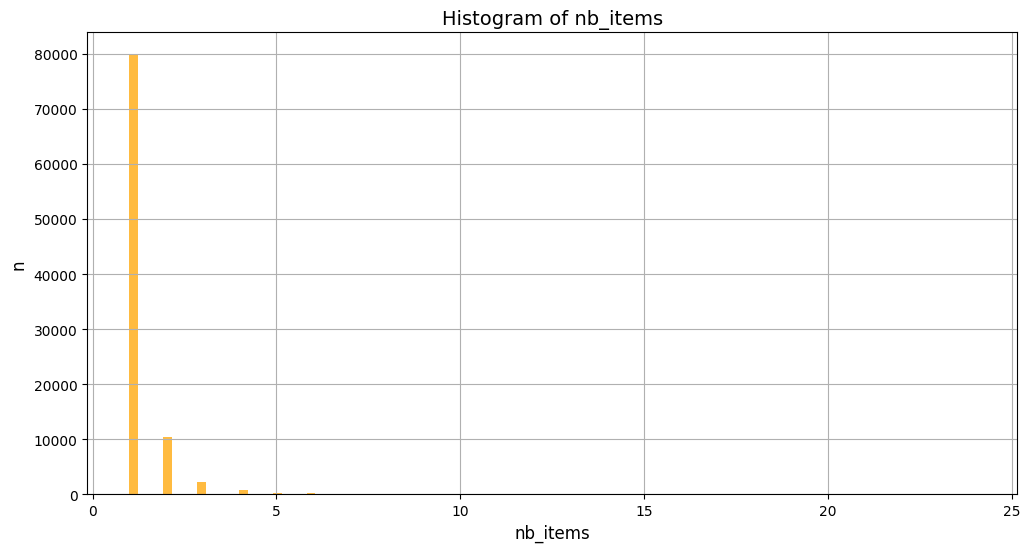

In [427]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

DisplotData.plot_distrib(df_cust, num_cols, nbins=100)

In [431]:
nb_orders_vals = df_cust['nb_orders'].sort_values(ascending=False).value_counts() # normalize=True
explode = [0.05]
explode.extend([0]*(nb_orders_vals.shape[0]-1))
explode

[0.05, 0, 0, 0, 0, 0, 0, 0, 0]

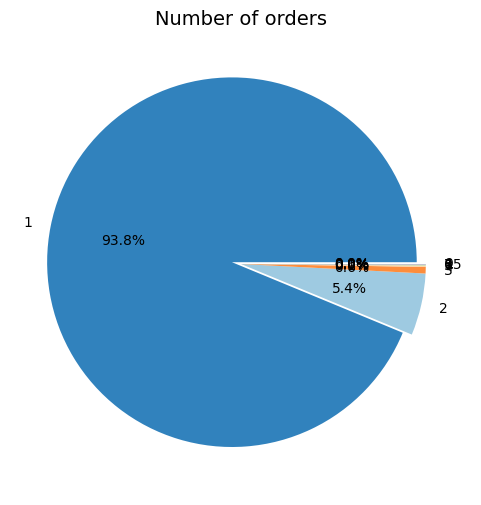

In [432]:
plt.figure(figsize=(6, 6))
nb_orders_vals.plot(
    kind='pie', labels=nb_orders_vals.index.astype(str), explode=explode,
    autopct='%1.1f%%', colormap='tab20c', textprops={'fontsize': 10}
)
plt.title('Number of orders')
plt.ylabel('')
plt.show()

In [433]:
nb_items_vals = df_cust['nb_items'].sort_values(ascending=False).value_counts() # normalize=True

explode = [0.05]
explode.extend([0]*(nb_items_vals.shape[0]-1))
explode

[0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

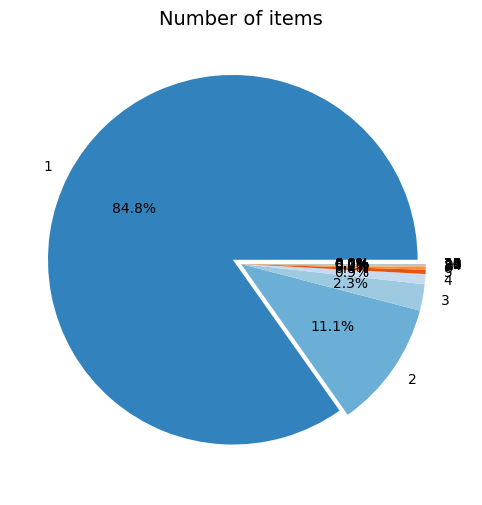

In [434]:
plt.figure()
nb_items_vals.plot(kind='pie', labels=nb_items_vals.index.astype(str), explode=explode,
          autopct='%1.1f%%', colormap='tab20c', textprops={'fontsize': 10})
plt.title("Number of items")
plt.ylabel('')
plt.show()

Les distributions du nombre de commandes et d'items sont très déséquilibrées : dans les deux cas, la valeur 1 prédomine largement. On peut conserver toutes les données en observant les grandeurs moyennes par item ou par commande.

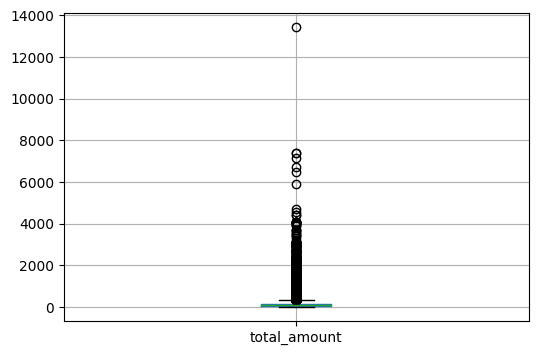

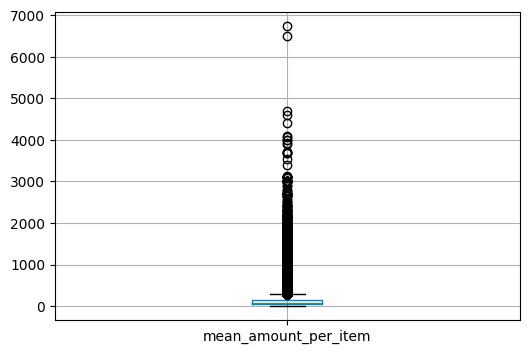

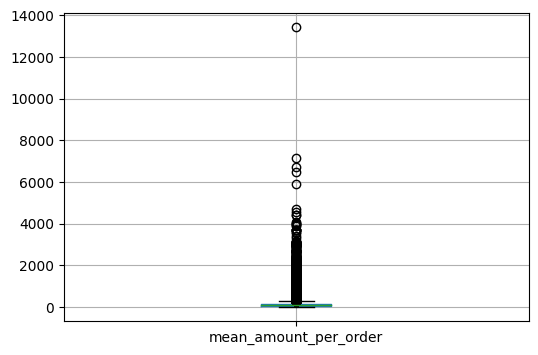

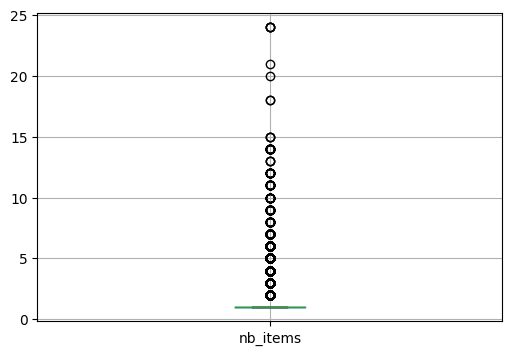

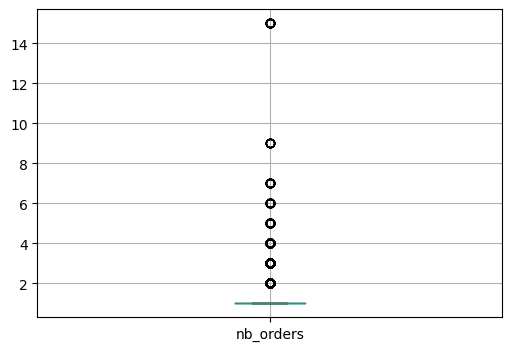

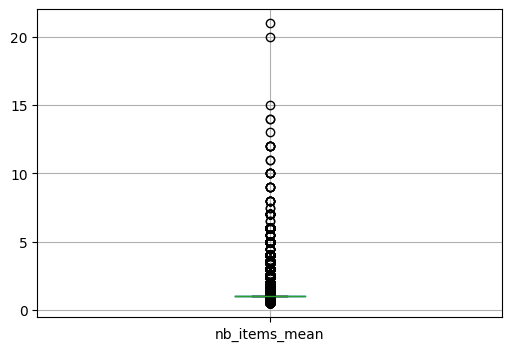

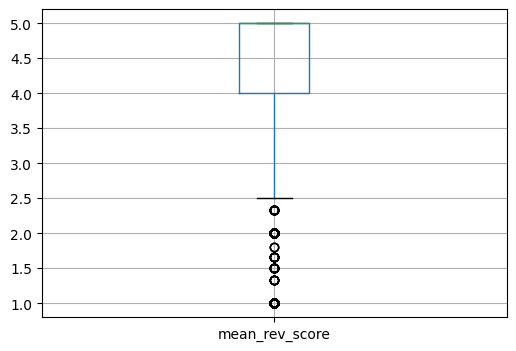

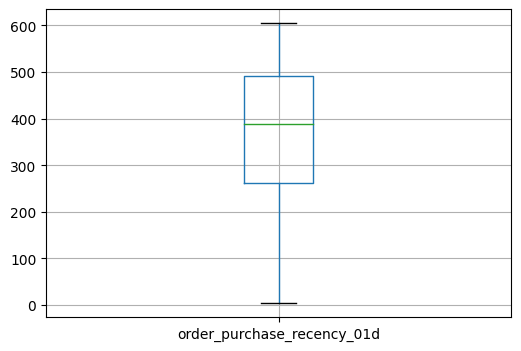

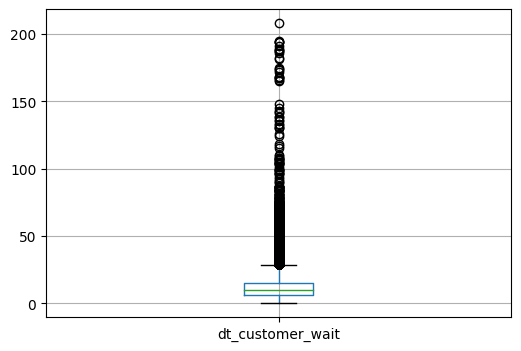

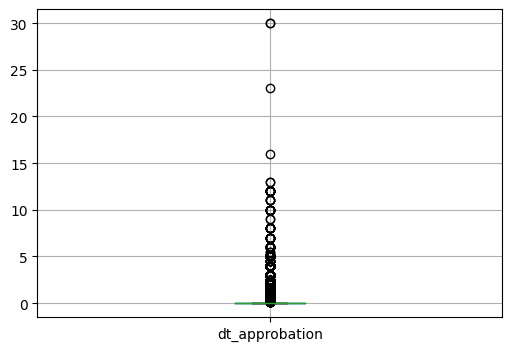

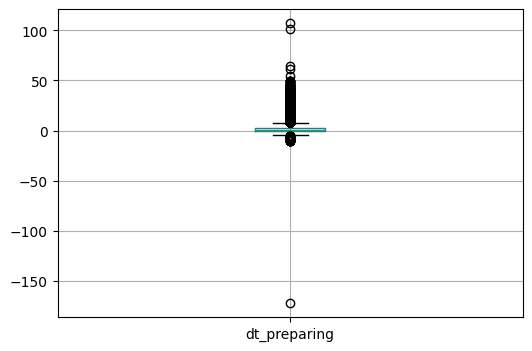

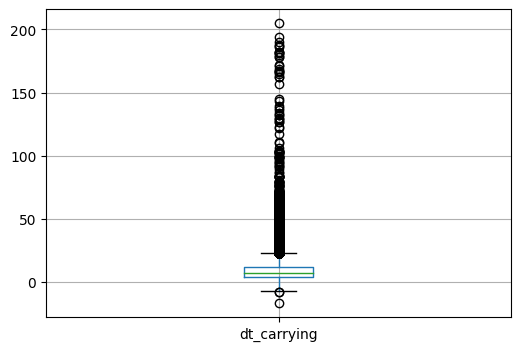

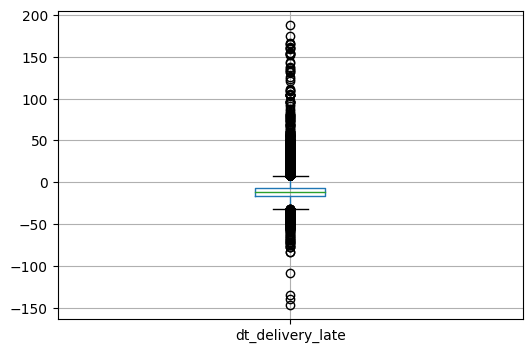

In [436]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

for col in num_cols:
    plt.figure()
    df_cust[[col]].boxplot()
    plt.grid('on')

#### Testons la normalité des temps d'attente et délais de retard :

On teste l'hypothèse nulle : $H_0$ = "la distribution des temps d'attente `dt_customer_wait` est normale".

In [438]:
X = df_cust[['dt_customer_wait']].dropna().values
X = StandardScaler().fit_transform(X.reshape(-1, 1)).reshape(-1,)
print(X.shape)

n = len(X)
print(X.shape)
K, p = kstest(X,'norm')
seuil = 0.886/math.sqrt(n)
print(f' K = {K:.3f} | threshold = {seuil:.12f}')
print(f' p = {p:.12f}')    

(94200,)
(94200,)
 K = 0.147 | threshold = 0.002886743991
 p = 0.000000000000


Les temps d'attente ne suivent pas une loi normale.

In [439]:
X = df_cust[['dt_delivery_late']].dropna().values
X = StandardScaler().fit_transform(X.reshape(-1, 1)).reshape(-1,)

n = len(X)
K, p = kstest(X,'norm')
seuil = 0.886/math.sqrt(n)
print(f' K = {K:.3f} | threshold = {seuil:.12f}')
print(f' p = {p:.12f}')    

 K = 0.106 | threshold = 0.002886743991
 p = 0.000000000000


Les temps de retard ne suivent pas une loi normale non plus.

### Etudes bivariées

#### Matrice de corrélation de Pearson

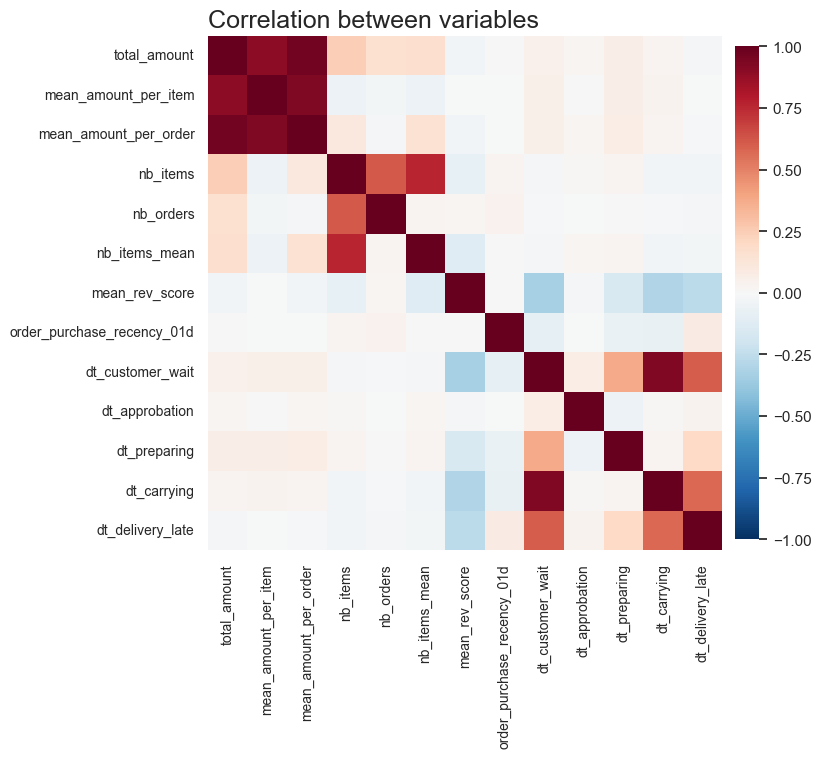

In [444]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

correl = df_cust[num_cols].corr(method='pearson')
sns.set(font_scale = 2)
sns.set(rc={'figure.facecolor':'white'})
fig, ax = plt.subplots(figsize=(8, 8))
correl_final = sns.heatmap(correl, vmin=-1, vmax=1, cmap="RdBu_r", square=True, ax=ax,
                          cbar_kws={'orientation':'vertical', 'pad':0.02, 'shrink':0.8}
                          ); # , center=0
correl_final.set_title('Correlation between variables', fontsize=18, loc='left');
correl_final.set_xticklabels(correl_final.get_xmajorticklabels(), fontsize = 10);
correl_final.set_yticklabels(correl_final.get_ymajorticklabels(), fontsize = 10);

- Forte corrélation entre `total_amount` et `mean_amount`, donc on ne gardera que la première.
- `nb_items` et `nb_orders` sont naturellement corrélées, mais pas au point d'être redondantes
- `nb_items_mean` et `nb_orders` sont **surprenamment** corrélées. Plus on fait de commandes, plus on commande de trucs par commande ?! 
- Bizarrement, plus les clients commandent, moins ils sont contents ^^ (`nb_items` vs `mean_rev_score`)
- `order_purchase_recency_sec` et `order_purchase_recency` corrélés, comme on s'y attendait.
- Les différents délais de process, en particulier celui d'attente totale (`dt_customer_wait`), sont anticorrélés à la satisfaction moyenne.

### Etudes multivariées

#### ACP standard

On évite de considérer les variables catégorielles dans l'ACP standard. On profite des corrélations pour éliminer quelques variables :

In [445]:
feat_cols_acp = ['total_amount',  # 'mean_amount',
                 'nb_items',
                 'nb_orders',
                 #'nb_items_mean',
                 'mean_rev_score',
                 'payment_installments',
                 #'order_purchase_recency_sec',
                 #'order_purchase_recency_15d',
                 'order_purchase_recency_01d',
                 ]  # + list(payment_types) + list(prod_categs_macro) #+ list(regions)

In [446]:
feat_cols_acp = ['total_amount',  # 'mean_amount',
                 'geolocation_lat', 'geolocation_lng',
                 'payment_installments',                 
                 ]  # + list(payment_types) + list(prod_categs_macro) #+ list(regions)

In [447]:
n_comp = 4
X_pca = df_cust[feat_cols_acp].values

In [448]:
%matplotlib inline
# %matplotlib notebook

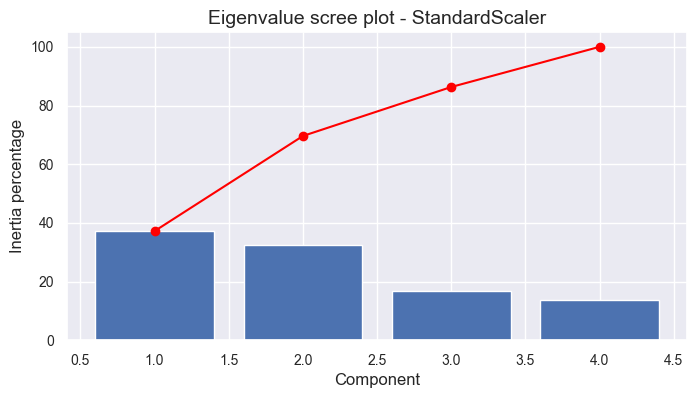

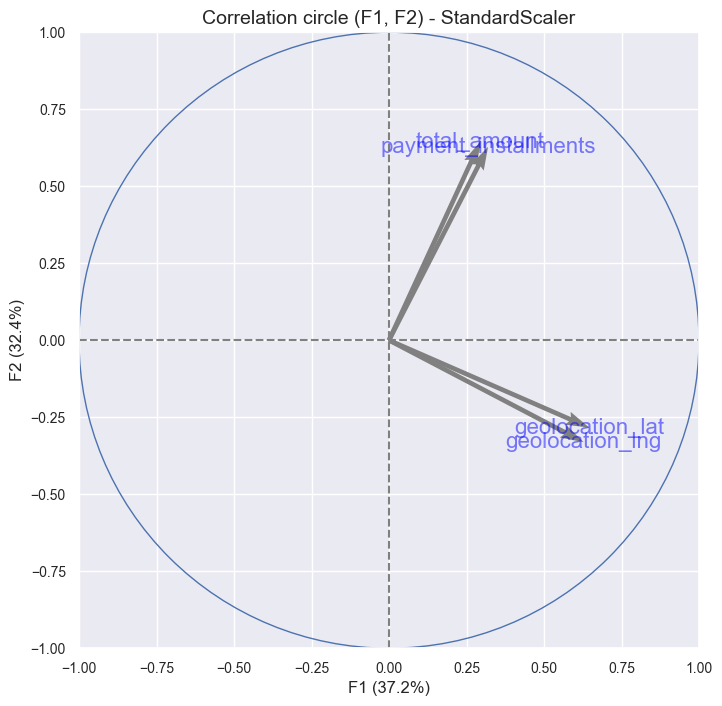

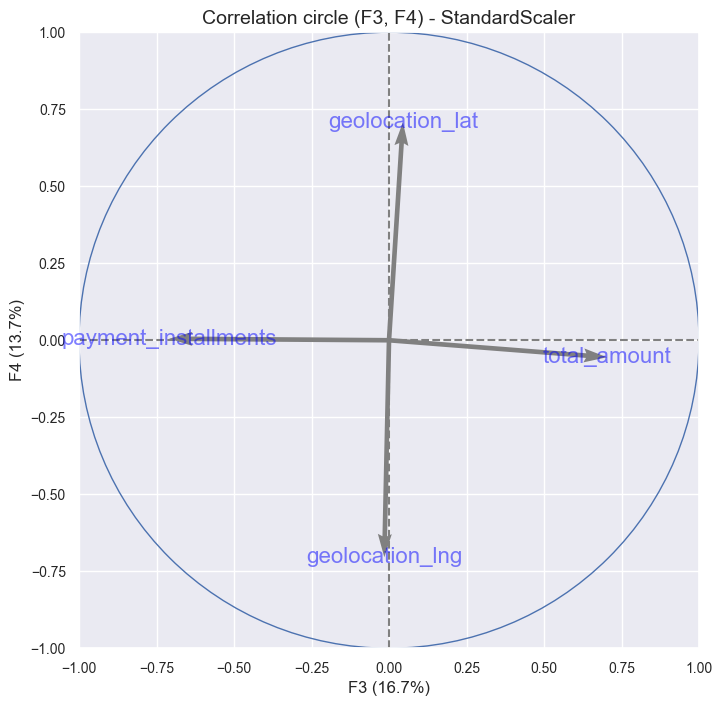

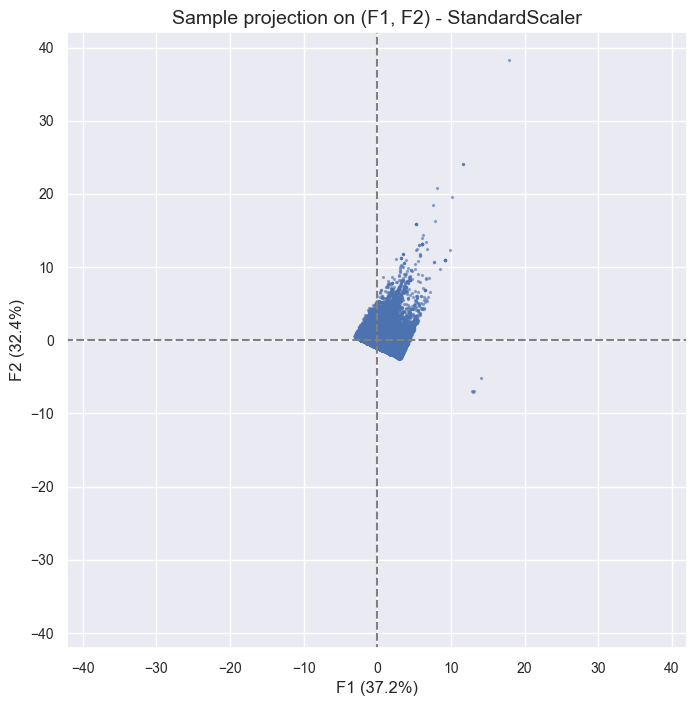

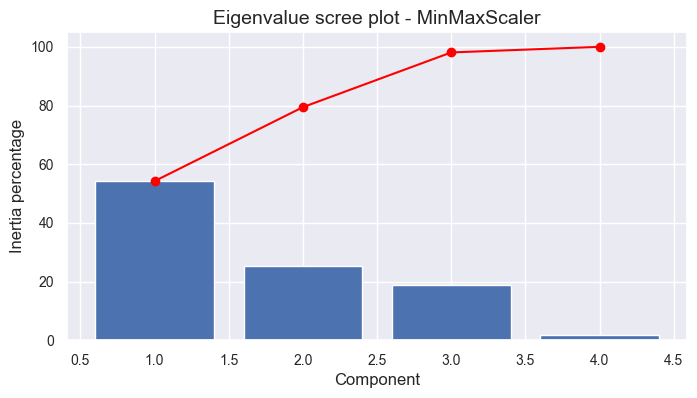

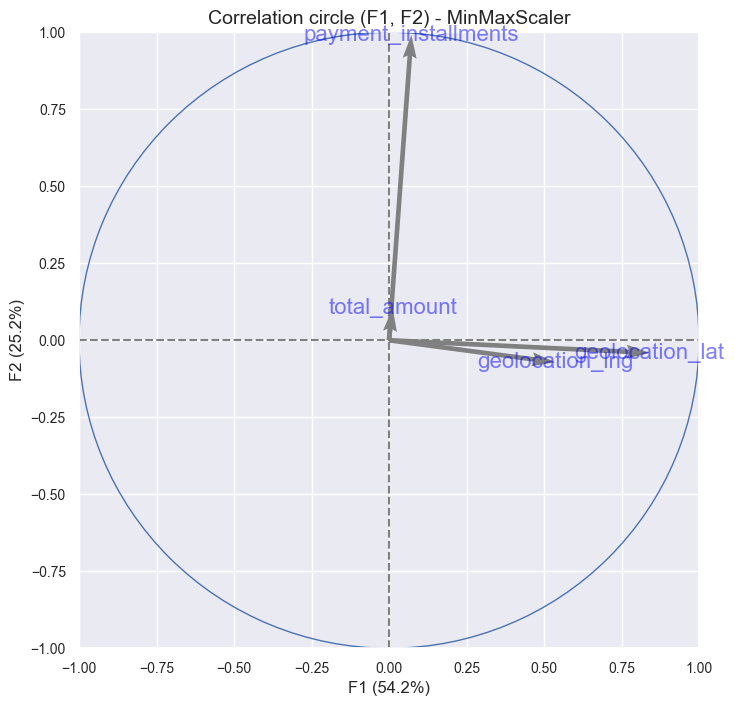

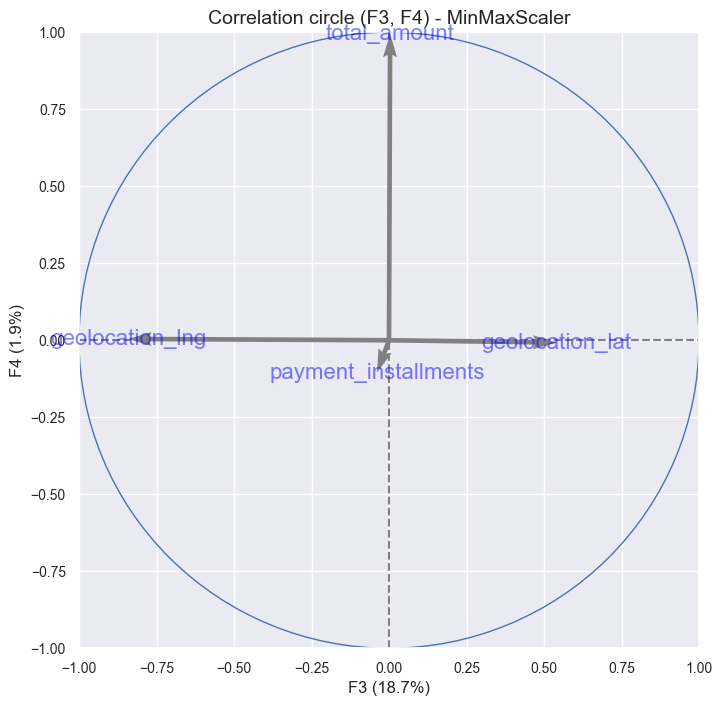

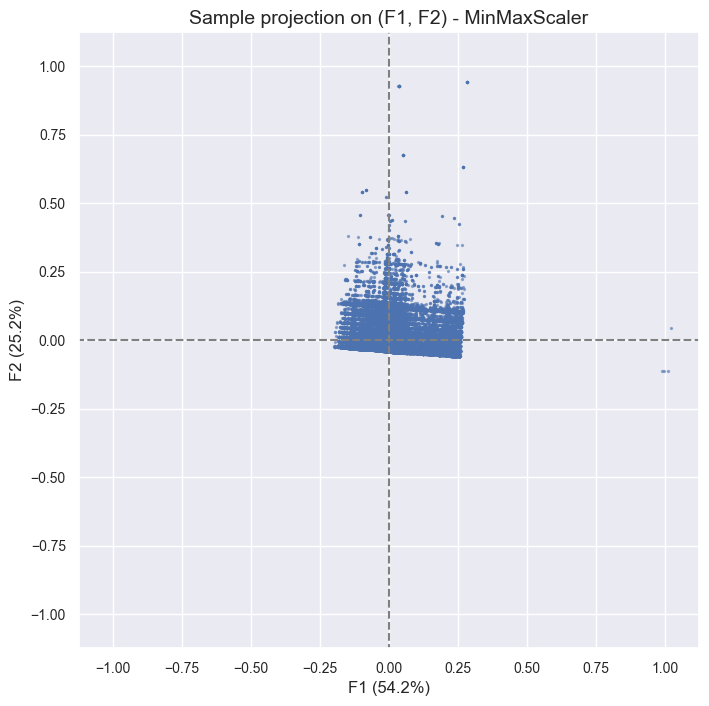

In [452]:
for scaler in [StandardScaler, MinMaxScaler]:
    sc = scaler().fit(X_pca)
    X_scaled = sc.transform(X_pca)

    # Principal components
    pca = PCA(n_components=n_comp)
    pca.fit(X_scaled)
    X_pca_proj = pca.transform(X_scaled)
    
    # Scree plot
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    DisplotML.display_scree_plot(pca, title_suffix=' - '+scaler.__name__)
    
    # Cercle of correlations
    plt.rcParams['figure.figsize'] = [8, 8]
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    pcs = pca.components_
    DisplotML.display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(feat_cols_acp),
                              label_size=16, title_suffix=' - '+scaler.__name__)
    
    # Sample projection
    plt.rcParams['figure.figsize'] = [8, 8]
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    illus_var = None
    nn = None
    X_pca_proj_nn = X_pca_proj[0:nn,:]
    DisplotML.display_factorial_planes(X_pca_proj_nn, n_comp, pca, [(0,1)], alpha=0.5, labels=None,
                             marker='o', s=2 , illustrative_var=illus_var,
#                              xlim=[-2.5,2.5], ylim=[-2.5,2.5] # (F1,F2) : # (F3,F4): # (F5,F6) : xlim=[-3.,7.5], ylim=[-5.,5.5]
                            title_suffix=' - '+scaler.__name__)


#### AFDM (Analyse Factorielle de Données Mixtes)

In [453]:
def make_FAMD_matrix(df_cust, num_cols, cat_cols, scaler):
    """Builds the Mixed Data Factor Analysis matrix.
    
    This matrix is to be presented to the standard PCA method, with a specific normalization of the
    categorical variables.
    
    Parameters
    ----------
    df_cust:pandas.DataFrame
        Dataframe to study.
    num_cols: list
        List of numeric (quantitative) columns.
    cat_cols: list
        List of categorical (qualitative) columns.
    scaler: sklearn.preprocessing
        Scaler to use.
        
    Returns
    -------
    Z: numpy.array
        Standardized matrix to be presented to the ACP.
    
    Notes
    -----
    See http://eric.univ-lyon2.fr/~ricco/cours/cours/Pratique_Methodes_Factorielles.pdf
    and : http://archive.numdam.org/item/RSA_2004__52_4_93_0.pdf
    """
    
    # Numeric part
    DC = df_cust[num_cols]
    print_debug(f"Dataframe des variables quantitatives :\n{DC}", 1, DEBUG_LEVEL)
    ZC = scaler().fit_transform(DC.values)
    print_debug(f"Bloc matriciel des variables quantitatives :\n{ZC}", 1, DEBUG_LEVEL)
    print_debug(ZC, 1, DEBUG_LEVEL)

    # Encoded categorial part
    DDcoding = df_cust[cat_cols]
    print_debug(f"Dataframe des variables qualitatives :\n{DDcoding}", 1, DEBUG_LEVEL)
    
    # Proportions
    p_k = np.mean(DDcoding.values, axis=0)
    print_debug(f"Proportions de valeur 1 des indicatrices : {p_k}", 1, DEBUG_LEVEL)
    # Specific normalization
    ZD = DDcoding.values/np.sqrt(p_k)
    print_debug(f"Bloc matriciel des variables qualitatives :\n{ZD}", 1, DEBUG_LEVEL)
    print_debug(ZD, 1, DEBUG_LEVEL)

    # Assembly of the two blocks
    Z = np.concatenate((ZC,ZD), axis=1)
    print_debug(f"Bloc matriciel complet :\n{Z}", 1, DEBUG_LEVEL)
    
    return Z

In [454]:
num_cols = ['total_amount',  # 'mean_amount',
#              'nb_items',
             'nb_orders',
             # 'nb_items_mean',
             'mean_rev_score',
             'payment_installments',
#              'order_purchase_recency_sec',
#              'order_purchase_recency_15d',
#              'order_purchase_recency_01d',
           ]
cat_cols = list(payment_types) + list(prod_categs_macro)# + list(regions) 

feat_cols_afdm = num_cols + cat_cols

In [455]:
Z = make_FAMD_matrix(df_cust, num_cols, cat_cols, scaler)

# PCA with the standard method
n_comp = 6
pca_afdm = PCA(n_components=n_comp)

pca_afdm.fit(Z)
X_afdm_proj = pca_afdm.transform(Z)

In [456]:
df_cust['last_categ'].isna().sum()

0

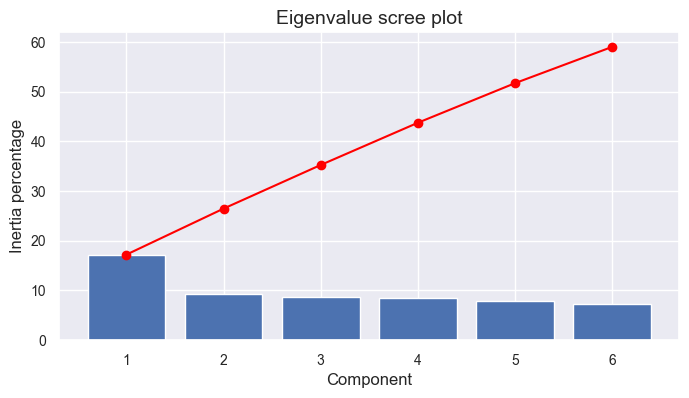

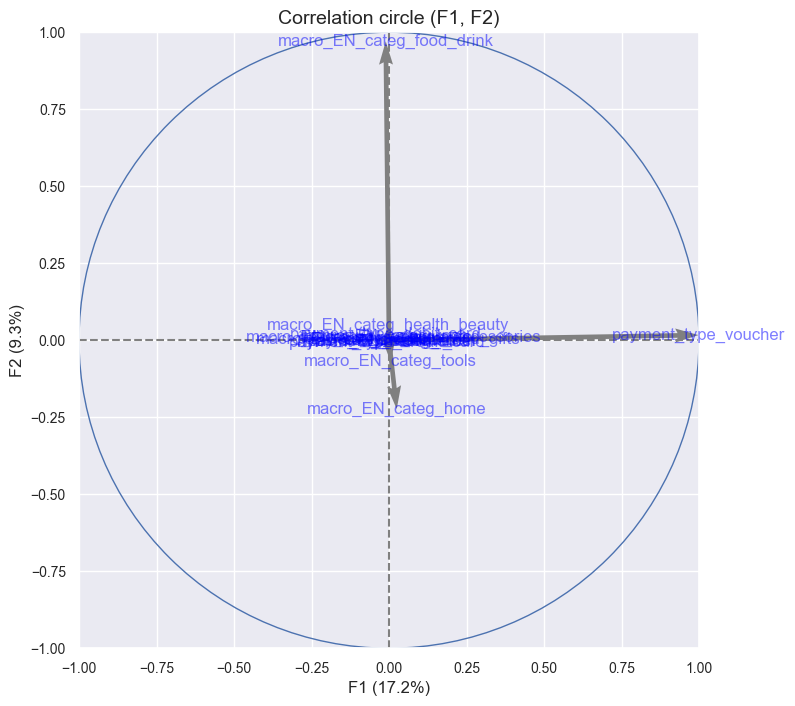

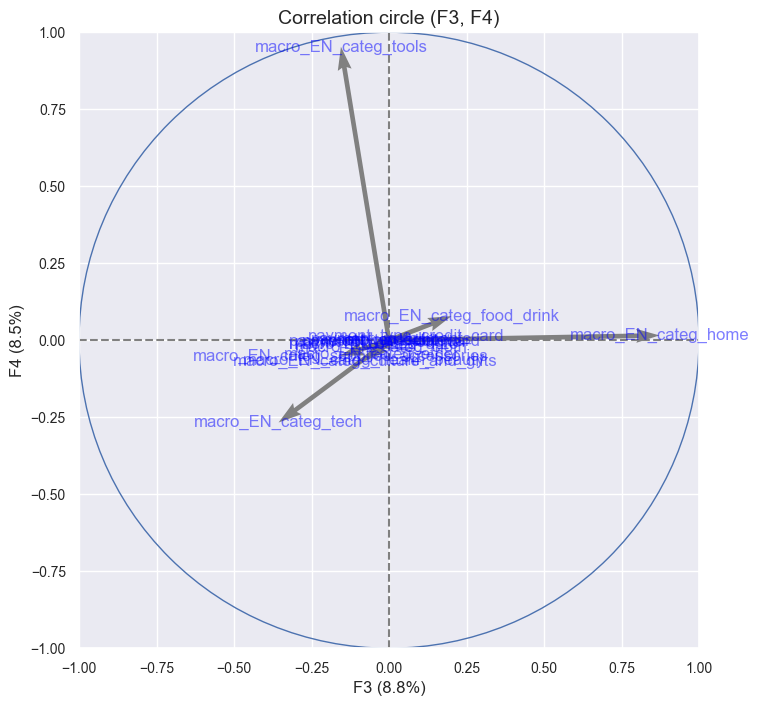

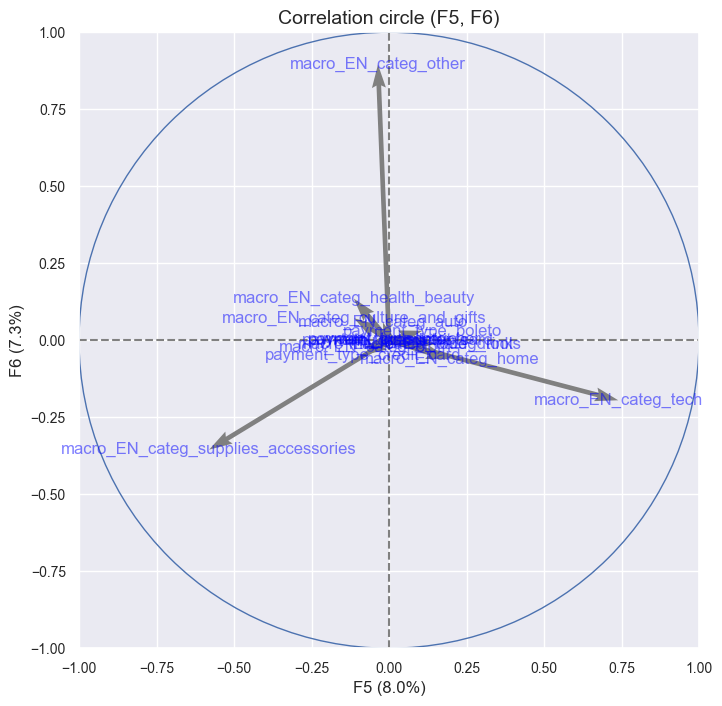

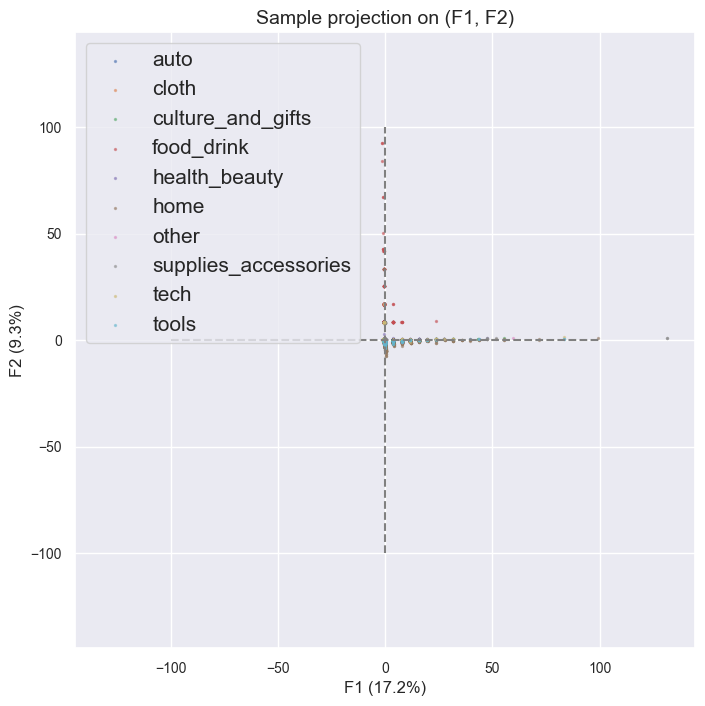

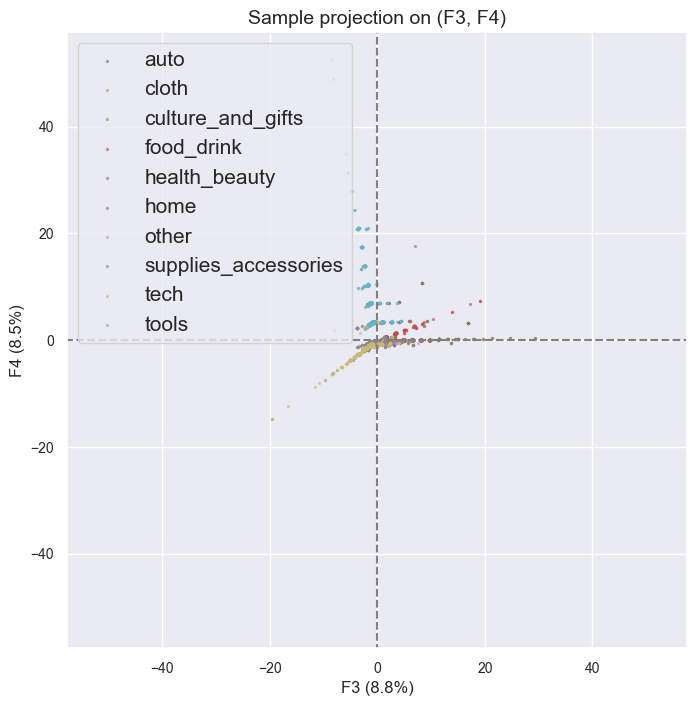

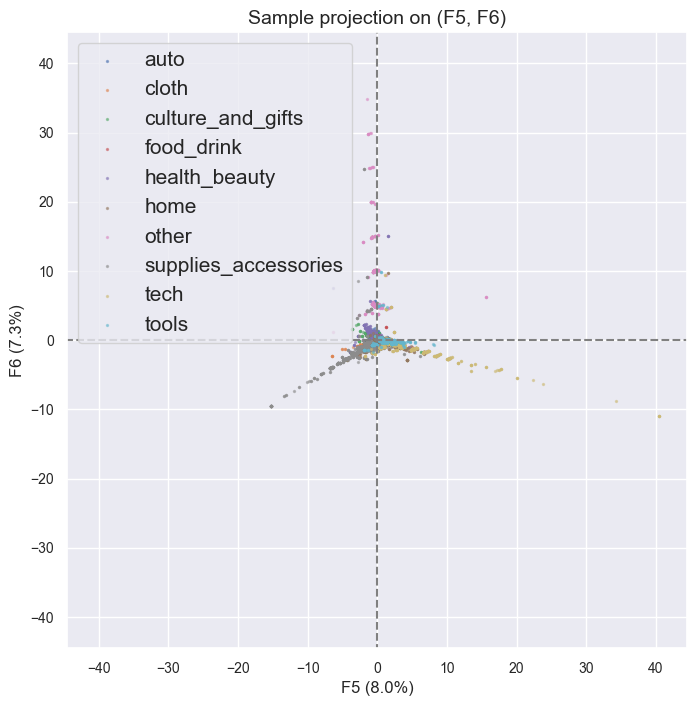

In [458]:
# Scree plot
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
DisplotML.display_scree_plot(pca_afdm)

# Cercle of correlations
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
pcs_afdm = pca_afdm.components_
DisplotML.display_circles(pcs_afdm, n_comp, pca_afdm, [(0,1),(2,3),(4,5)], labels = np.array(feat_cols_afdm),
                          label_size=12)

# Sample projection
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
illus_var = df_cust['last_categ'].values
nn = None
X_pca_proj_nn = X_pca_proj[0:nn,:]
DisplotML.display_factorial_planes(X_afdm_proj, n_comp, pca_afdm, [(0,1),(2,3),(4,5)], alpha=0.5, labels=None,
                         marker='o', s=2 , illustrative_var=illus_var,
#                              xlim=[-2.5,2.5], ylim=[-2.5,2.5] # (F1,F2) : # (F3,F4): # (F5,F6) : xlim=[-3.,7.5], ylim=[-5.,5.5]
                        )

In [459]:
resu_cols = ["Attribute", 
             "F1 - Coord", "F1 - CTR (%)", "F1 - QLT (%)", "F1 - Cumul QLT (%)",
             "F2 - Coord", "F2 - CTR (%)", "F2 - QLT (%)", "F2 - Cumul QLT (%)"]

In [460]:
pca_afdm.explained_variance_ratio_

array([0.1721756 , 0.09258942, 0.08784893, 0.08497767, 0.07968617,
       0.07306733])

In [461]:
pcs_afdm[:,0].sum()

0.0009032240109204958

#### AFDM avec ` fanalysis`

In [462]:
pca_fafdm = fanalysis.pca.PCA(
    std_unit=False, row_labels=df_cust.index, col_labels=feat_cols_afdm)
pca_fafdm.fit(Z)
X_fafdm_proj = pca_fafdm.transform(Z)

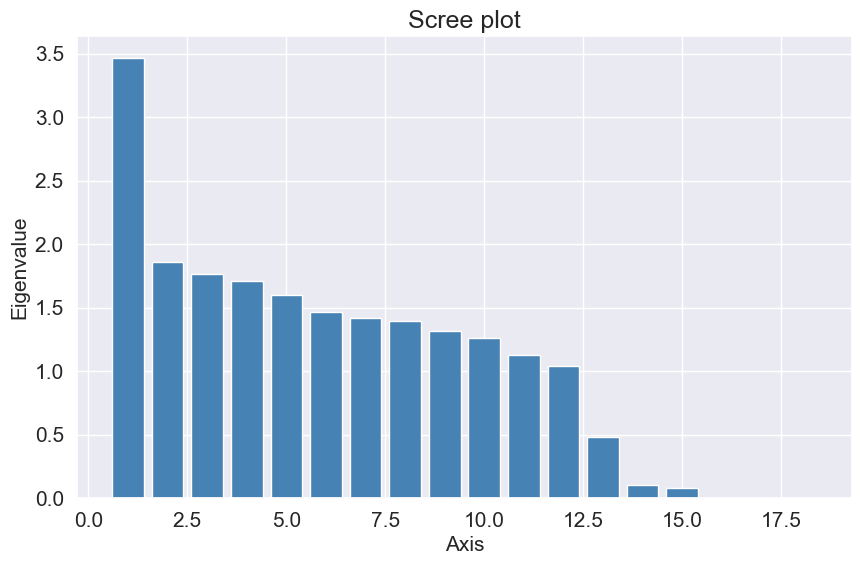

In [463]:
# Scree plot
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
pca_fafdm.plot_eigenvalues()

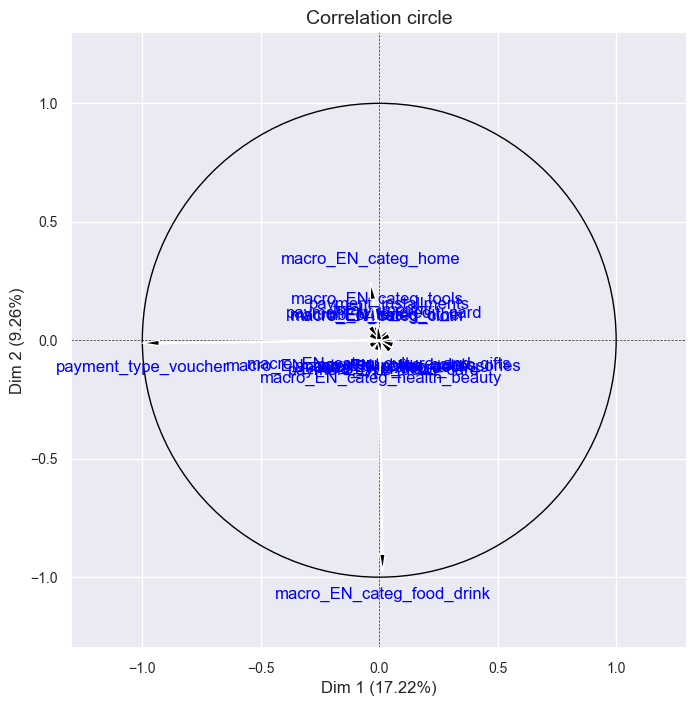

In [464]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
pca_fafdm.correlation_circle(1,2)

In [465]:
# Eigenvalues
print(pca_fafdm.eig_[0])

[3.46290772e+00 1.86221873e+00 1.76687482e+00 1.70912631e+00
 1.60270004e+00 1.46957762e+00 1.42252311e+00 1.39840258e+00
 1.32005459e+00 1.25871293e+00 1.12617733e+00 1.04042225e+00
 4.84638239e-01 1.03718143e-01 8.19056587e-02 2.38866343e-03
 2.24896954e-04 7.73216771e-05]


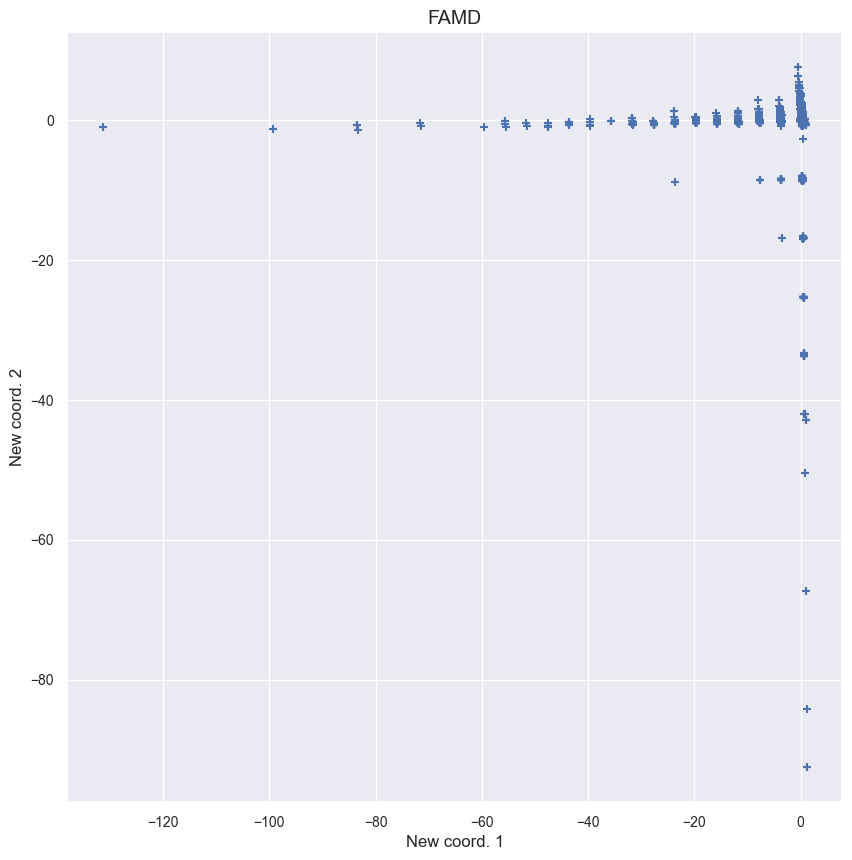

In [467]:
# Sample projection
%matplotlib inline
df_plt = pd.DataFrame(pca_fafdm.row_coord_[:,:2],
                      columns=['F1','F2'],
                      index=df_cust[feat_cols_afdm].index)
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.figure()
plt.scatter(df_plt['F1'], df_plt['F2'],marker='+')
plt.title("FAMD")
plt.xlabel("New coord. 1")
plt.ylabel("New coord. 2")
plt.show()

#### AFDM du module `prince`

In [468]:
num_cols = ['total_amount',  # 'mean_amount',
#              'nb_items',
             'nb_orders',
             # 'nb_items_mean',
             'mean_rev_score',
             'payment_installments',
#              'order_purchase_recency_sec',
#              'order_purchase_recency_15d',
#              'order_purchase_recency_01d',
           ]
cat_cols = list(payment_types) + list(prod_categs_macro) + list(regions) 
cat_cols_raw = ['last_categ', 'customer_region'] #'payment_inst_cat', 'customer_region', 'first_payment_type', 

feat_cols_famd = num_cols + cat_cols_raw

<AxesSubplot: title={'center': 'Row principal coordinates'}, xlabel='Component 0 (8.53% inertia)', ylabel='Component 1 (7.30% inertia)'>

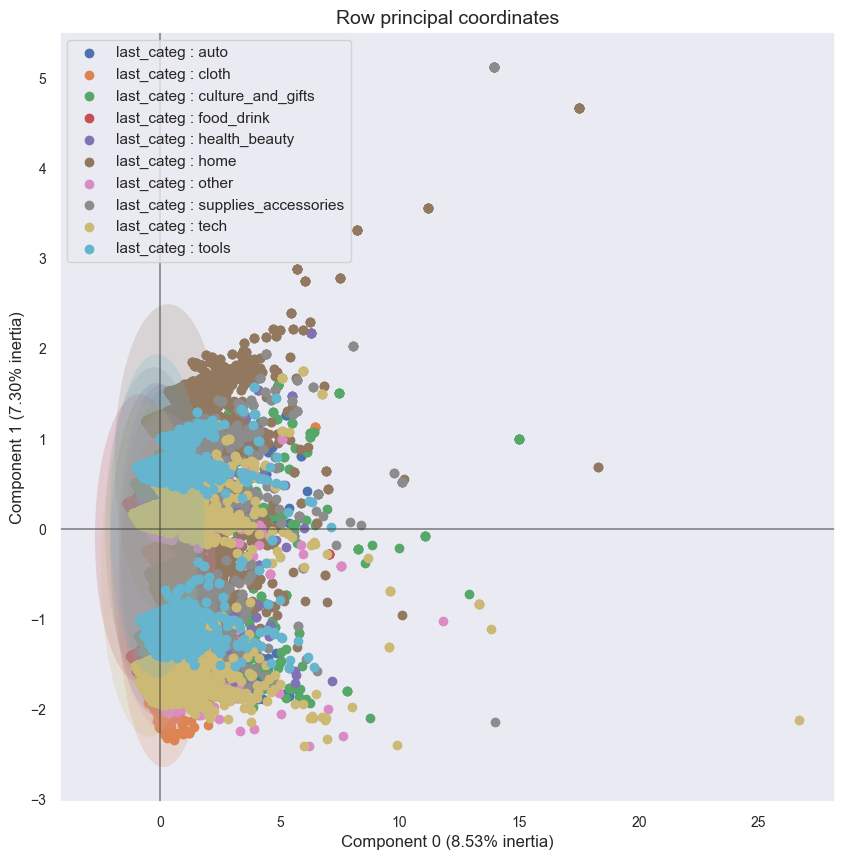

In [470]:
famd = FAMD(n_components=2, n_iter=3, random_state=18011975)
X_famd = df_cust[feat_cols_famd]
famd.fit(X_famd)
famd.transform(X_famd)
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
famd.plot_row_coordinates(X_famd, figsize=(10, 10), 
                          color_labels=['last_categ : {}'.format(t) for t in X_famd['last_categ']] )

<AxesSubplot: title={'center': 'Row principal coordinates'}, xlabel='Component 0 (8.53% inertia)', ylabel='Component 1 (7.30% inertia)'>

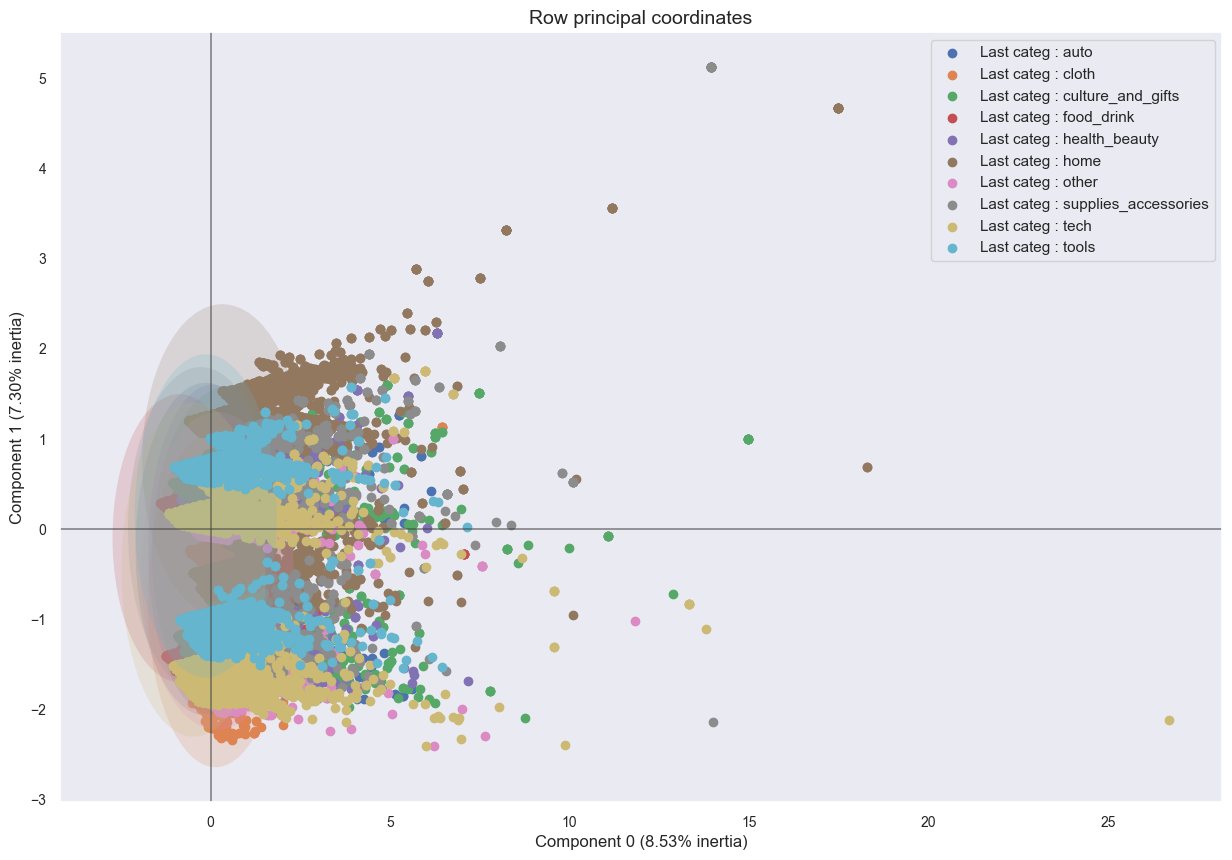

In [471]:
famd.plot_row_coordinates(X_famd, figsize=(15, 10), 
                          color_labels=['Last categ : {}'.format(t) for t in X_famd['last_categ']] )

#### k-PCA

In [472]:
if 0:
    transformer = KernelPCA(n_components=2, kernel='rbf')
    X_transformed = transformer.fit_transform(X_scaled)
    fig = plt.figure()
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1])

Hi hi hi : pas assez de mémoire.

### DOE d'études multivariées

Lançons un plan d'expériences avec quelques combinaisons de variables et de scalers. En vue de visualiser les données sous forme de groupes/grappes. 

In [473]:
scalers = [StandardScaler] #, MinMaxScaler

models_cols_and_FA = [
    ## ----
    ## PCA
    ## ----
#     # Simpliste (2 vars)
#     {'num_cols': ['total_amount', 'nb_items',
#                  ],
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Simpliste 2
#     {'num_cols': ['total_amount', 'nb_orders',
#                  ],
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Simpliste 3
#     {'num_cols': ['total_amount', 'payment_installments',
#                  ],
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Simpliste 4
#     {'num_cols': ['total_amount', 'mean_rev_score',
#                  ],
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Simpliste 5
#     {'num_cols': ['mean_amount_per_order', 'mean_rev_score',
#                  ],
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Simpliste 6
#     {'num_cols': ['mean_amount_per_item', 'mean_rev_score',
#                  ],
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Simple (3 vars)
#     {'num_cols': ['total_amount', 'nb_items',
#                   'nb_orders',
#                  ],
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Simple 2
#     {'num_cols': ['total_amount', 'nb_items',
#                   'mean_rev_score',
#                  ],
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Simple 3
#     {'num_cols': ['total_amount', 'nb_items',
#                   'payment_installments',
#                  ],
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Simple 4
#     {'num_cols': ['total_amount', 'nb_items',
#                  ]+payment_types_ratio_cols,
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Simple 5
#     {'num_cols': ['mean_amount_per_order',
#                   'mean_rev_score',
#                  ]+payment_types_ratio_cols,
#      'cat_cols': [],
#      'FA'      : 'PCA'},
    # Simple 6
    {'num_cols': ['mean_amount_per_item',
                  'mean_rev_score',
                 ]+payment_types_ratio_cols_all_cards,
     'cat_cols': [],
     'FA'      : 'PCA'},
#     # Simple 7
#     {'num_cols': ['mean_amount_per_order',
#                   'mean_rev_score',
#                   'payment_installments',
#                  ],
#      'cat_cols': [],
#      'FA'      : 'PCA'},
    # Simple 8
    {'num_cols': ['mean_amount_per_item',
                  'mean_rev_score',
                  'payment_installments',
                 ],
     'cat_cols': [],
     'FA'      : 'PCA'},
#     # Moyen (4 vars)
#     {'num_cols': ['total_amount', 'nb_items',
#                   'mean_rev_score',
#                  ]+payment_types_ratio_cols,
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Moyen 2
#     {'num_cols': ['total_amount', 'nb_items',
#                   'mean_rev_score',
#                   'payment_installments',
#                  ],
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Moyen 3
#     {'num_cols': ['total_amount', 'nb_items',
#                   'payment_installments',
#                  ]+payment_types_ratio_cols,
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Moyen 4
#     {'num_cols': ['total_amount', 'nb_items',
#                   'mean_rev_score',
#                   'payment_installments',
#                   'geolocation_lat', 'geolocation_lng', # (elles vont de pair)
#                  ],
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Moyen 5
#     {'num_cols': ['total_amount', 'nb_items',
#                   'mean_rev_score',
#                   'payment_installments',
#                  ]+payment_types_ratio_cols,
#      'cat_cols': [],
#      'FA'      : 'PCA'},
    # Moyen 6
#     {'num_cols': ['mean_amount_per_order',
#                   'mean_rev_score',
# #                   'payment_installments',
#                   'geolocation_lat', 'geolocation_lng',
# #                   'order_purchase_recency_15d'
# #                   'order_purchase_recency_01d'
#                  ]+payment_types_ratio_cols,
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Moyen 7
#     {'num_cols': ['mean_amount_per_item',
#                   'mean_rev_score',
# #                   'payment_installments',
#                   'geolocation_lat', 'geolocation_lng',
# #                   'order_purchase_recency_15d'
# #                   'order_purchase_recency_01d'
#                  ]+payment_types_ratio_cols,
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Moyen 8
#     {'num_cols': ['mean_amount_per_order',
#                   'mean_rev_score',
# #                   'payment_installments',
# #                   'geolocation_lat', 'geolocation_lng',
# #                   'order_purchase_recency_15d'
#                   'order_purchase_recency_01d'
#                  ]+payment_types_ratio_cols,
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Moyen 9
#     {'num_cols': ['mean_amount_per_item',
#                   'mean_rev_score',
# #                   'payment_installments',
# #                   'geolocation_lat', 'geolocation_lng',
# #                   'order_purchase_recency_15d'
#                   'order_purchase_recency_01d'
#                  ]+payment_types_ratio_cols,
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Moyen 10
#     {'num_cols': ['mean_amount_per_order',
#                   'mean_rev_score',
#                   'payment_installments',
#                  ]+payment_types_ratio_cols,
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Moyen 11
#     {'num_cols': ['mean_amount_per_item',
#                   'mean_rev_score',
#                   'payment_installments',
#                  ]+payment_types_ratio_cols,
#      'cat_cols': [],
#      'FA'      : 'PCA'},
    # Moyen 12
    {'num_cols': ['mean_amount_per_order',
                  'mean_rev_score',
                  'payment_installments',
                 ]+payment_types_ratio_cols_all_cards,
     'cat_cols': [],
     'FA'      : 'PCA'},
    # Moyen 13
    {'num_cols': ['mean_amount_per_item',
                  'mean_rev_score',
                  'payment_installments',
                 ]+payment_types_ratio_cols_all_cards,
     'cat_cols': [],
     'FA'      : 'PCA'},
#     # Complexe (5 vars)
#     {'num_cols': ['total_amount', 'nb_items',
#                   'mean_rev_score',
#                   'payment_installments',
#                  ]+payment_types_ratio_cols,
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Complexe 2
#     {'num_cols': ['total_amount', 'nb_items',
#                   'mean_rev_score',
# #                   'payment_installments',
#                   'geolocation_lat', 'geolocation_lng',
# #                   'order_purchase_recency_15d'
# #                   'order_purchase_recency_01d'
#                  ]+payment_types_ratio_cols,
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Complexe 3
#     {'num_cols': ['total_amount', 'nb_items',
#                   'mean_rev_score',
# #                   'payment_installments',
# #                   'geolocation_lat', 'geolocation_lng',
# #                   'order_purchase_recency_15d'
#                   'order_purchase_recency_01d'
#                  ]+payment_types_ratio_cols,
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Complexe 4
#     {'num_cols': ['mean_amount_per_order',
#                   'mean_rev_score',
#                   'payment_installments',
# #                   'geolocation_lat', 'geolocation_lng',
# #                   'order_purchase_recency_15d'
#                   'order_purchase_recency_01d'
#                  ]+payment_types_ratio_cols,
#      'cat_cols': [],
#      'FA'      : 'PCA'},
#     # Complexe 5
#     {'num_cols': ['mean_amount_per_item',
#                   'mean_rev_score',
#                   'payment_installments',
# #                   'geolocation_lat', 'geolocation_lng',
# #                   'order_purchase_recency_15d'
#                   'order_purchase_recency_01d'
#                  ]+payment_types_ratio_cols,
#      'cat_cols': [],
#      'FA'      : 'PCA'},
    # Complexe 6
    {'num_cols': ['mean_amount_per_order',
                  'mean_rev_score',
                  'payment_installments',
#                   'geolocation_lat', 'geolocation_lng',
#                   'order_purchase_recency_15d'
                  'order_purchase_recency_01d'
                 ]+payment_types_ratio_cols_all_cards,
     'cat_cols': [],
     'FA'      : 'PCA'},
    # Complexe 7
    {'num_cols': ['mean_amount_per_item',
                  'mean_rev_score',
                  'payment_installments',
#                   'geolocation_lat', 'geolocation_lng',
#                   'order_purchase_recency_15d'
                  'order_purchase_recency_01d'
                 ]+payment_types_ratio_cols_all_cards,
     'cat_cols': [],
     'FA'      : 'PCA'},
    
#     ## ----
#     ## AFDM via normalisation manuelle des catég. et PCA standard
#     ## ----
#     # Simpliste
#     {'num_cols': ['total_amount', 'nb_items',
#                  ],
#      'cat_cols': list(regions),
#      'FA'      : 'AFDM'},
#     # Simple
#     {'num_cols': ['total_amount', 'nb_items',
#                   'mean_rev_score',
#                  ],
#      'cat_cols': list(payment_types),
#      'FA'      : 'AFDM'},
#     # Simple 2
#     {'num_cols': ['total_amount', 'nb_items',
#                   'mean_rev_score',
#                  ]+payment_types_ratio_cols,
#      'cat_cols': list(prod_categs_macro),
#      'FA'      : 'AFDM'},
#     # Moyen
#     {'num_cols': ['total_amount', 'nb_items',
#                   'mean_rev_score',
#                   'payment_installments',
#                  ],
#      'cat_cols': list(payment_types),
#      'FA'      : 'AFDM'},
#     # Moyen 2
#     {'num_cols': ['total_amount', 'nb_items',
#                   'mean_rev_score',
#                   'payment_installments',
#                  ],
#      'cat_cols': list(payment_types)+list(prod_categs_macro),
#      'FA'      : 'AFDM'},
#     # Complexe
#     {'num_cols': ['total_amount', 'nb_items',
#                   'mean_rev_score',
#                   'payment_installments',
#                   'geolocation_lat', 'geolocation_lng',
#                   'order_purchase_recency_15d'
#                   'order_purchase_recency_01d'
#                  ],
#      'cat_cols': list(payment_types)+list(prod_categs_macro),
#      'FA'      : 'AFDM'},

#     ## ----
#     ## prince.FAMD
#     ## ----
#     # Simpliste
#     {'num_cols': ['total_amount', 'nb_items',
#                  ],
#      'cat_cols': ['customer_region'],
#      'FA'      : 'prince.FAMD'},
#     # Simple
#     {'num_cols': ['total_amount', 'nb_items',
#                   'mean_rev_score',
#                  ],
#      'cat_cols': ['first_payment_type'],
#      'FA'      : 'prince.FAMD'},
#     # Moyen
#     {'num_cols': ['total_amount', 'nb_items',
#                   'mean_rev_score',
#                   'geolocation_lat', 'geolocation_lng'
#                  ],
#      'cat_cols': ['first_payment_type', 'last_categ'],
#      'FA'      : 'prince.FAMD'},
#     # Complexe
#     {'num_cols': ['total_amount', 'nb_items',
#                   'mean_rev_score',
#                   'order_purchase_recency_15d'
#                   'order_purchase_recency_01d'
#                  ],
#      'cat_cols': ['first_payment_type', 'payment_inst_cat', 'last_categ', 'customer_region'],
#      'FA'      : 'prince.FAMD'}
]

In [474]:
chosen_models_cols_and_FA = models_cols_and_FA[:] #[5:6]# [2:6:3]

In [475]:
doe = list(itertools.product(scalers, chosen_models_cols_and_FA))
columns = ['Scaler', 'Variables']
df_doe = pd.DataFrame(data=doe, columns=columns)
df_doe_init = df_doe.copy()

In [478]:
def launch_FA_DOE(df_doe_init):
    """Launches a plan of Factorial Analysis experiments.
    
    Parameters
    ----------
    df_doe_init: pandas.DataFrame
        First string to concatenate.
    b: str, optional
        Second string to concatenate.

    Returns
    -------
    c: str
        Concatenated string.
    """
    # Loop on the problems to be solved, i.e. the lines of df_doe
    for ind in df_doe.index:
        problem = df_doe.loc[ind]
        num_cols = problem['Variables']['num_cols']
        cat_cols = problem['Variables']['cat_cols']
        fact_analysis = problem['Variables']['FA']
        scaler = problem['Scaler']

        # Set of columns forming the features
        feat_cols = cat_cols + num_cols

        print(bcolors.BOLD+bcolors.HEADER+'-'*100+f"\n{num_cols} ; {cat_cols}\n"+'-'*100+"\n\n"+bcolors.ENDC)
        title_prefix = fact_analysis+' : '
        title_suffix = ' - '+scaler.__name__
        if fact_analysis=='PCA':
            n_comp = len(num_cols)
            n_plans = [(2*k, 2*k+1) for k in range((n_comp//2))]
            n_plans = [(0,1)] # DEBUG
            
            X = df_cust[feat_cols].values
            sc = scaler().fit(X)
            X_scaled = sc.transform(X)

            # PCA
            pca = PCA(n_components=n_comp)
            pca.fit(X_scaled)
            X_pca_proj = pca.transform(X_scaled)
            
            # Scree plot
            plt.rcParams['figure.figsize'] = [8, 6]
            DisplotML.display_scree_plot(pca, title_prefix=title_prefix, title_suffix=title_suffix)

            # Cercle of correlations
            plt.rcParams['figure.figsize'] = [8, 8]
            pcs = pca.components_
            DisplotML.display_circles(pcs, n_comp, pca, n_plans, labels=np.array(feat_cols),
                                      label_size=16, title_prefix=title_prefix, title_suffix=title_suffix)

            # Sample projection
            plt.rcParams['figure.figsize'] = [8, 8]
            illus_var = None
            nn = None
            X_pca_proj_nn = X_pca_proj[0:nn, :]
            DisplotML.display_factorial_planes(X_pca_proj_nn, n_comp, pca, n_plans, alpha=0.5, labels=None,
                                               marker='o', s=2, illustrative_var=illus_var,
                                               title_prefix=title_prefix, title_suffix=title_suffix)
            pass

        elif fact_analysis=='AFDM':
            n_comp = len(feat_cols)
            n_plans = [(2*k, 2*k+1) for k in range((n_comp//2)) ]
            n_plans = [(0,1)] # DEBUG

            Z = make_FAMD_matrix(df_cust, num_cols, cat_cols, scaler)

            # PCA with the standard method
            n_comp = 6
            pca_afdm = PCA(n_components=n_comp)

            pca_afdm.fit(Z)
            X_afdm_proj = pca_afdm.transform(Z)
            
            # Scree plot
            DisplotML.display_scree_plot(pca_afdm, title_prefix=title_prefix, title_suffix=title_suffix)

            # Cercle of correlations
            plt.rcParams['figure.figsize'] = [8, 8]
            pcs_afdm = pca_afdm.components_
            DisplotML.display_circles(pcs_afdm, n_comp, pca_afdm, n_plans, labels = np.array(feat_cols),
                                      label_size=12, title_prefix=title_prefix, title_suffix=title_suffix)

            # Sample projections
            plt.rcParams['figure.figsize'] = [8, 8]
            illus_var = df_cust[cat_cols[0]].values if len(cat_cols) else None
            nn = None
            X_pca_proj_nn = X_pca_proj[0:nn,:]
            DisplotML.display_factorial_planes(X_afdm_proj, n_comp, pca_afdm, n_plans, alpha=0.5, labels=None,
            #                              xlim=[-2.5,2.5], ylim=[-2.5,2.5] # (F1,F2) : # (F3,F4): # (F5,F6) : xlim=[-3.,7.5], ylim=[-5.,5.5]
                                     marker='o', s=2 , illustrative_var=illus_var,
                                     title_prefix=title_prefix, title_suffix=title_suffix)
            pass
        
        elif fact_analysis=='prince.FAMD':
            n_comp = len(feat_cols)
            n_plans = [(2*k, 2*k+1) for k in range((n_comp//2)) ]
            n_plans = [(0,1)] # DEBUG
            
            famd = FAMD(n_components=n_comp, n_iter=3, random_state=18011975)
            X_famd = df_cust[feat_cols]
            famd.fit(X_famd)
            famd.transform(X_famd)
            # Scree plot
            famd.explained_variance_ratio_ = famd.explained_inertia_
            DisplotML.display_scree_plot(famd, title_prefix=title_prefix, title_suffix=title_suffix)
            # Cercle of correlations
            famd.components_ = famd.column_correlations(X_famd).values
            DisplotML.display_circles(famd.components_, n_comp, famd, n_plans, labels = np.array(feat_cols),
                                      label_size=12, title_prefix=title_prefix, title_suffix=title_suffix)
            # Sample projections
            famd.plot_row_coordinates(X_famd, figsize=(8, 8), 
                                      color_labels=[f"{cat_cols[0]} : {t}" for t in X_famd[cat_cols[0]]] )
            plt.show()
            pass

----------------------------------------------------------------------------------------------------
['mean_amount_per_item', 'mean_rev_score', 'voucher_ratio', 'boleto_ratio', 'all_card_ratio'] ; []
----------------------------------------------------------------------------------------------------




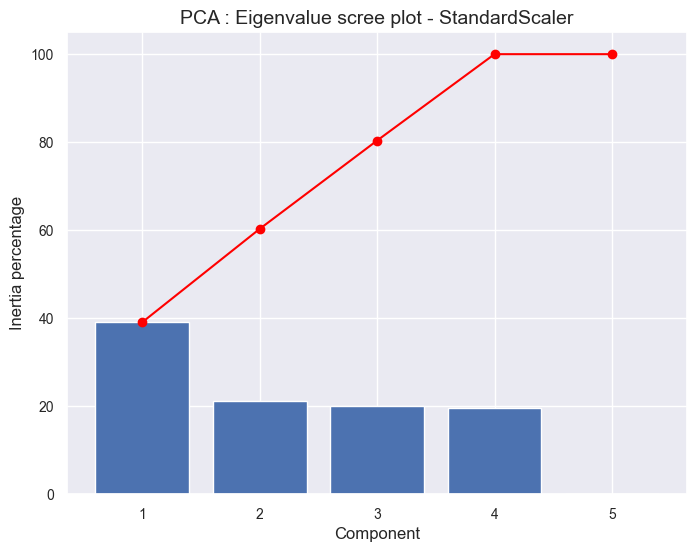

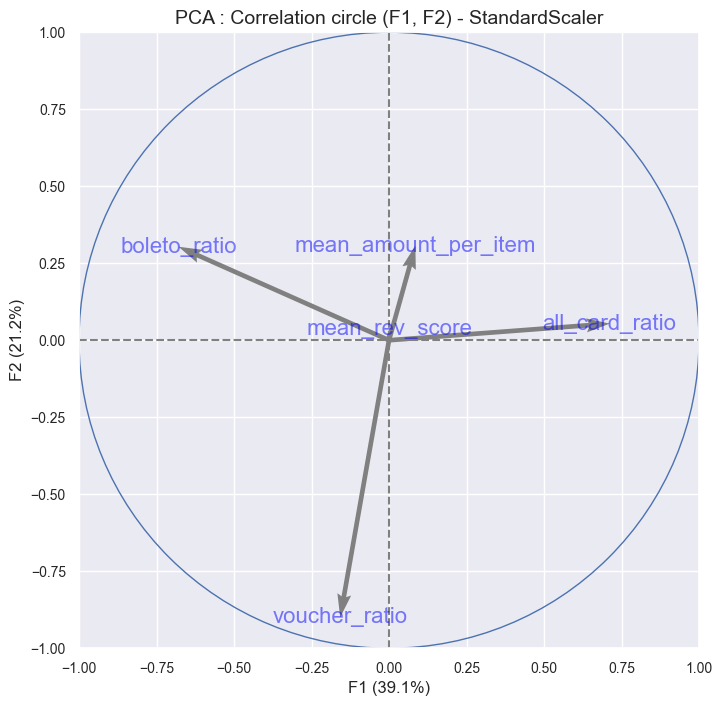

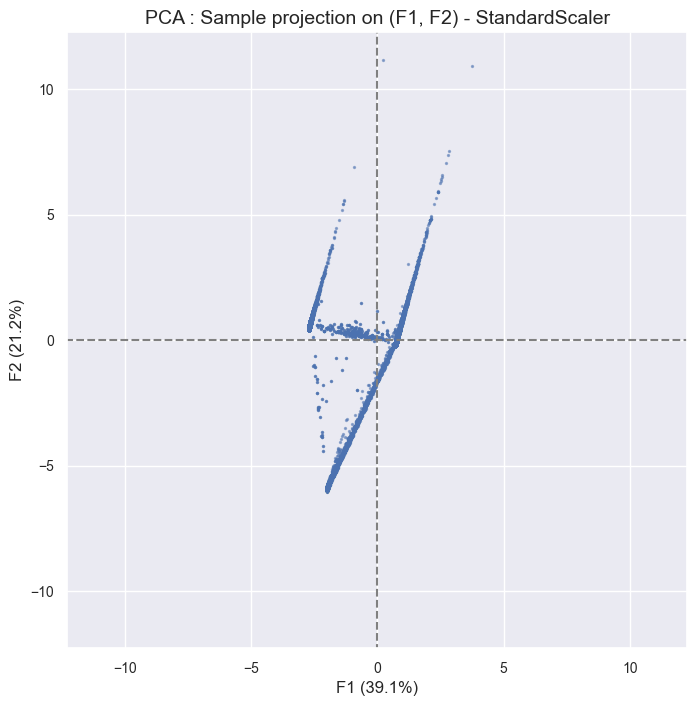

----------------------------------------------------------------------------------------------------
['mean_amount_per_item', 'mean_rev_score', 'payment_installments'] ; []
----------------------------------------------------------------------------------------------------




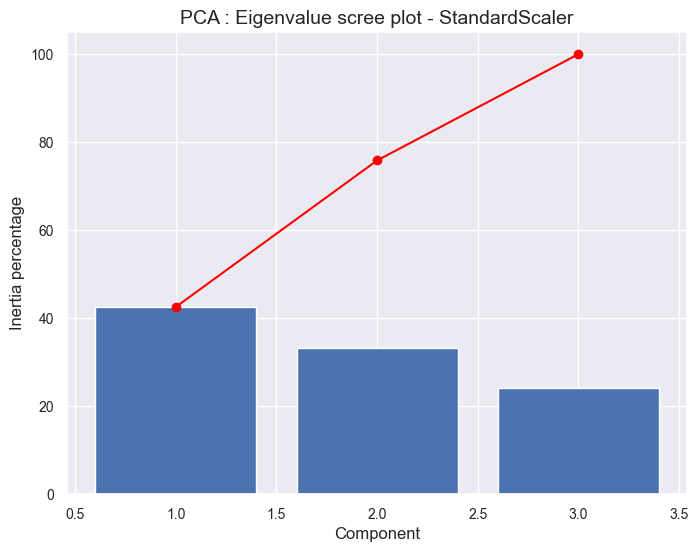

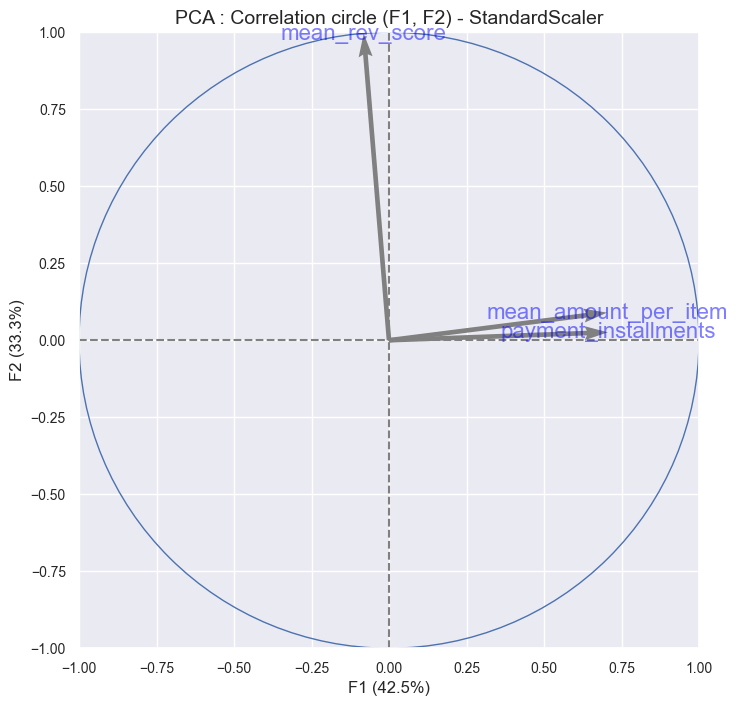

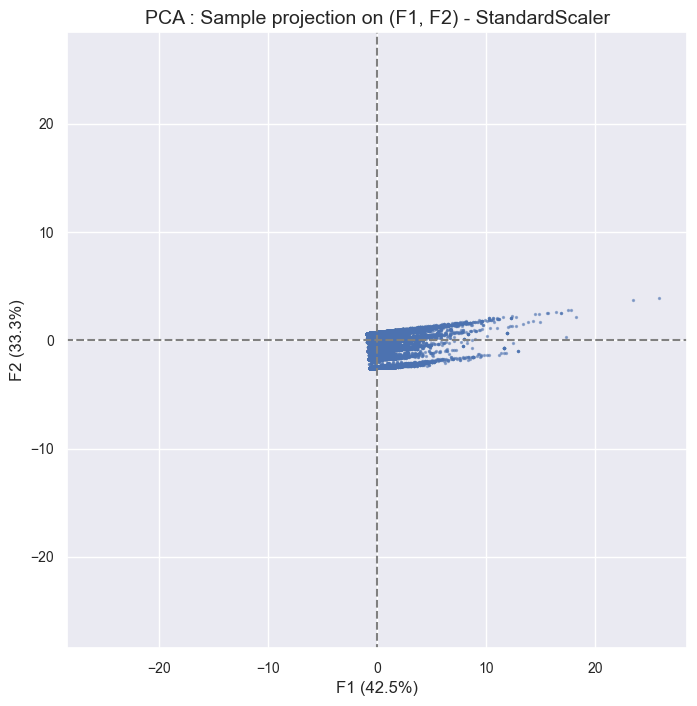

----------------------------------------------------------------------------------------------------
['mean_amount_per_order', 'mean_rev_score', 'payment_installments', 'voucher_ratio', 'boleto_ratio', 'all_card_ratio'] ; []
----------------------------------------------------------------------------------------------------




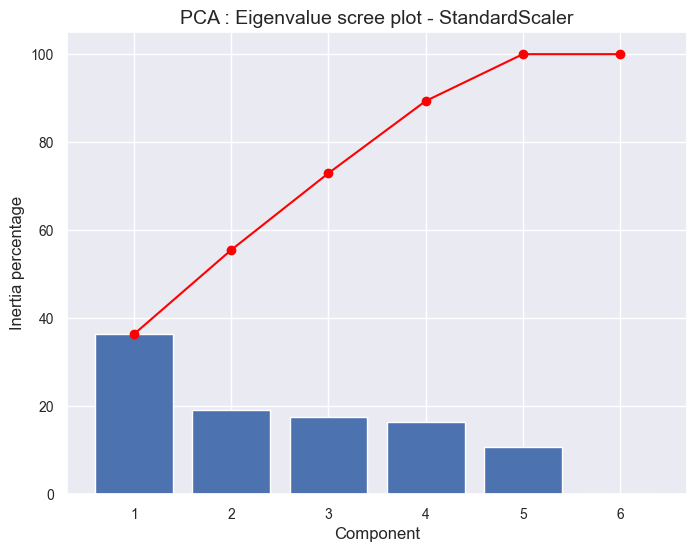

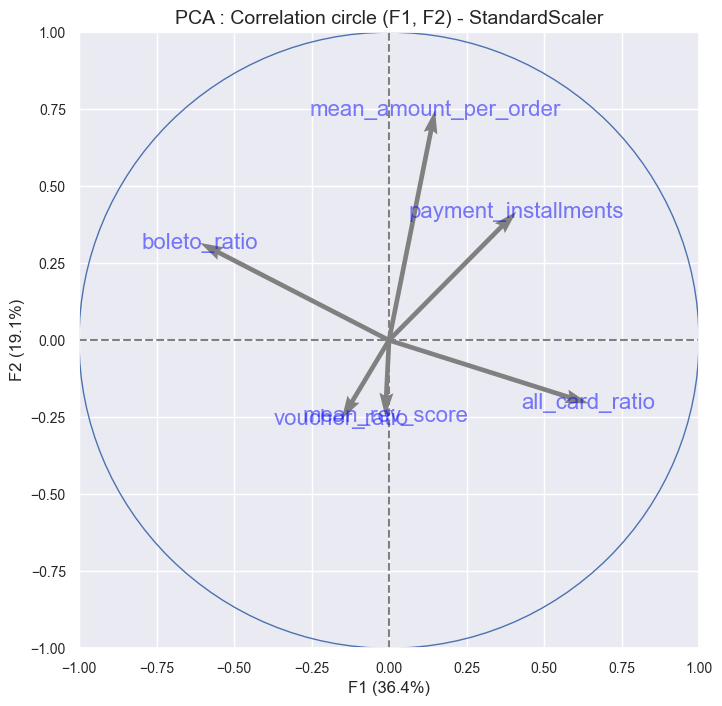

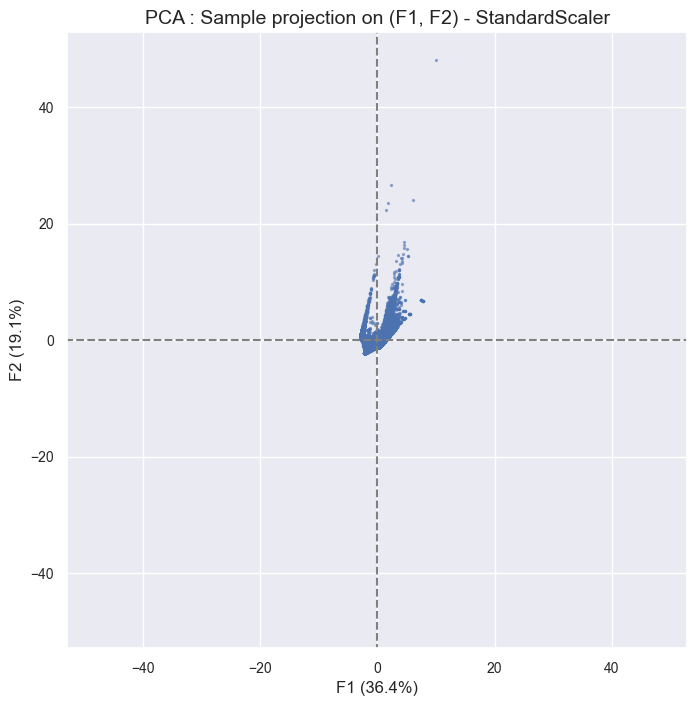

----------------------------------------------------------------------------------------------------
['mean_amount_per_item', 'mean_rev_score', 'payment_installments', 'voucher_ratio', 'boleto_ratio', 'all_card_ratio'] ; []
----------------------------------------------------------------------------------------------------




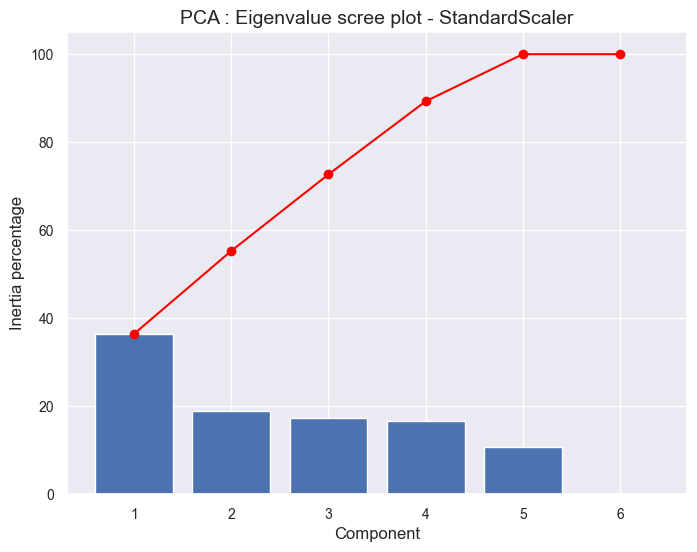

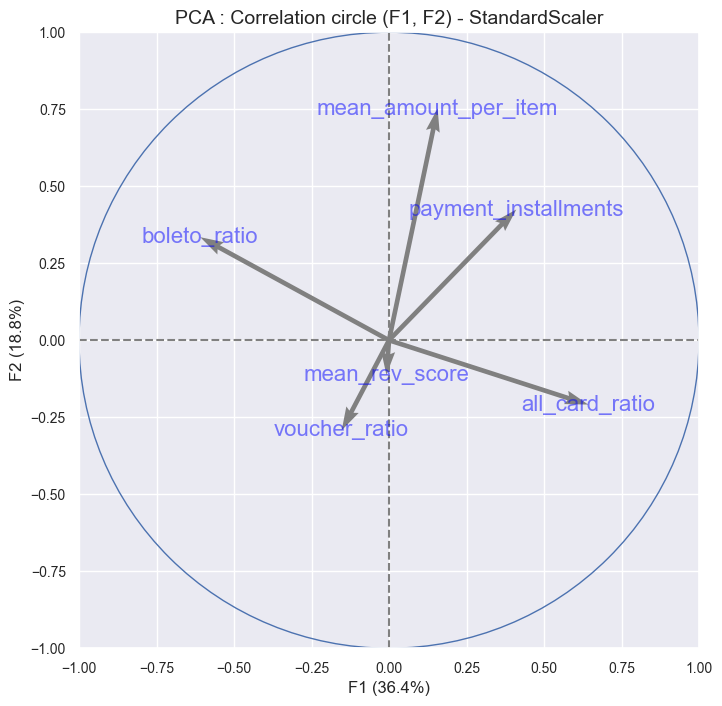

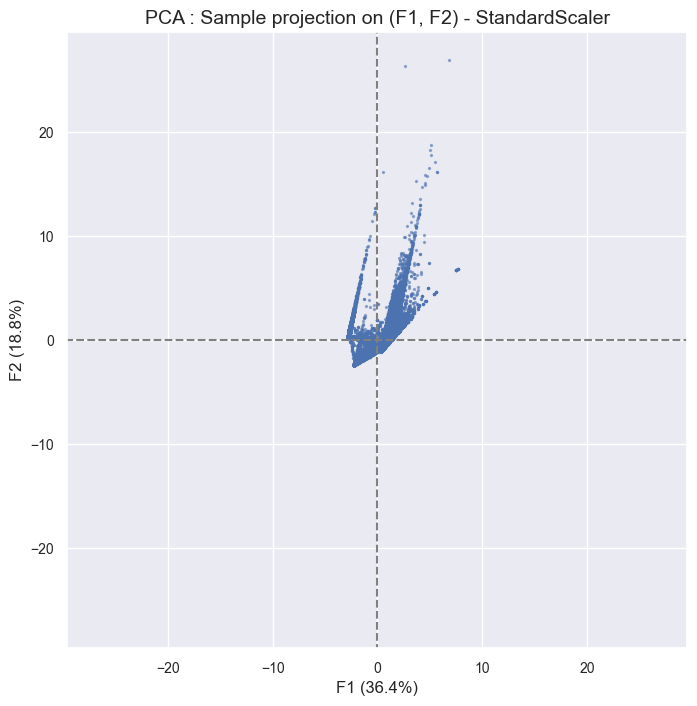

----------------------------------------------------------------------------------------------------
['mean_amount_per_order', 'mean_rev_score', 'payment_installments', 'order_purchase_recency_01d', 'voucher_ratio', 'boleto_ratio', 'all_card_ratio'] ; []
----------------------------------------------------------------------------------------------------




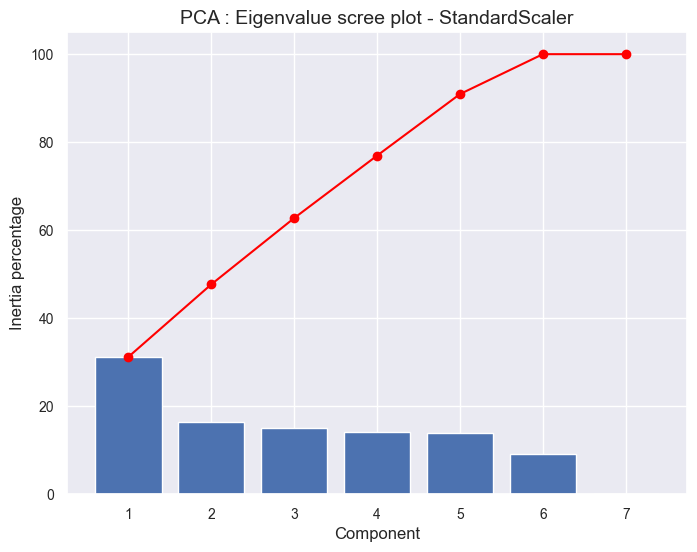

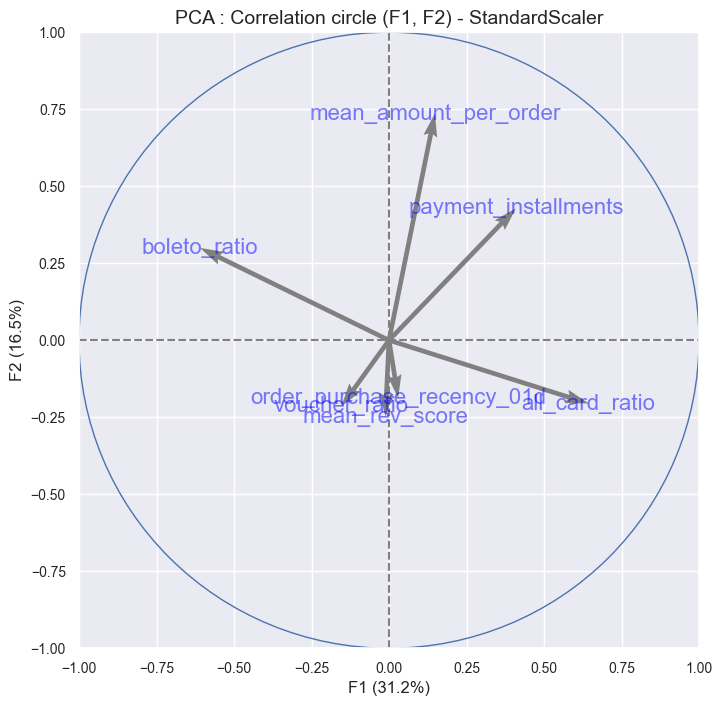

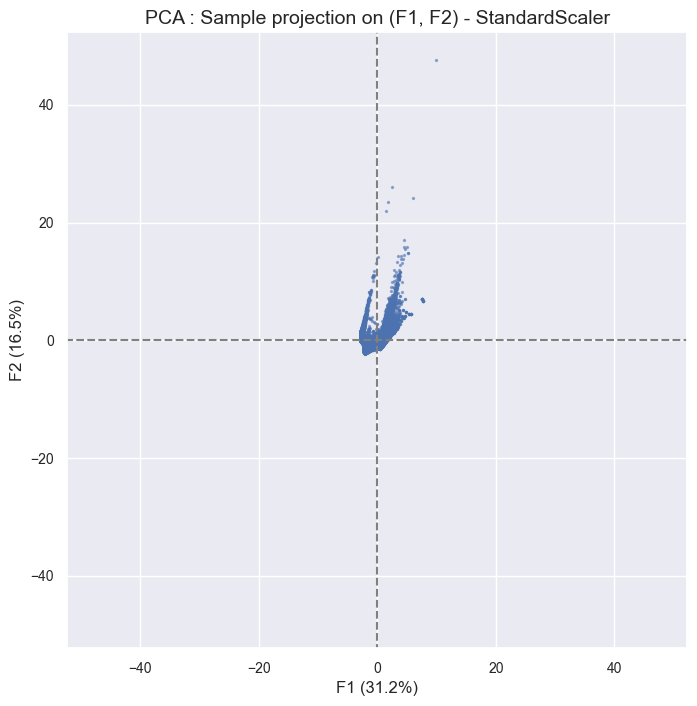

----------------------------------------------------------------------------------------------------
['mean_amount_per_item', 'mean_rev_score', 'payment_installments', 'order_purchase_recency_01d', 'voucher_ratio', 'boleto_ratio', 'all_card_ratio'] ; []
----------------------------------------------------------------------------------------------------




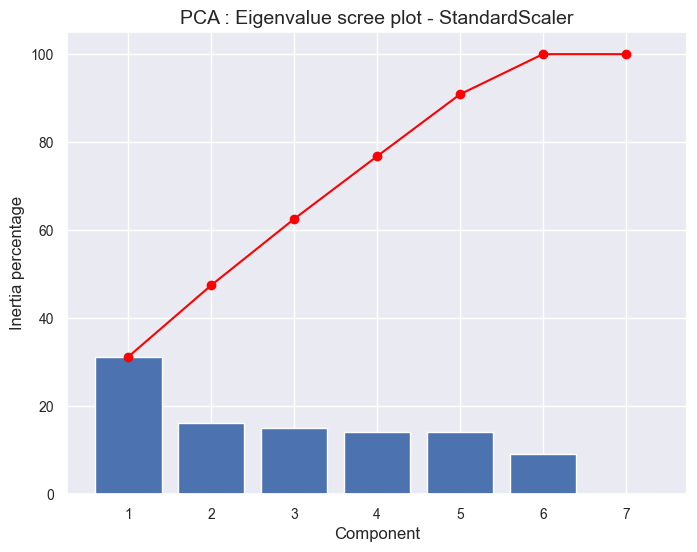

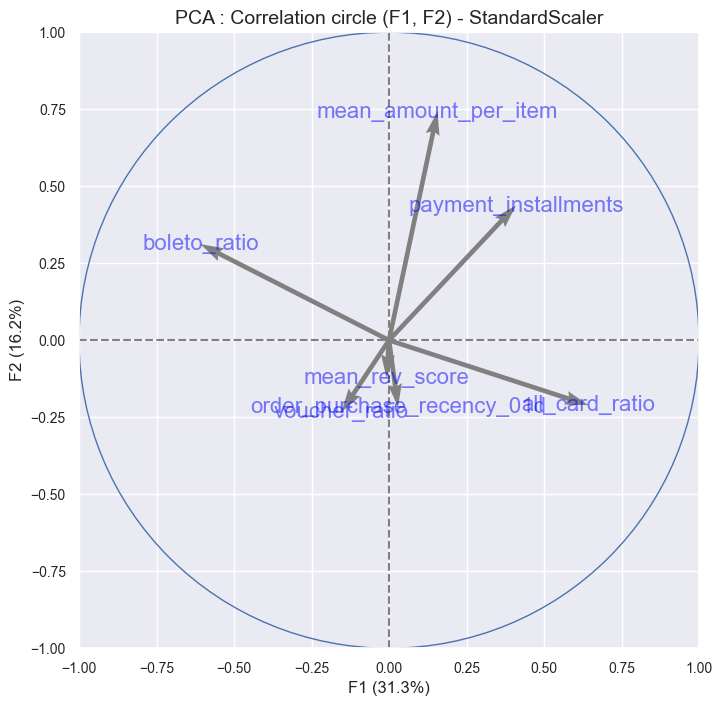

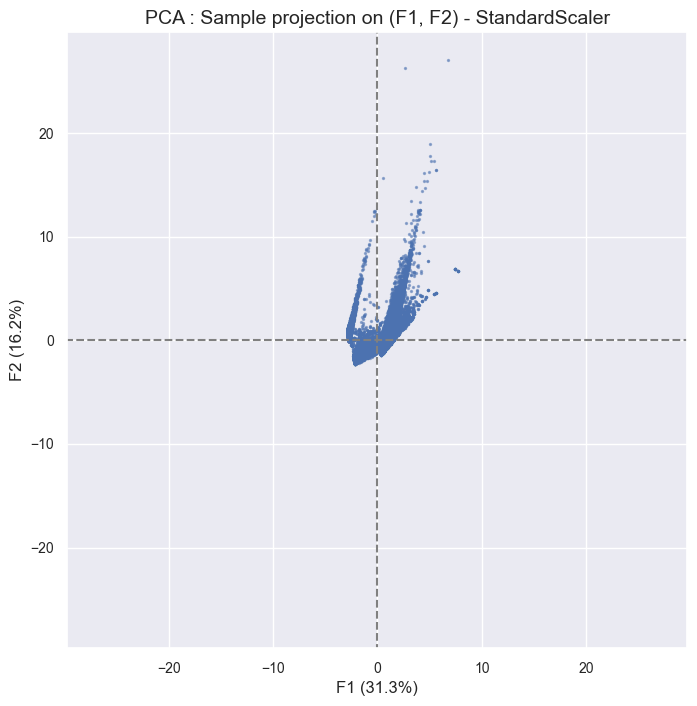

In [479]:
# %matplotlib notebook
%matplotlib inline
launch_FA_DOE(df_doe_init)

# Export du dataset à segmenter

In [482]:
with open(data_processed_dir+'df_cust.pkl', 'wb') as output:
    pickle.dump(df_cust, output, pickle.HIGHEST_PROTOCOL)
    
with open(data_processed_dir+'payment_types_ratio_cols_all_cards.pkl', 'wb') as output:
    pickle.dump(payment_types_ratio_cols_all_cards, output, pickle.HIGHEST_PROTOCOL)